**This notebook is for:**
1. Testing causalML.
https://antonsruberts.github.io/causalml-test/

In [1]:
import sys, os 
prj_path = os.path.dirname(os.getcwd())
utils_path = prj_path + '/utils'
if  not utils_path in sys.path:
    print('adding utils to path ')
    sys.path.insert(1, utils_path)

adding utils to path 


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold

from sklearn.metrics import (
    average_precision_score, roc_auc_score, roc_curve, auc, plot_roc_curve, RocCurveDisplay,
    recall_score, f1_score, mean_absolute_percentage_error,r2_score,average_precision_score
)

import lightgbm as lgbm
from sklift.metrics import qini_auc_score, uplift_auc_score
from sklift.models import  ClassTransformation
from skopt.space import Space
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

from skopt import gp_minimize
# for the analysis
from skopt.plots import (
    plot_convergence,
    plot_evaluations,
    plot_objective
)

from catboost import CatBoostClassifier

from utilities import *
from user_model_evaluation import *

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#Load config.
files = glob.glob(f"{utils_path}/*.yml") 
conf = load_conf(files)

In [3]:
master = pd.read_parquet('MASTER/202203221434.parquet',engine= 'pyarrow')

In [4]:
master['CANARY_VAR'] = np.random.uniform(size = master.shape[0])

In [5]:
#model vars
treatment_var = 'W'
target_var = 'Y'
exclude_vars = ['CUS_CUST_ID', 'SENT_DATE'] + [treatment_var] + [target_var] 
model_vars = list(set(master.columns) - set(exclude_vars))

In [6]:
def check_units(treatment):
    x = np.bincount(treatment)
    return x[0]==x[1]

In [7]:
chk = check_units(master[treatment_var].tolist())
if not chk:
    # For ClassTransformation approach its necesary that P(W=1)=P(W=0) This implies that 
    # we have the same number of users in the two groups.
    ros = RandomOverSampler(random_state=0)
    v = model_vars + [treatment_var] + [target_var]
    X_oversampled, _ = ros.fit_resample(master[v], master[treatment_var])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(master[model_vars + [treatment_var]],
                                                    master[target_var],
                                                    random_state= 142,
                                                    shuffle=True,
                                                    stratify = master[target_var],
                                                    test_size=0.33)

test_treatment = X_test[treatment_var]

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  random_state= 142,
                                                  shuffle=True,
                                                  stratify = y_train,
                                                  test_size=0.33)

train_treatment = X_train[treatment_var]
val_treatment = X_val[treatment_var]

X_train.drop(labels=treatment_var, axis = 1, inplace = True)
X_test.drop(labels=treatment_var, axis = 1, inplace = True)
X_val.drop(labels=treatment_var, axis = 1, inplace = True)

In [71]:
params_grid = [
    Integer(1,16,prior="uniform",name="depth"),
    Integer(5,200,prior="uniform",name="iterations"),
    Real(10**-3, 10**0, prior= "log-uniform", name='learning_rate'),
    Real(0.5, 1, prior= "uniform", name='colsample_bylevel')
]

**score_function.(https://catboost.ai/en/docs/concepts/algorithm-score-functions)**

The score type used to select the next split during the tree construction. Possible values:
- Cosine (do not use this score type with the Lossguide tree growing policy)
- L2 
- NewtonCosine (do not use this score type with the Lossguide tree growing policy)
- NewtonL2


**loss_function.(https://catboost.ai/en/docs/concepts/loss-functions-classification#used-for-optimization)**

The metric to use in training. The specified value also determines the machine learning problem to solve. Some metrics support optional parameters 

**eval_metric.(https://catboost.ai/en/docs/references/eval-metric__supported-metrics)**

The metric used for overfitting detection (if enabled) and best model selection (if enabled).
Some metrics support optional parameters (see the Objectives and metrics section for details on each metric).
Default value: Optimized objective is used

In [72]:
@use_named_args(params_grid)
def objective(**params):
     
    # model with new parameters
    logger.info(f"[TRAIN_MODEL] Training model") 
    logger.info(f'Set of params....., {params}')
    
    cv = StratifiedKFold(n_splits=3, shuffle=True,random_state=1)
    cv_value = []
    for train_index, test_index in cv.split(X_train,y_train):
        
        catClass = CatBoostClassifier(loss_function = 'Logloss',
                                      auto_class_weights = 'Balanced',
                                      score_function = 'L2',
                                      thread_count = -1,
                                      random_state=5,
                                      metric_period=25)
        catClass.set_params(**params)
        classTslearner = ClassTransformation(estimator = catClass)
    
        classTslearner.fit(X = X_train.iloc[train_index],
                           y = y_train.iloc[train_index],
                           treatment = train_treatment.iloc[train_index],
                           estimator_fit_params={'eval_set':(X_val,y_val)}
                          )  
                                     
        y = classTslearner.predict(X_train.iloc[test_index])
        y_true = y_train.iloc[test_index].values
        treatment = train_treatment.iloc[test_index].values
        q = qini_auc_score(y_true = y_true, 
                             uplift = y,
                             treatment = treatment,
                            )
        
        cv_value.append(q)
        del catClass

    value = np.mean(cv_value)  

    logger.info(f"mean cv_value {value} | std cv_value {np.std(cv_value)} ")
    logger.info("---------------------------------------------")

    return -1*value

In [73]:
gp_ = gp_minimize(
    objective, # the objective function to minimize
    params_grid, # the hyperparameter space
    n_initial_points=25, # the number of points to evaluate f(x) to start of
    acq_func='gp_hedge', # the acquisition function
    n_calls=200, # the number of subsequent evaluations of f(x)
    random_state=1,
    n_jobs=-1,
    verbose=True
)

2022-03-30 11:33:03 [TRAIN_MODEL] Training model
2022-03-30 11:33:03 Set of params....., {'depth': 16, 'iterations': 187, 'learning_rate': 0.002423111193333883, 'colsample_bylevel': 0.9995202576620725}


Iteration No: 1 started. Evaluating function at random point.


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.6927911	test: 0.6929737	best: 0.6929737 (0)	total: 3.09s	remaining: 9m 34s
25:	learn: 0.6844635	test: 0.6887317	best: 0.6887317 (25)	total: 1m 16s	remaining: 7m 51s
50:	learn: 0.6770152	test: 0.6848305	best: 0.6848305 (50)	total: 2m 28s	remaining: 6m 34s
75:	learn: 0.6699957	test: 0.6810702	best: 0.6810702 (75)	total: 3m 40s	remaining: 5m 22s
100:	learn: 0.6631909	test: 0.6773673	best: 0.6773673 (100)	total: 4m 53s	remaining: 4m 9s
125:	learn: 0.6566507	test: 0.6737641	best: 0.6737641 (125)	total: 6m 6s	remaining: 2m 57s
150:	learn: 0.6505800	test: 0.6703528	best: 0.6703528 (150)	total: 7m 19s	remaining: 1m 44s
175:	learn: 0.6444251	test: 0.6669326	best: 0.6669326 (175)	total: 8m 32s	remaining: 32.1s
186:	learn: 0.6417819	test: 0.6653861	best: 0.6653861 (186)	total: 9m 4s	remaining: 0us

bestTest = 0.6653860588
bestIteration = 186

0:	learn: 0.6928050	test: 0.6929573	best: 0.6929573 (0)	total: 2.77s	remaining: 8m 34s
25:	learn: 0.6845924	test: 0.6888062	best: 0.6888062 (25)

2022-03-30 12:00:21 mean cv_value 0.028990277733913782 | std cv_value 0.012601970663263627 
2022-03-30 12:00:21 ---------------------------------------------
2022-03-30 12:00:21 [TRAIN_MODEL] Training model
2022-03-30 12:00:21 Set of params....., {'depth': 5, 'iterations': 82, 'learning_rate': 0.014579150644317593, 'colsample_bylevel': 0.8348730184017401}


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1637.7737
Function value obtained: -0.0290
Current minimum: -0.0290
Iteration No: 2 started. Evaluating function at random point.
0:	learn: 0.6930524	test: 0.6929512	best: 0.6929512 (0)	total: 12.5ms	remaining: 1.01s
25:	learn: 0.6913007	test: 0.6889824	best: 0.6889824 (25)	total: 266ms	remaining: 573ms
50:	learn: 0.6902993	test: 0.6865176	best: 0.6865176 (50)	total: 515ms	remaining: 313ms
75:	learn: 0.6896352	test: 0.6848967	best: 0.6848967 (75)	total: 781ms	remaining: 61.7ms
81:	learn: 0.6895084	test: 0.6845858	best: 0.6845858 (81)	total: 847ms	remaining: 0us

bestTest = 0.6845857983
bestIteration = 81

0:	learn: 0.6930552	test: 0.6929484	best: 0.6929484 (0)	total: 13.3ms	remaining: 1.07s
25:	learn: 0.6913742	test: 0.6891003	best: 0.6891003 (25)	total: 272ms	remaining: 587ms
50:	learn: 0.6903903	test: 0.6866464	best: 0.6866464 (50)	total: 533ms	remaining: 324ms
75:	learn: 0.6897404	test: 0.6850133	best: 0.6850133 (75

2022-03-30 12:00:24 mean cv_value 0.059455087850153916 | std cv_value 0.008702306031092084 
2022-03-30 12:00:24 ---------------------------------------------
2022-03-30 12:00:24 [TRAIN_MODEL] Training model
2022-03-30 12:00:24 Set of params....., {'depth': 15, 'iterations': 170, 'learning_rate': 0.008706037847015437, 'colsample_bylevel': 0.7622740797864358}


75:	learn: 0.6898955	test: 0.6851613	best: 0.6851613 (75)	total: 775ms	remaining: 61.2ms
81:	learn: 0.6897624	test: 0.6848467	best: 0.6848467 (81)	total: 837ms	remaining: 0us

bestTest = 0.6848467157
bestIteration = 81

Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.2675
Function value obtained: -0.0595
Current minimum: -0.0595
Iteration No: 3 started. Evaluating function at random point.
0:	learn: 0.6922609	test: 0.6926550	best: 0.6926550 (0)	total: 1.33s	remaining: 3m 45s
25:	learn: 0.6714196	test: 0.6806230	best: 0.6806230 (25)	total: 33.8s	remaining: 3m 7s
50:	learn: 0.6534624	test: 0.6701109	best: 0.6701109 (50)	total: 1m 6s	remaining: 2m 34s
75:	learn: 0.6386163	test: 0.6611587	best: 0.6611587 (75)	total: 1m 38s	remaining: 2m 1s
100:	learn: 0.6257054	test: 0.6533127	best: 0.6533127 (100)	total: 2m 10s	remaining: 1m 29s
125:	learn: 0.6139986	test: 0.6463124	best: 0.6463124 (125)	total: 2m 42s	remaining: 56.8s
150:	learn: 0.6035244	test: 0.6401140	best: 0.640

2022-03-30 12:11:26 mean cv_value 0.029293999931674374 | std cv_value 0.004799813049886253 
2022-03-30 12:11:26 ---------------------------------------------
2022-03-30 12:11:26 [TRAIN_MODEL] Training model
2022-03-30 12:11:26 Set of params....., {'depth': 8, 'iterations': 50, 'learning_rate': 0.04010899007934542, 'colsample_bylevel': 0.9569810122896165}


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 661.8382
Function value obtained: -0.0293
Current minimum: -0.0595
Iteration No: 4 started. Evaluating function at random point.
0:	learn: 0.6927541	test: 0.6925262	best: 0.6925262 (0)	total: 21.5ms	remaining: 1.05s
25:	learn: 0.6864521	test: 0.6829034	best: 0.6829034 (25)	total: 514ms	remaining: 474ms
49:	learn: 0.6827402	test: 0.6788259	best: 0.6788259 (49)	total: 984ms	remaining: 0us

bestTest = 0.6788258572
bestIteration = 49

0:	learn: 0.6927253	test: 0.6925159	best: 0.6925159 (0)	total: 21.4ms	remaining: 1.05s
25:	learn: 0.6864634	test: 0.6829547	best: 0.6829547 (25)	total: 516ms	remaining: 476ms
49:	learn: 0.6826021	test: 0.6788794	best: 0.6788794 (49)	total: 989ms	remaining: 0us

bestTest = 0.6788793802
bestIteration = 49

0:	learn: 0.6927615	test: 0.6924850	best: 0.6924850 (0)	total: 21ms	remaining: 1.03s
25:	learn: 0.6866949	test: 0.6830529	best: 0.6830529 (25)	total: 514ms	remaining: 474ms


2022-03-30 12:11:30 mean cv_value 0.0600051050014066 | std cv_value 0.00969822603878937 
2022-03-30 12:11:30 ---------------------------------------------
2022-03-30 12:11:30 [TRAIN_MODEL] Training model
2022-03-30 12:11:30 Set of params....., {'depth': 8, 'iterations': 89, 'learning_rate': 0.6567247264241928, 'colsample_bylevel': 0.8891946181682668}


49:	learn: 0.6829737	test: 0.6790372	best: 0.6790372 (49)	total: 979ms	remaining: 0us

bestTest = 0.6790371566
bestIteration = 49

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 3.6688
Function value obtained: -0.0600
Current minimum: -0.0600
Iteration No: 5 started. Evaluating function at random point.
0:	learn: 0.6887678	test: 0.6849850	best: 0.6849850 (0)	total: 22ms	remaining: 1.94s
25:	learn: 0.6575747	test: 0.6733740	best: 0.6733740 (25)	total: 541ms	remaining: 1.31s
50:	learn: 0.6331789	test: 0.6672719	best: 0.6672719 (50)	total: 1.06s	remaining: 791ms
75:	learn: 0.6108343	test: 0.6620483	best: 0.6620483 (75)	total: 1.59s	remaining: 272ms
88:	learn: 0.6000898	test: 0.6598428	best: 0.6598428 (88)	total: 1.85s	remaining: 0us

bestTest = 0.6598428078
bestIteration = 88

0:	learn: 0.6885114	test: 0.6852094	best: 0.6852094 (0)	total: 21.2ms	remaining: 1.87s
25:	learn: 0.6594826	test: 0.6749411	best: 0.6749411 (25)	total: 536ms	remaining: 1.3s
50:	learn: 0.6361137

2022-03-30 12:11:36 mean cv_value 0.01800888209442569 | std cv_value 0.01244321229754965 
2022-03-30 12:11:36 ---------------------------------------------
2022-03-30 12:11:36 [TRAIN_MODEL] Training model
2022-03-30 12:11:36 Set of params....., {'depth': 12, 'iterations': 162, 'learning_rate': 0.0018984642612488343, 'colsample_bylevel': 0.7590762744709445}


88:	learn: 0.5996709	test: 0.6594970	best: 0.6594970 (88)	total: 1.83s	remaining: 0us

bestTest = 0.6594969825
bestIteration = 88

Iteration No: 5 ended. Evaluation done at random point.
Time taken: 6.2583
Function value obtained: -0.0180
Current minimum: -0.0600
Iteration No: 6 started. Evaluating function at random point.
0:	learn: 0.6930726	test: 0.6930844	best: 0.6930844 (0)	total: 101ms	remaining: 16.2s
25:	learn: 0.6912197	test: 0.6915646	best: 0.6915646 (25)	total: 2.61s	remaining: 13.6s
50:	learn: 0.6894205	test: 0.6900936	best: 0.6900936 (50)	total: 5.1s	remaining: 11.1s
75:	learn: 0.6877158	test: 0.6887024	best: 0.6887024 (75)	total: 7.62s	remaining: 8.62s
100:	learn: 0.6860342	test: 0.6873480	best: 0.6873480 (100)	total: 10.1s	remaining: 6.12s
125:	learn: 0.6843760	test: 0.6860350	best: 0.6860350 (125)	total: 12.6s	remaining: 3.61s
150:	learn: 0.6828015	test: 0.6847876	best: 0.6847876 (150)	total: 15.1s	remaining: 1.1s
161:	learn: 0.6821599	test: 0.6842755	best: 0.6842755 (1

2022-03-30 12:12:26 mean cv_value 0.05169925535919661 | std cv_value 0.008443776190277983 
2022-03-30 12:12:26 ---------------------------------------------
2022-03-30 12:12:26 [TRAIN_MODEL] Training model
2022-03-30 12:12:26 Set of params....., {'depth': 14, 'iterations': 167, 'learning_rate': 0.30818399325675105, 'colsample_bylevel': 0.6365249871083737}


161:	learn: 0.6815358	test: 0.6839310	best: 0.6839310 (161)	total: 16.5s	remaining: 0us

bestTest = 0.6839309596
bestIteration = 161

Iteration No: 6 ended. Evaluation done at random point.
Time taken: 49.9821
Function value obtained: -0.0517
Current minimum: -0.0600
Iteration No: 7 started. Evaluating function at random point.
0:	learn: 0.6702129	test: 0.6815583	best: 0.6815583 (0)	total: 627ms	remaining: 1m 44s
25:	learn: 0.4907459	test: 0.5990769	best: 0.5990769 (25)	total: 16s	remaining: 1m 26s
50:	learn: 0.4106619	test: 0.5731806	best: 0.5731806 (50)	total: 30.9s	remaining: 1m 10s
75:	learn: 0.3557102	test: 0.5566187	best: 0.5566187 (75)	total: 45.8s	remaining: 54.8s
100:	learn: 0.3145271	test: 0.5456851	best: 0.5456851 (100)	total: 1m	remaining: 39.8s
125:	learn: 0.2780652	test: 0.5395477	best: 0.5395477 (125)	total: 1m 15s	remaining: 24.7s
150:	learn: 0.2512679	test: 0.5358590	best: 0.5358590 (150)	total: 1m 31s	remaining: 9.66s
166:	learn: 0.2382617	test: 0.5333682	best: 0.5333

2022-03-30 12:17:31 mean cv_value -0.0039949181644930885 | std cv_value 0.016305860076530353 
2022-03-30 12:17:31 ---------------------------------------------
2022-03-30 12:17:31 [TRAIN_MODEL] Training model
2022-03-30 12:17:31 Set of params....., {'depth': 2, 'iterations': 136, 'learning_rate': 0.06014458808993631, 'colsample_bylevel': 0.8358270487110673}


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 305.2012
Function value obtained: 0.0040
Current minimum: -0.0600
Iteration No: 8 started. Evaluating function at random point.
0:	learn: 0.6928654	test: 0.6924888	best: 0.6924888 (0)	total: 14.3ms	remaining: 1.94s
25:	learn: 0.6904839	test: 0.6856829	best: 0.6856829 (25)	total: 178ms	remaining: 754ms
50:	learn: 0.6899058	test: 0.6838246	best: 0.6838246 (50)	total: 333ms	remaining: 556ms
75:	learn: 0.6895844	test: 0.6829089	best: 0.6829089 (75)	total: 497ms	remaining: 392ms
100:	learn: 0.6893593	test: 0.6823668	best: 0.6823668 (100)	total: 668ms	remaining: 231ms
125:	learn: 0.6891582	test: 0.6821040	best: 0.6821040 (125)	total: 826ms	remaining: 65.6ms
135:	learn: 0.6890879	test: 0.6819834	best: 0.6819834 (135)	total: 890ms	remaining: 0us

bestTest = 0.6819834473
bestIteration = 135

0:	learn: 0.6928941	test: 0.6925095	best: 0.6925095 (0)	total: 8.69ms	remaining: 1.17s
25:	learn: 0.6906846	test: 0.6859289	best: 0.685928

2022-03-30 12:17:34 mean cv_value 0.057874687882983396 | std cv_value 0.006190200853062535 
2022-03-30 12:17:34 ---------------------------------------------
2022-03-30 12:17:34 [TRAIN_MODEL] Training model
2022-03-30 12:17:34 Set of params....., {'depth': 7, 'iterations': 44, 'learning_rate': 0.007394161323427775, 'colsample_bylevel': 0.5710600677374785}


135:	learn: 0.6893254	test: 0.6821989	best: 0.6821989 (135)	total: 847ms	remaining: 0us

bestTest = 0.6821989302
bestIteration = 135

Iteration No: 8 ended. Evaluation done at random point.
Time taken: 3.3731
Function value obtained: -0.0579
Current minimum: -0.0600
Iteration No: 9 started. Evaluating function at random point.
0:	learn: 0.6930807	test: 0.6930304	best: 0.6930304 (0)	total: 19.2ms	remaining: 825ms
25:	learn: 0.6917413	test: 0.6905124	best: 0.6905124 (25)	total: 429ms	remaining: 297ms
43:	learn: 0.6909580	test: 0.6890170	best: 0.6890170 (43)	total: 735ms	remaining: 0us

bestTest = 0.6890170297
bestIteration = 43

0:	learn: 0.6930939	test: 0.6930366	best: 0.6930366 (0)	total: 15.6ms	remaining: 673ms
25:	learn: 0.6917864	test: 0.6905898	best: 0.6905898 (25)	total: 435ms	remaining: 301ms
43:	learn: 0.6910212	test: 0.6891284	best: 0.6891284 (43)	total: 728ms	remaining: 0us

bestTest = 0.6891283574
bestIteration = 43

0:	learn: 0.6930845	test: 0.6930342	best: 0.6930342 (0)	tot

2022-03-30 12:17:37 mean cv_value 0.054444859044730225 | std cv_value 0.00773532453138491 
2022-03-30 12:17:37 ---------------------------------------------
2022-03-30 12:17:37 [TRAIN_MODEL] Training model
2022-03-30 12:17:37 Set of params....., {'depth': 13, 'iterations': 85, 'learning_rate': 0.0012662338916967768, 'colsample_bylevel': 0.8120149932386767}


43:	learn: 0.6910764	test: 0.6891962	best: 0.6891962 (43)	total: 743ms	remaining: 0us

bestTest = 0.6891962068
bestIteration = 43

Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.9100
Function value obtained: -0.0544
Current minimum: -0.0600
Iteration No: 10 started. Evaluating function at random point.
0:	learn: 0.6930797	test: 0.6930945	best: 0.6930945 (0)	total: 307ms	remaining: 25.8s
25:	learn: 0.6913190	test: 0.6918388	best: 0.6918388 (25)	total: 7.7s	remaining: 17.5s
50:	learn: 0.6895600	test: 0.6905956	best: 0.6905956 (50)	total: 15.1s	remaining: 10s
75:	learn: 0.6878232	test: 0.6893658	best: 0.6893658 (75)	total: 22.4s	remaining: 2.65s
84:	learn: 0.6872187	test: 0.6889329	best: 0.6889329 (84)	total: 25.1s	remaining: 0us

bestTest = 0.6889329106
bestIteration = 84

0:	learn: 0.6930704	test: 0.6930909	best: 0.6930909 (0)	total: 304ms	remaining: 25.5s
25:	learn: 0.6911588	test: 0.6917324	best: 0.6917324 (25)	total: 7.74s	remaining: 17.6s
50:	learn: 0.6893328	

2022-03-30 12:18:54 mean cv_value 0.044253311598482385 | std cv_value 0.00870208883997345 
2022-03-30 12:18:54 ---------------------------------------------
2022-03-30 12:18:54 [TRAIN_MODEL] Training model
2022-03-30 12:18:54 Set of params....., {'depth': 11, 'iterations': 63, 'learning_rate': 0.02179734099288658, 'colsample_bylevel': 0.6110622737676874}


84:	learn: 0.6868557	test: 0.6887071	best: 0.6887071 (84)	total: 25.2s	remaining: 0us

bestTest = 0.6887071324
bestIteration = 84

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 76.3736
Function value obtained: -0.0443
Current minimum: -0.0600
Iteration No: 11 started. Evaluating function at random point.
0:	learn: 0.6925480	test: 0.6925539	best: 0.6925539 (0)	total: 63ms	remaining: 3.9s
25:	learn: 0.6802008	test: 0.6812268	best: 0.6812268 (25)	total: 1.53s	remaining: 2.17s
50:	learn: 0.6712942	test: 0.6739563	best: 0.6739563 (50)	total: 2.96s	remaining: 697ms
62:	learn: 0.6680058	test: 0.6714236	best: 0.6714236 (62)	total: 3.62s	remaining: 0us

bestTest = 0.6714236486
bestIteration = 62

0:	learn: 0.6925456	test: 0.6925290	best: 0.6925290 (0)	total: 65.5ms	remaining: 4.06s
25:	learn: 0.6799773	test: 0.6811543	best: 0.6811543 (25)	total: 1.55s	remaining: 2.21s
50:	learn: 0.6704786	test: 0.6735634	best: 0.6735634 (50)	total: 3.01s	remaining: 708ms
62:	learn: 0.6665

2022-03-30 12:19:06 mean cv_value 0.054877242110597656 | std cv_value 0.013854182920184172 
2022-03-30 12:19:06 ---------------------------------------------
2022-03-30 12:19:06 [TRAIN_MODEL] Training model
2022-03-30 12:19:06 Set of params....., {'depth': 2, 'iterations': 97, 'learning_rate': 0.0019431967763853617, 'colsample_bylevel': 0.9516850832394338}


62:	learn: 0.6670518	test: 0.6711644	best: 0.6711644 (62)	total: 3.68s	remaining: 0us

bestTest = 0.6711643904
bestIteration = 62

Iteration No: 11 ended. Evaluation done at random point.
Time taken: 11.7675
Function value obtained: -0.0549
Current minimum: -0.0600
Iteration No: 12 started. Evaluating function at random point.
0:	learn: 0.6931406	test: 0.6931256	best: 0.6931256 (0)	total: 8.23ms	remaining: 790ms
25:	learn: 0.6929352	test: 0.6926304	best: 0.6926304 (25)	total: 160ms	remaining: 437ms
50:	learn: 0.6927209	test: 0.6921479	best: 0.6921479 (50)	total: 312ms	remaining: 282ms
75:	learn: 0.6925405	test: 0.6917038	best: 0.6917038 (75)	total: 463ms	remaining: 128ms
96:	learn: 0.6924045	test: 0.6913576	best: 0.6913576 (96)	total: 590ms	remaining: 0us

bestTest = 0.6913575973
bestIteration = 96

0:	learn: 0.6931400	test: 0.6931263	best: 0.6931263 (0)	total: 7.97ms	remaining: 766ms
25:	learn: 0.6929431	test: 0.6926379	best: 0.6926379 (25)	total: 164ms	remaining: 447ms
50:	learn: 0.6

2022-03-30 12:19:08 mean cv_value 0.04972520764590257 | std cv_value 0.013185674514110582 
2022-03-30 12:19:08 ---------------------------------------------
2022-03-30 12:19:08 [TRAIN_MODEL] Training model
2022-03-30 12:19:08 Set of params....., {'depth': 3, 'iterations': 107, 'learning_rate': 0.0017818412701725806, 'colsample_bylevel': 0.9584306672648644}


96:	learn: 0.6924965	test: 0.6915230	best: 0.6915230 (96)	total: 606ms	remaining: 0us

bestTest = 0.6915230349
bestIteration = 96

Iteration No: 12 ended. Evaluation done at random point.
Time taken: 2.5001
Function value obtained: -0.0497
Current minimum: -0.0600
Iteration No: 13 started. Evaluating function at random point.
0:	learn: 0.6931393	test: 0.6931248	best: 0.6931248 (0)	total: 9.38ms	remaining: 994ms
25:	learn: 0.6928994	test: 0.6925844	best: 0.6925844 (25)	total: 196ms	remaining: 610ms
50:	learn: 0.6926832	test: 0.6920816	best: 0.6920816 (50)	total: 377ms	remaining: 413ms
75:	learn: 0.6924833	test: 0.6916064	best: 0.6916064 (75)	total: 559ms	remaining: 228ms
100:	learn: 0.6922992	test: 0.6911611	best: 0.6911611 (100)	total: 739ms	remaining: 43.9ms
106:	learn: 0.6922556	test: 0.6910582	best: 0.6910582 (106)	total: 783ms	remaining: 0us

bestTest = 0.6910581683
bestIteration = 106

0:	learn: 0.6931459	test: 0.6931267	best: 0.6931267 (0)	total: 8.76ms	remaining: 928ms
25:	learn

2022-03-30 12:19:11 mean cv_value 0.05240791451729777 | std cv_value 0.006441760933993392 
2022-03-30 12:19:11 ---------------------------------------------
2022-03-30 12:19:11 [TRAIN_MODEL] Training model
2022-03-30 12:19:11 Set of params....., {'depth': 15, 'iterations': 63, 'learning_rate': 0.056645754031067724, 'colsample_bylevel': 0.7829560137320966}


100:	learn: 0.6923959	test: 0.6912840	best: 0.6912840 (100)	total: 730ms	remaining: 43.4ms
106:	learn: 0.6923587	test: 0.6911866	best: 0.6911866 (106)	total: 777ms	remaining: 0us

bestTest = 0.6911865549
bestIteration = 106

Iteration No: 13 ended. Evaluation done at random point.
Time taken: 3.0373
Function value obtained: -0.0524
Current minimum: -0.0600
Iteration No: 14 started. Evaluating function at random point.
0:	learn: 0.6871315	test: 0.6898459	best: 0.6898459 (0)	total: 1.33s	remaining: 1m 22s
25:	learn: 0.5942219	test: 0.6356777	best: 0.6356777 (25)	total: 33.9s	remaining: 48.3s
50:	learn: 0.5465667	test: 0.6094354	best: 0.6094354 (50)	total: 1m 6s	remaining: 15.6s
62:	learn: 0.5312879	test: 0.6011397	best: 0.6011397 (62)	total: 1m 21s	remaining: 0us

bestTest = 0.6011396768
bestIteration = 62

0:	learn: 0.6879667	test: 0.6901301	best: 0.6901301 (0)	total: 1.32s	remaining: 1m 21s
25:	learn: 0.5957389	test: 0.6377361	best: 0.6377361 (25)	total: 33.6s	remaining: 47.9s
50:	lear

2022-03-30 12:23:16 mean cv_value 0.020009320931946642 | std cv_value 0.015255000127234498 
2022-03-30 12:23:16 ---------------------------------------------
2022-03-30 12:23:16 [TRAIN_MODEL] Training model
2022-03-30 12:23:16 Set of params....., {'depth': 10, 'iterations': 192, 'learning_rate': 0.006066482356416916, 'colsample_bylevel': 0.6155077111062945}


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 245.1367
Function value obtained: -0.0200
Current minimum: -0.0600
Iteration No: 15 started. Evaluating function at random point.
0:	learn: 0.6930311	test: 0.6930103	best: 0.6930103 (0)	total: 43.1ms	remaining: 8.24s
25:	learn: 0.6903623	test: 0.6899310	best: 0.6899310 (25)	total: 1.04s	remaining: 6.62s
50:	learn: 0.6880049	test: 0.6873051	best: 0.6873051 (50)	total: 2.02s	remaining: 5.58s
75:	learn: 0.6858953	test: 0.6850311	best: 0.6850311 (75)	total: 2.99s	remaining: 4.57s
100:	learn: 0.6839623	test: 0.6830464	best: 0.6830464 (100)	total: 3.95s	remaining: 3.56s
125:	learn: 0.6822171	test: 0.6813111	best: 0.6813111 (125)	total: 4.92s	remaining: 2.57s
150:	learn: 0.6805012	test: 0.6797012	best: 0.6797012 (150)	total: 5.88s	remaining: 1.6s
175:	learn: 0.6789527	test: 0.6782804	best: 0.6782804 (175)	total: 6.84s	remaining: 622ms
191:	learn: 0.6779935	test: 0.6774380	best: 0.6774380 (191)	total: 7.46s	remaining: 0us

be

2022-03-30 12:23:40 mean cv_value 0.05648272053348761 | std cv_value 0.010390970891706486 
2022-03-30 12:23:40 ---------------------------------------------
2022-03-30 12:23:40 [TRAIN_MODEL] Training model
2022-03-30 12:23:40 Set of params....., {'depth': 9, 'iterations': 190, 'learning_rate': 0.03014246606415112, 'colsample_bylevel': 0.770300254411822}


191:	learn: 0.6779421	test: 0.6775469	best: 0.6775469 (191)	total: 7.61s	remaining: 0us

bestTest = 0.6775469086
bestIteration = 191

Iteration No: 15 ended. Evaluation done at random point.
Time taken: 23.4366
Function value obtained: -0.0565
Current minimum: -0.0600
Iteration No: 16 started. Evaluating function at random point.
0:	learn: 0.6927461	test: 0.6926020	best: 0.6926020 (0)	total: 32.3ms	remaining: 6.1s
25:	learn: 0.6855705	test: 0.6831994	best: 0.6831994 (25)	total: 851ms	remaining: 5.37s
50:	learn: 0.6806730	test: 0.6781200	best: 0.6781200 (50)	total: 1.64s	remaining: 4.47s
75:	learn: 0.6768582	test: 0.6749814	best: 0.6749814 (75)	total: 2.42s	remaining: 3.64s
100:	learn: 0.6736567	test: 0.6727058	best: 0.6727058 (100)	total: 3.18s	remaining: 2.8s
125:	learn: 0.6707058	test: 0.6707686	best: 0.6707686 (125)	total: 3.94s	remaining: 2s
150:	learn: 0.6676109	test: 0.6689219	best: 0.6689219 (150)	total: 4.69s	remaining: 1.21s
175:	learn: 0.6645221	test: 0.6671710	best: 0.667171

2022-03-30 12:23:58 mean cv_value 0.05570090047380774 | std cv_value 0.011102914677854646 
2022-03-30 12:23:58 ---------------------------------------------
2022-03-30 12:23:58 [TRAIN_MODEL] Training model
2022-03-30 12:23:58 Set of params....., {'depth': 12, 'iterations': 14, 'learning_rate': 0.00262965247513123, 'colsample_bylevel': 0.8962017928980097}


189:	learn: 0.6618653	test: 0.6659500	best: 0.6659500 (189)	total: 5.94s	remaining: 0us

bestTest = 0.6659499666
bestIteration = 189

Iteration No: 16 ended. Evaluation done at random point.
Time taken: 18.6656
Function value obtained: -0.0557
Current minimum: -0.0600
Iteration No: 17 started. Evaluating function at random point.
0:	learn: 0.6930397	test: 0.6930601	best: 0.6930601 (0)	total: 114ms	remaining: 1.49s
13:	learn: 0.6917036	test: 0.6919648	best: 0.6919648 (13)	total: 1.46s	remaining: 0us

bestTest = 0.6919648065
bestIteration = 13

0:	learn: 0.6930515	test: 0.6930689	best: 0.6930689 (0)	total: 105ms	remaining: 1.37s
13:	learn: 0.6915911	test: 0.6918925	best: 0.6918925 (13)	total: 1.44s	remaining: 0us

bestTest = 0.6918924834
bestIteration = 13

0:	learn: 0.6930304	test: 0.6930550	best: 0.6930550 (0)	total: 103ms	remaining: 1.34s


2022-03-30 12:24:03 mean cv_value 0.04036934092358799 | std cv_value 0.011613194200943554 
2022-03-30 12:24:03 ---------------------------------------------
2022-03-30 12:24:03 [TRAIN_MODEL] Training model
2022-03-30 12:24:03 Set of params....., {'depth': 1, 'iterations': 177, 'learning_rate': 0.04191452692639984, 'colsample_bylevel': 0.7239900907102091}


13:	learn: 0.6915845	test: 0.6918862	best: 0.6918862 (13)	total: 1.48s	remaining: 0us

bestTest = 0.6918862402
bestIteration = 13

Iteration No: 17 ended. Evaluation done at random point.
Time taken: 5.1029
Function value obtained: -0.0404
Current minimum: -0.0600
Iteration No: 18 started. Evaluating function at random point.
0:	learn: 0.6929996	test: 0.6928360	best: 0.6928360 (0)	total: 8.4ms	remaining: 1.48s
25:	learn: 0.6915018	test: 0.6888358	best: 0.6888358 (25)	total: 139ms	remaining: 809ms
50:	learn: 0.6910043	test: 0.6870536	best: 0.6870536 (50)	total: 265ms	remaining: 655ms
75:	learn: 0.6907708	test: 0.6862245	best: 0.6862245 (75)	total: 390ms	remaining: 519ms
100:	learn: 0.6906034	test: 0.6855841	best: 0.6855841 (100)	total: 514ms	remaining: 387ms
125:	learn: 0.6904722	test: 0.6852142	best: 0.6852142 (125)	total: 637ms	remaining: 258ms
150:	learn: 0.6903688	test: 0.6848856	best: 0.6848856 (150)	total: 762ms	remaining: 131ms
175:	learn: 0.6902793	test: 0.6845742	best: 0.684574

2022-03-30 12:24:07 mean cv_value 0.05091237789874952 | std cv_value 0.010037667151535624 
2022-03-30 12:24:07 ---------------------------------------------
2022-03-30 12:24:07 [TRAIN_MODEL] Training model
2022-03-30 12:24:07 Set of params....., {'depth': 14, 'iterations': 79, 'learning_rate': 0.04123576755384985, 'colsample_bylevel': 0.8261494410317711}


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 3.4187
Function value obtained: -0.0509
Current minimum: -0.0600
Iteration No: 19 started. Evaluating function at random point.
0:	learn: 0.6897051	test: 0.6911274	best: 0.6911274 (0)	total: 627ms	remaining: 48.9s
25:	learn: 0.6342819	test: 0.6561743	best: 0.6561743 (25)	total: 16.5s	remaining: 33.6s
50:	learn: 0.6012575	test: 0.6364424	best: 0.6364424 (50)	total: 32.3s	remaining: 17.7s
75:	learn: 0.5784628	test: 0.6237008	best: 0.6237008 (75)	total: 48.1s	remaining: 1.9s
78:	learn: 0.5763388	test: 0.6225589	best: 0.6225589 (78)	total: 49.9s	remaining: 0us

bestTest = 0.6225588864
bestIteration = 78

0:	learn: 0.6898389	test: 0.6910420	best: 0.6910420 (0)	total: 634ms	remaining: 49.4s
25:	learn: 0.6333049	test: 0.6562257	best: 0.6562257 (25)	total: 16.6s	remaining: 33.8s
50:	learn: 0.6001745	test: 0.6365593	best: 0.6365593 (50)	total: 32.3s	remaining: 17.7s
75:	learn: 0.5770403	test: 0.6233956	best: 0.6233956 (75)	tot

2022-03-30 12:26:38 mean cv_value 0.038470735516423576 | std cv_value 0.018876260532586096 
2022-03-30 12:26:38 ---------------------------------------------
2022-03-30 12:26:38 [TRAIN_MODEL] Training model
2022-03-30 12:26:38 Set of params....., {'depth': 6, 'iterations': 116, 'learning_rate': 0.08194254573277535, 'colsample_bylevel': 0.5631574425224442}


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 151.5379
Function value obtained: -0.0385
Current minimum: -0.0600
Iteration No: 20 started. Evaluating function at random point.
0:	learn: 0.6925671	test: 0.6919679	best: 0.6919679 (0)	total: 15ms	remaining: 1.72s
25:	learn: 0.6873486	test: 0.6815660	best: 0.6815660 (25)	total: 359ms	remaining: 1.24s
50:	learn: 0.6849564	test: 0.6789921	best: 0.6789921 (50)	total: 696ms	remaining: 886ms
75:	learn: 0.6827545	test: 0.6775082	best: 0.6775082 (75)	total: 1.03s	remaining: 543ms
100:	learn: 0.6807057	test: 0.6761065	best: 0.6761065 (100)	total: 1.38s	remaining: 204ms
115:	learn: 0.6795121	test: 0.6754623	best: 0.6754623 (115)	total: 1.57s	remaining: 0us

bestTest = 0.6754623328
bestIteration = 115

0:	learn: 0.6926254	test: 0.6919840	best: 0.6919840 (0)	total: 14.6ms	remaining: 1.68s
25:	learn: 0.6874319	test: 0.6816431	best: 0.6816431 (25)	total: 350ms	remaining: 1.21s
50:	learn: 0.6850738	test: 0.6793208	best: 0.6793208 

2022-03-30 12:26:44 mean cv_value 0.062266930273997316 | std cv_value 0.01045028156532257 
2022-03-30 12:26:44 ---------------------------------------------
2022-03-30 12:26:44 [TRAIN_MODEL] Training model
2022-03-30 12:26:44 Set of params....., {'depth': 11, 'iterations': 131, 'learning_rate': 0.011529680332917293, 'colsample_bylevel': 0.881616526357561}


115:	learn: 0.6802320	test: 0.6760445	best: 0.6760445 (115)	total: 1.56s	remaining: 0us

bestTest = 0.6760445457
bestIteration = 115

Iteration No: 20 ended. Evaluation done at random point.
Time taken: 5.4226
Function value obtained: -0.0623
Current minimum: -0.0623
Iteration No: 21 started. Evaluating function at random point.
0:	learn: 0.6927953	test: 0.6928021	best: 0.6928021 (0)	total: 66.3ms	remaining: 8.61s
25:	learn: 0.6857877	test: 0.6862566	best: 0.6862566 (25)	total: 1.65s	remaining: 6.65s
50:	learn: 0.6799225	test: 0.6810613	best: 0.6810613 (50)	total: 3.19s	remaining: 5s
75:	learn: 0.6749056	test: 0.6767889	best: 0.6767889 (75)	total: 4.7s	remaining: 3.4s
100:	learn: 0.6701605	test: 0.6730872	best: 0.6730872 (100)	total: 6.19s	remaining: 1.84s
125:	learn: 0.6663523	test: 0.6702356	best: 0.6702356 (125)	total: 7.66s	remaining: 304ms
130:	learn: 0.6657261	test: 0.6697637	best: 0.6697637 (130)	total: 7.95s	remaining: 0us

bestTest = 0.6697636818
bestIteration = 130

0:	learn:

2022-03-30 12:27:09 mean cv_value 0.059950602287650645 | std cv_value 0.008572727443956301 
2022-03-30 12:27:09 ---------------------------------------------
2022-03-30 12:27:09 [TRAIN_MODEL] Training model
2022-03-30 12:27:09 Set of params....., {'depth': 6, 'iterations': 152, 'learning_rate': 0.44058072059144754, 'colsample_bylevel': 0.5058345968404468}


130:	learn: 0.6649655	test: 0.6695986	best: 0.6695986 (130)	total: 8.06s	remaining: 0us

bestTest = 0.6695985586
bestIteration = 130

Iteration No: 21 ended. Evaluation done at random point.
Time taken: 24.8016
Function value obtained: -0.0600
Current minimum: -0.0623
Iteration No: 22 started. Evaluating function at random point.
0:	learn: 0.6906974	test: 0.6874244	best: 0.6874244 (0)	total: 14.8ms	remaining: 2.24s
25:	learn: 0.6801056	test: 0.6774936	best: 0.6774936 (25)	total: 346ms	remaining: 1.68s
50:	learn: 0.6723476	test: 0.6738310	best: 0.6738310 (50)	total: 679ms	remaining: 1.34s
75:	learn: 0.6647968	test: 0.6714827	best: 0.6714827 (75)	total: 1s	remaining: 1s
100:	learn: 0.6579294	test: 0.6692680	best: 0.6692680 (100)	total: 1.33s	remaining: 673ms
125:	learn: 0.6514707	test: 0.6670823	best: 0.6670823 (125)	total: 1.66s	remaining: 343ms
150:	learn: 0.6453998	test: 0.6651451	best: 0.6651451 (150)	total: 1.99s	remaining: 13.2ms
151:	learn: 0.6452119	test: 0.6651725	best: 0.665145

2022-03-30 12:27:15 mean cv_value 0.022938804233456848 | std cv_value 0.004615191644953426 
2022-03-30 12:27:15 ---------------------------------------------
2022-03-30 12:27:15 [TRAIN_MODEL] Training model
2022-03-30 12:27:15 Set of params....., {'depth': 8, 'iterations': 19, 'learning_rate': 0.22953791023466025, 'colsample_bylevel': 0.5320336649191086}


150:	learn: 0.6464860	test: 0.6651081	best: 0.6651081 (150)	total: 2.03s	remaining: 13.4ms
151:	learn: 0.6462632	test: 0.6649303	best: 0.6649303 (151)	total: 2.04s	remaining: 0us

bestTest = 0.6649302777
bestIteration = 151

Iteration No: 22 ended. Evaluation done at random point.
Time taken: 6.8122
Function value obtained: -0.0229
Current minimum: -0.0623
Iteration No: 23 started. Evaluating function at random point.
0:	learn: 0.6911820	test: 0.6897303	best: 0.6897303 (0)	total: 22.9ms	remaining: 413ms
18:	learn: 0.6777102	test: 0.6754251	best: 0.6754251 (18)	total: 430ms	remaining: 0us

bestTest = 0.6754250564
bestIteration = 18

0:	learn: 0.6912342	test: 0.6897722	best: 0.6897722 (0)	total: 22.8ms	remaining: 410ms
18:	learn: 0.6772383	test: 0.6751820	best: 0.6751820 (18)	total: 421ms	remaining: 0us

bestTest = 0.6751819821
bestIteration = 18

0:	learn: 0.6911549	test: 0.6897963	best: 0.6897963 (0)	total: 23.3ms	remaining: 420ms


2022-03-30 12:27:17 mean cv_value 0.05160794228889571 | std cv_value 0.015425201540688802 
2022-03-30 12:27:17 ---------------------------------------------
2022-03-30 12:27:17 [TRAIN_MODEL] Training model
2022-03-30 12:27:17 Set of params....., {'depth': 6, 'iterations': 189, 'learning_rate': 0.013785098076150297, 'colsample_bylevel': 0.8814600367224945}


18:	learn: 0.6777871	test: 0.6759810	best: 0.6759810 (18)	total: 424ms	remaining: 0us

bestTest = 0.6759809655
bestIteration = 18

Iteration No: 23 ended. Evaluation done at random point.
Time taken: 1.9857
Function value obtained: -0.0516
Current minimum: -0.0623
Iteration No: 24 started. Evaluating function at random point.
0:	learn: 0.6930457	test: 0.6929429	best: 0.6929429 (0)	total: 12.8ms	remaining: 2.41s
25:	learn: 0.6911452	test: 0.6890001	best: 0.6890001 (25)	total: 344ms	remaining: 2.16s
50:	learn: 0.6899509	test: 0.6863646	best: 0.6863646 (50)	total: 659ms	remaining: 1.78s
75:	learn: 0.6890635	test: 0.6845552	best: 0.6845552 (75)	total: 983ms	remaining: 1.46s
100:	learn: 0.6883734	test: 0.6832326	best: 0.6832326 (100)	total: 1.3s	remaining: 1.13s
125:	learn: 0.6878023	test: 0.6823040	best: 0.6823040 (125)	total: 1.62s	remaining: 811ms
150:	learn: 0.6872847	test: 0.6815950	best: 0.6815950 (150)	total: 1.94s	remaining: 488ms
175:	learn: 0.6868085	test: 0.6809784	best: 0.680978

2022-03-30 12:27:25 mean cv_value 0.06204237907505091 | std cv_value 0.008188040809651027 
2022-03-30 12:27:25 ---------------------------------------------
2022-03-30 12:27:25 [TRAIN_MODEL] Training model
2022-03-30 12:27:25 Set of params....., {'depth': 13, 'iterations': 64, 'learning_rate': 0.20807381996774088, 'colsample_bylevel': 0.5764649112770144}


Iteration No: 24 ended. Evaluation done at random point.
Time taken: 7.9482
Function value obtained: -0.0620
Current minimum: -0.0623
Iteration No: 25 started. Evaluating function at random point.
0:	learn: 0.6845515	test: 0.6868758	best: 0.6868758 (0)	total: 288ms	remaining: 18.2s
25:	learn: 0.5833389	test: 0.6313820	best: 0.6313820 (25)	total: 7.22s	remaining: 10.6s
50:	learn: 0.5154436	test: 0.6025052	best: 0.6025052 (50)	total: 14.1s	remaining: 3.6s
63:	learn: 0.4875882	test: 0.5901490	best: 0.5901490 (63)	total: 17.7s	remaining: 0us

bestTest = 0.5901489995
bestIteration = 63

0:	learn: 0.6809110	test: 0.6843281	best: 0.6843281 (0)	total: 299ms	remaining: 18.9s
25:	learn: 0.5716185	test: 0.6276323	best: 0.6276323 (25)	total: 7.16s	remaining: 10.5s
50:	learn: 0.5065940	test: 0.5987932	best: 0.5987932 (50)	total: 14s	remaining: 3.58s
63:	learn: 0.4817220	test: 0.5883419	best: 0.5883419 (63)	total: 17.6s	remaining: 0us

bestTest = 0.588341922
bestIteration = 63

0:	learn: 0.6805436	t

2022-03-30 12:28:19 mean cv_value -0.0060763323403922485 | std cv_value 0.006824650085024622 
2022-03-30 12:28:19 ---------------------------------------------


63:	learn: 0.4785643	test: 0.5884931	best: 0.5884931 (63)	total: 17.7s	remaining: 0us

bestTest = 0.5884931017
bestIteration = 63



2022-03-30 12:28:25 [TRAIN_MODEL] Training model
2022-03-30 12:28:25 Set of params....., {'depth': 4, 'iterations': 5, 'learning_rate': 0.11374394440082072, 'colsample_bylevel': 0.5017546917392293}


Iteration No: 25 ended. Evaluation done at random point.
Time taken: 59.1755
Function value obtained: 0.0061
Current minimum: -0.0623
Iteration No: 26 started. Searching for the next optimal point.
0:	learn: 0.6925519	test: 0.6917976	best: 0.6917976 (0)	total: 13.3ms	remaining: 53.4ms
4:	learn: 0.6909498	test: 0.6877247	best: 0.6877247 (4)	total: 51.4ms	remaining: 0us

bestTest = 0.6877247325
bestIteration = 4

0:	learn: 0.6925824	test: 0.6918308	best: 0.6918308 (0)	total: 11.4ms	remaining: 45.8ms
4:	learn: 0.6910381	test: 0.6878767	best: 0.6878767 (4)	total: 49.2ms	remaining: 0us

bestTest = 0.6878767248
bestIteration = 4



2022-03-30 12:28:25 mean cv_value 0.05582833186763795 | std cv_value 0.005694472027307523 
2022-03-30 12:28:25 ---------------------------------------------


0:	learn: 0.6926257	test: 0.6920027	best: 0.6920027 (0)	total: 11.1ms	remaining: 44.6ms
4:	learn: 0.6912135	test: 0.6884148	best: 0.6884148 (4)	total: 46.5ms	remaining: 0us

bestTest = 0.6884148247
bestIteration = 4



2022-03-30 12:28:27 [TRAIN_MODEL] Training model
2022-03-30 12:28:27 Set of params....., {'depth': 8, 'iterations': 200, 'learning_rate': 0.001, 'colsample_bylevel': 0.9652633751554476}


Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 2.9504
Function value obtained: -0.0558
Current minimum: -0.0623
Iteration No: 27 started. Searching for the next optimal point.
0:	learn: 0.6931427	test: 0.6931315	best: 0.6931315 (0)	total: 22.1ms	remaining: 4.39s
25:	learn: 0.6928869	test: 0.6927308	best: 0.6927308 (25)	total: 512ms	remaining: 3.42s
50:	learn: 0.6926439	test: 0.6923434	best: 0.6923434 (50)	total: 1s	remaining: 2.92s
75:	learn: 0.6924082	test: 0.6919660	best: 0.6919660 (75)	total: 1.49s	remaining: 2.43s
100:	learn: 0.6921778	test: 0.6916006	best: 0.6916006 (100)	total: 1.97s	remaining: 1.93s
125:	learn: 0.6919551	test: 0.6912434	best: 0.6912434 (125)	total: 2.46s	remaining: 1.44s
150:	learn: 0.6917399	test: 0.6909002	best: 0.6909002 (150)	total: 2.94s	remaining: 955ms
175:	learn: 0.6915297	test: 0.6905629	best: 0.6905629 (175)	total: 3.43s	remaining: 468ms
199:	learn: 0.6913307	test: 0.6902449	best: 0.6902449 (199)	total: 3.9s	remaining: 

2022-03-30 12:28:40 mean cv_value 0.05097961899957376 | std cv_value 0.009909056974420412 
2022-03-30 12:28:40 ---------------------------------------------


199:	learn: 0.6913903	test: 0.6902597	best: 0.6902597 (199)	total: 3.94s	remaining: 0us

bestTest = 0.6902596914
bestIteration = 199



2022-03-30 12:28:42 [TRAIN_MODEL] Training model
2022-03-30 12:28:42 Set of params....., {'depth': 5, 'iterations': 5, 'learning_rate': 0.04066310538748498, 'colsample_bylevel': 1.0}


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 14.5857
Function value obtained: -0.0510
Current minimum: -0.0623
Iteration No: 28 started. Searching for the next optimal point.
0:	learn: 0.6928849	test: 0.6926055	best: 0.6926055 (0)	total: 11ms	remaining: 43.9ms
4:	learn: 0.6919979	test: 0.6906719	best: 0.6906719 (4)	total: 48.9ms	remaining: 0us

bestTest = 0.6906719309
bestIteration = 4

0:	learn: 0.6928847	test: 0.6926159	best: 0.6926159 (0)	total: 10.7ms	remaining: 42.6ms
4:	learn: 0.6920273	test: 0.6906875	best: 0.6906875 (4)	total: 48ms	remaining: 0us

bestTest = 0.6906875451
bestIteration = 4



2022-03-30 12:28:43 mean cv_value 0.05489702279717118 | std cv_value 0.005835086346876218 
2022-03-30 12:28:43 ---------------------------------------------


0:	learn: 0.6928921	test: 0.6925866	best: 0.6925866 (0)	total: 11.4ms	remaining: 45.7ms
4:	learn: 0.6920828	test: 0.6906908	best: 0.6906908 (4)	total: 48.2ms	remaining: 0us

bestTest = 0.6906908468
bestIteration = 4



2022-03-30 12:28:44 [TRAIN_MODEL] Training model
2022-03-30 12:28:44 Set of params....., {'depth': 3, 'iterations': 200, 'learning_rate': 0.007178381458428972, 'colsample_bylevel': 0.955499516923512}


Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.5621
Function value obtained: -0.0549
Current minimum: -0.0623
Iteration No: 29 started. Searching for the next optimal point.
0:	learn: 0.6931193	test: 0.6930570	best: 0.6930570 (0)	total: 9.25ms	remaining: 1.84s
25:	learn: 0.6922681	test: 0.6910906	best: 0.6910906 (25)	total: 196ms	remaining: 1.31s
50:	learn: 0.6916759	test: 0.6895746	best: 0.6895746 (50)	total: 378ms	remaining: 1.1s
75:	learn: 0.6912446	test: 0.6883856	best: 0.6883856 (75)	total: 558ms	remaining: 910ms
100:	learn: 0.6909230	test: 0.6874446	best: 0.6874446 (100)	total: 735ms	remaining: 720ms
125:	learn: 0.6906637	test: 0.6866474	best: 0.6866474 (125)	total: 911ms	remaining: 535ms
150:	learn: 0.6904556	test: 0.6859997	best: 0.6859997 (150)	total: 1.09s	remaining: 356ms
175:	learn: 0.6902796	test: 0.6854541	best: 0.6854541 (175)	total: 1.27s	remaining: 174ms
199:	learn: 0.6901403	test: 0.6850172	best: 0.6850172 (199)	total: 1.44s	remainin

2022-03-30 12:28:49 mean cv_value 0.056337828762824026 | std cv_value 0.009805779413850297 
2022-03-30 12:28:49 ---------------------------------------------


199:	learn: 0.6903790	test: 0.6854624	best: 0.6854624 (199)	total: 1.44s	remaining: 0us

bestTest = 0.6854624216
bestIteration = 199



2022-03-30 12:28:50 [TRAIN_MODEL] Training model
2022-03-30 12:28:50 Set of params....., {'depth': 1, 'iterations': 5, 'learning_rate': 1.0, 'colsample_bylevel': 0.7081934757725957}


Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 5.9137
Function value obtained: -0.0563
Current minimum: -0.0623
Iteration No: 30 started. Searching for the next optimal point.
0:	learn: 0.6914288	test: 0.6873517	best: 0.6873517 (0)	total: 8.46ms	remaining: 33.9ms
4:	learn: 0.6905974	test: 0.6837955	best: 0.6837955 (4)	total: 32.5ms	remaining: 0us

bestTest = 0.683795533
bestIteration = 4

0:	learn: 0.6914400	test: 0.6873433	best: 0.6873433 (0)	total: 7.99ms	remaining: 32ms
4:	learn: 0.6905852	test: 0.6836892	best: 0.6836892 (4)	total: 30ms	remaining: 0us

bestTest = 0.6836892051
bestIteration = 4



2022-03-30 12:28:50 mean cv_value 0.04137887884126848 | std cv_value 0.009560234527290691 
2022-03-30 12:28:50 ---------------------------------------------


0:	learn: 0.6916433	test: 0.6878945	best: 0.6878945 (0)	total: 7.4ms	remaining: 29.6ms
4:	learn: 0.6908410	test: 0.6844407	best: 0.6844407 (4)	total: 28.8ms	remaining: 0us

bestTest = 0.6844407248
bestIteration = 4



2022-03-30 12:28:51 [TRAIN_MODEL] Training model
2022-03-30 12:28:51 Set of params....., {'depth': 1, 'iterations': 200, 'learning_rate': 0.001, 'colsample_bylevel': 0.591464772888046}


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 1.5169
Function value obtained: -0.0414
Current minimum: -0.0623
Iteration No: 31 started. Searching for the next optimal point.
0:	learn: 0.6931428	test: 0.6931436	best: 0.6931436 (0)	total: 7.55ms	remaining: 1.5s
25:	learn: 0.6930754	test: 0.6929989	best: 0.6929989 (25)	total: 137ms	remaining: 917ms
50:	learn: 0.6930103	test: 0.6928490	best: 0.6928490 (50)	total: 269ms	remaining: 786ms
75:	learn: 0.6929429	test: 0.6926898	best: 0.6926898 (75)	total: 389ms	remaining: 635ms
100:	learn: 0.6928792	test: 0.6925506	best: 0.6925506 (100)	total: 516ms	remaining: 505ms
125:	learn: 0.6928166	test: 0.6924086	best: 0.6924086 (125)	total: 643ms	remaining: 378ms
150:	learn: 0.6927682	test: 0.6922783	best: 0.6922783 (150)	total: 770ms	remaining: 250ms
175:	learn: 0.6927173	test: 0.6921594	best: 0.6921594 (175)	total: 898ms	remaining: 122ms
199:	learn: 0.6926635	test: 0.6920366	best: 0.6920366 (199)	total: 1.02s	remainin

2022-03-30 12:28:55 mean cv_value 0.05236424666426628 | std cv_value 0.011097620354390783 
2022-03-30 12:28:55 ---------------------------------------------


199:	learn: 0.6927135	test: 0.6921495	best: 0.6921495 (199)	total: 1.01s	remaining: 0us

bestTest = 0.6921494655
bestIteration = 199



2022-03-30 12:28:56 [TRAIN_MODEL] Training model
2022-03-30 12:28:56 Set of params....., {'depth': 6, 'iterations': 126, 'learning_rate': 0.031190260949235275, 'colsample_bylevel': 0.5}


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 4.5504
Function value obtained: -0.0524
Current minimum: -0.0623
Iteration No: 32 started. Searching for the next optimal point.
0:	learn: 0.6929291	test: 0.6926952	best: 0.6926952 (0)	total: 14.6ms	remaining: 1.82s
25:	learn: 0.6896923	test: 0.6857126	best: 0.6857126 (25)	total: 349ms	remaining: 1.34s
50:	learn: 0.6881488	test: 0.6826637	best: 0.6826637 (50)	total: 686ms	remaining: 1.01s
75:	learn: 0.6871117	test: 0.6811178	best: 0.6811178 (75)	total: 1.02s	remaining: 669ms
100:	learn: 0.6861240	test: 0.6800621	best: 0.6800621 (100)	total: 1.35s	remaining: 334ms
125:	learn: 0.6852500	test: 0.6792416	best: 0.6792416 (125)	total: 1.68s	remaining: 0us

bestTest = 0.6792416435
bestIteration = 125

0:	learn: 0.6929331	test: 0.6926929	best: 0.6926929 (0)	total: 14ms	remaining: 1.75s
25:	learn: 0.6898139	test: 0.6859131	best: 0.6859131 (25)	total: 346ms	remaining: 1.33s
50:	learn: 0.6882892	test: 0.6828061	best: 

2022-03-30 12:29:01 mean cv_value 0.06452831095515046 | std cv_value 0.009573980225971996 
2022-03-30 12:29:01 ---------------------------------------------


125:	learn: 0.6854863	test: 0.6796316	best: 0.6796316 (125)	total: 1.68s	remaining: 0us

bestTest = 0.6796315825
bestIteration = 125



2022-03-30 12:29:02 [TRAIN_MODEL] Training model
2022-03-30 12:29:02 Set of params....., {'depth': 6, 'iterations': 5, 'learning_rate': 0.001, 'colsample_bylevel': 0.6117053193590904}


Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 6.5723
Function value obtained: -0.0645
Current minimum: -0.0645
Iteration No: 33 started. Searching for the next optimal point.
0:	learn: 0.6931433	test: 0.6931321	best: 0.6931321 (0)	total: 14.1ms	remaining: 56.4ms
4:	learn: 0.6931136	test: 0.6930730	best: 0.6930730 (4)	total: 69.1ms	remaining: 0us

bestTest = 0.6930729608
bestIteration = 4

0:	learn: 0.6931425	test: 0.6931332	best: 0.6931332 (0)	total: 14.7ms	remaining: 58.9ms
4:	learn: 0.6931114	test: 0.6930766	best: 0.6930766 (4)	total: 68.3ms	remaining: 0us

bestTest = 0.6930765634
bestIteration = 4



2022-03-30 12:29:03 mean cv_value 0.054815338480952124 | std cv_value 0.011129898204126621 
2022-03-30 12:29:03 ---------------------------------------------


0:	learn: 0.6931391	test: 0.6931325	best: 0.6931325 (0)	total: 15.3ms	remaining: 61ms
4:	learn: 0.6931090	test: 0.6930747	best: 0.6930747 (4)	total: 64.4ms	remaining: 0us

bestTest = 0.6930746588
bestIteration = 4



2022-03-30 12:29:04 [TRAIN_MODEL] Training model
2022-03-30 12:29:04 Set of params....., {'depth': 1, 'iterations': 5, 'learning_rate': 0.001, 'colsample_bylevel': 0.5}


Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 1.8890
Function value obtained: -0.0548
Current minimum: -0.0645
Iteration No: 34 started. Searching for the next optimal point.
0:	learn: 0.6931379	test: 0.6931438	best: 0.6931438 (0)	total: 62.3ms	remaining: 249ms
4:	learn: 0.6931314	test: 0.6931172	best: 0.6931172 (4)	total: 85.4ms	remaining: 0us

bestTest = 0.693117174
bestIteration = 4

0:	learn: 0.6931393	test: 0.6931440	best: 0.6931440 (0)	total: 34.7ms	remaining: 139ms
4:	learn: 0.6931315	test: 0.6931184	best: 0.6931184 (4)	total: 58.2ms	remaining: 0us

bestTest = 0.6931184036
bestIteration = 4



2022-03-30 12:29:05 mean cv_value 0.03901620528980779 | std cv_value 0.017292983467821044 
2022-03-30 12:29:05 ---------------------------------------------


0:	learn: 0.6931392	test: 0.6931438	best: 0.6931438 (0)	total: 6.69ms	remaining: 26.8ms
4:	learn: 0.6931255	test: 0.6931230	best: 0.6931230 (4)	total: 28.7ms	remaining: 0us

bestTest = 0.6931229734
bestIteration = 4



2022-03-30 12:29:06 [TRAIN_MODEL] Training model
2022-03-30 12:29:06 Set of params....., {'depth': 7, 'iterations': 140, 'learning_rate': 0.005356212227153197, 'colsample_bylevel': 0.9912400893559048}


Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 1.9448
Function value obtained: -0.0390
Current minimum: -0.0645
Iteration No: 35 started. Searching for the next optimal point.
0:	learn: 0.6931067	test: 0.6930704	best: 0.6930704 (0)	total: 56.1ms	remaining: 7.8s
25:	learn: 0.6920900	test: 0.6912052	best: 0.6912052 (25)	total: 474ms	remaining: 2.08s
50:	learn: 0.6912491	test: 0.6896453	best: 0.6896453 (50)	total: 837ms	remaining: 1.46s
75:	learn: 0.6905348	test: 0.6883067	best: 0.6883067 (75)	total: 1.21s	remaining: 1.01s
100:	learn: 0.6899044	test: 0.6871342	best: 0.6871342 (100)	total: 1.56s	remaining: 604ms
125:	learn: 0.6893569	test: 0.6861237	best: 0.6861237 (125)	total: 1.92s	remaining: 214ms
139:	learn: 0.6890785	test: 0.6856354	best: 0.6856354 (139)	total: 2.12s	remaining: 0us

bestTest = 0.6856354119
bestIteration = 139

0:	learn: 0.6931015	test: 0.6930706	best: 0.6930706 (0)	total: 18.7ms	remaining: 2.6s
25:	learn: 0.6920784	test: 0.6911931	best

2022-03-30 12:29:13 mean cv_value 0.058490515390762866 | std cv_value 0.009847559569865017 
2022-03-30 12:29:13 ---------------------------------------------
2022-03-30 12:29:14 [TRAIN_MODEL] Training model
2022-03-30 12:29:14 Set of params....., {'depth': 1, 'iterations': 5, 'learning_rate': 0.0215731166875623, 'colsample_bylevel': 0.7558261732516305}


Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 7.8826
Function value obtained: -0.0585
Current minimum: -0.0645
Iteration No: 36 started. Searching for the next optimal point.
0:	learn: 0.6930757	test: 0.6929862	best: 0.6929862 (0)	total: 7.39ms	remaining: 29.6ms
4:	learn: 0.6928586	test: 0.6925140	best: 0.6925140 (4)	total: 37.2ms	remaining: 0us

bestTest = 0.6925139771
bestIteration = 4

0:	learn: 0.6930712	test: 0.6929857	best: 0.6929857 (0)	total: 7.22ms	remaining: 28.9ms
4:	learn: 0.6928024	test: 0.6923882	best: 0.6923882 (4)	total: 27.6ms	remaining: 0us

bestTest = 0.692388177
bestIteration = 4



2022-03-30 12:29:15 mean cv_value 0.03583319378547703 | std cv_value 0.018566133601412425 
2022-03-30 12:29:15 ---------------------------------------------


0:	learn: 0.6930697	test: 0.6930022	best: 0.6930022 (0)	total: 7.65ms	remaining: 30.6ms
4:	learn: 0.6929121	test: 0.6925765	best: 0.6925765 (4)	total: 28.7ms	remaining: 0us

bestTest = 0.6925764716
bestIteration = 4



2022-03-30 12:29:16 [TRAIN_MODEL] Training model
2022-03-30 12:29:16 Set of params....., {'depth': 5, 'iterations': 200, 'learning_rate': 0.04659211989499296, 'colsample_bylevel': 0.9922477379229393}


Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 1.6858
Function value obtained: -0.0358
Current minimum: -0.0645
Iteration No: 37 started. Searching for the next optimal point.
0:	learn: 0.6928508	test: 0.6925275	best: 0.6925275 (0)	total: 34ms	remaining: 6.77s
25:	learn: 0.6894656	test: 0.6844673	best: 0.6844673 (25)	total: 275ms	remaining: 1.84s
50:	learn: 0.6881714	test: 0.6819289	best: 0.6819289 (50)	total: 507ms	remaining: 1.48s
75:	learn: 0.6872415	test: 0.6807558	best: 0.6807558 (75)	total: 757ms	remaining: 1.23s
100:	learn: 0.6863504	test: 0.6798927	best: 0.6798927 (100)	total: 1s	remaining: 983ms
125:	learn: 0.6855156	test: 0.6793144	best: 0.6793144 (125)	total: 1.25s	remaining: 732ms
150:	learn: 0.6847370	test: 0.6787945	best: 0.6787945 (150)	total: 1.49s	remaining: 484ms
175:	learn: 0.6839935	test: 0.6782087	best: 0.6782087 (175)	total: 1.74s	remaining: 237ms
199:	learn: 0.6833247	test: 0.6777948	best: 0.6777948 (199)	total: 1.97s	remaining: 0

2022-03-30 12:29:22 mean cv_value 0.0640131681605607 | std cv_value 0.008533454624760337 
2022-03-30 12:29:22 ---------------------------------------------


199:	learn: 0.6836653	test: 0.6779116	best: 0.6779116 (199)	total: 1.97s	remaining: 0us

bestTest = 0.6779115514
bestIteration = 199



2022-03-30 12:29:23 [TRAIN_MODEL] Training model
2022-03-30 12:29:23 Set of params....., {'depth': 1, 'iterations': 200, 'learning_rate': 0.21695225461607015, 'colsample_bylevel': 0.8793655921876736}


Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.6700
Function value obtained: -0.0640
Current minimum: -0.0645
Iteration No: 38 started. Searching for the next optimal point.
0:	learn: 0.6924972	test: 0.6916009	best: 0.6916009 (0)	total: 33.4ms	remaining: 6.64s
25:	learn: 0.6903819	test: 0.6848491	best: 0.6848491 (25)	total: 189ms	remaining: 1.27s
50:	learn: 0.6900270	test: 0.6837202	best: 0.6837202 (50)	total: 316ms	remaining: 922ms
75:	learn: 0.6898330	test: 0.6832141	best: 0.6832141 (75)	total: 442ms	remaining: 721ms
100:	learn: 0.6897084	test: 0.6829960	best: 0.6829960 (100)	total: 567ms	remaining: 556ms
125:	learn: 0.6896123	test: 0.6828107	best: 0.6828107 (125)	total: 691ms	remaining: 406ms
150:	learn: 0.6895344	test: 0.6826929	best: 0.6826929 (150)	total: 819ms	remaining: 266ms
175:	learn: 0.6894667	test: 0.6825542	best: 0.6825542 (175)	total: 942ms	remaining: 128ms
199:	learn: 0.6894095	test: 0.6824645	best: 0.6824645 (199)	total: 1.06s	remaini

2022-03-30 12:29:27 mean cv_value 0.051692169093121056 | std cv_value 0.007932488973560777 
2022-03-30 12:29:27 ---------------------------------------------


199:	learn: 0.6896591	test: 0.6826055	best: 0.6826055 (199)	total: 1.05s	remaining: 0us

bestTest = 0.6826055354
bestIteration = 199



2022-03-30 12:29:28 [TRAIN_MODEL] Training model
2022-03-30 12:29:28 Set of params....., {'depth': 1, 'iterations': 5, 'learning_rate': 0.18989087632986695, 'colsample_bylevel': 0.9368640177417805}


Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 5.0718
Function value obtained: -0.0517
Current minimum: -0.0645
Iteration No: 39 started. Searching for the next optimal point.
0:	learn: 0.6925833	test: 0.6917850	best: 0.6917850 (0)	total: 8.85ms	remaining: 35.4ms
4:	learn: 0.6915451	test: 0.6889348	best: 0.6889348 (4)	total: 34.8ms	remaining: 0us

bestTest = 0.6889347889
bestIteration = 4

0:	learn: 0.6925583	test: 0.6917804	best: 0.6917804 (0)	total: 7.07ms	remaining: 28.3ms
4:	learn: 0.6916326	test: 0.6889604	best: 0.6889604 (4)	total: 28.6ms	remaining: 0us

bestTest = 0.6889604012
bestIteration = 4



2022-03-30 12:29:29 mean cv_value 0.039923540185782154 | std cv_value 0.019190471193403284 
2022-03-30 12:29:29 ---------------------------------------------


0:	learn: 0.6926405	test: 0.6919188	best: 0.6919188 (0)	total: 7.31ms	remaining: 29.2ms
4:	learn: 0.6917256	test: 0.6894428	best: 0.6894428 (4)	total: 29.2ms	remaining: 0us

bestTest = 0.689442755
bestIteration = 4



2022-03-30 12:29:30 [TRAIN_MODEL] Training model
2022-03-30 12:29:30 Set of params....., {'depth': 9, 'iterations': 64, 'learning_rate': 0.001, 'colsample_bylevel': 0.9449661183241052}


Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 1.9198
Function value obtained: -0.0399
Current minimum: -0.0645
Iteration No: 40 started. Searching for the next optimal point.
0:	learn: 0.6931390	test: 0.6931286	best: 0.6931286 (0)	total: 34.9ms	remaining: 2.2s
25:	learn: 0.6928013	test: 0.6926780	best: 0.6926780 (25)	total: 788ms	remaining: 1.15s
50:	learn: 0.6924781	test: 0.6922329	best: 0.6922329 (50)	total: 1.56s	remaining: 398ms
63:	learn: 0.6923144	test: 0.6920084	best: 0.6920084 (63)	total: 1.96s	remaining: 0us

bestTest = 0.6920083829
bestIteration = 63

0:	learn: 0.6931346	test: 0.6931280	best: 0.6931280 (0)	total: 51.3ms	remaining: 3.23s
25:	learn: 0.6927948	test: 0.6926699	best: 0.6926699 (25)	total: 842ms	remaining: 1.23s
50:	learn: 0.6924585	test: 0.6922245	best: 0.6922245 (50)	total: 1.61s	remaining: 411ms
63:	learn: 0.6922906	test: 0.6919986	best: 0.6919986 (63)	total: 2.01s	remaining: 0us

bestTest = 0.6919986453
bestIteration = 63

0:	l

2022-03-30 12:29:37 mean cv_value 0.04933683637074835 | std cv_value 0.0057416463721461095 
2022-03-30 12:29:37 ---------------------------------------------


63:	learn: 0.6923319	test: 0.6920203	best: 0.6920203 (63)	total: 1.98s	remaining: 0us

bestTest = 0.6920202607
bestIteration = 63



2022-03-30 12:29:38 [TRAIN_MODEL] Training model
2022-03-30 12:29:38 Set of params....., {'depth': 4, 'iterations': 142, 'learning_rate': 0.04082308876026011, 'colsample_bylevel': 1.0}


Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 7.6435
Function value obtained: -0.0493
Current minimum: -0.0645
Iteration No: 41 started. Searching for the next optimal point.
0:	learn: 0.6929036	test: 0.6926150	best: 0.6926150 (0)	total: 11.7ms	remaining: 1.65s
25:	learn: 0.6901034	test: 0.6854491	best: 0.6854491 (25)	total: 208ms	remaining: 928ms
50:	learn: 0.6891785	test: 0.6830887	best: 0.6830887 (50)	total: 409ms	remaining: 730ms
75:	learn: 0.6885711	test: 0.6818946	best: 0.6818946 (75)	total: 607ms	remaining: 527ms
100:	learn: 0.6880748	test: 0.6811814	best: 0.6811814 (100)	total: 808ms	remaining: 328ms
125:	learn: 0.6875916	test: 0.6807499	best: 0.6807499 (125)	total: 1.01s	remaining: 129ms
141:	learn: 0.6873146	test: 0.6805124	best: 0.6805124 (141)	total: 1.14s	remaining: 0us

bestTest = 0.6805124099
bestIteration = 141

0:	learn: 0.6929147	test: 0.6926434	best: 0.6926434 (0)	total: 10.9ms	remaining: 1.53s
25:	learn: 0.6902272	test: 0.6856606	be

2022-03-30 12:29:42 mean cv_value 0.06063199580727783 | std cv_value 0.0069416050203832125 
2022-03-30 12:29:42 ---------------------------------------------
2022-03-30 12:29:43 [TRAIN_MODEL] Training model
2022-03-30 12:29:43 Set of params....., {'depth': 7, 'iterations': 5, 'learning_rate': 0.09646885405117978, 'colsample_bylevel': 0.54577489833471}


Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 5.1045
Function value obtained: -0.0606
Current minimum: -0.0645
Iteration No: 42 started. Searching for the next optimal point.
0:	learn: 0.6923590	test: 0.6916489	best: 0.6916489 (0)	total: 20.6ms	remaining: 82.3ms
4:	learn: 0.6901164	test: 0.6873843	best: 0.6873843 (4)	total: 99.9ms	remaining: 0us

bestTest = 0.687384257
bestIteration = 4

0:	learn: 0.6924528	test: 0.6917261	best: 0.6917261 (0)	total: 15.1ms	remaining: 60.6ms
4:	learn: 0.6902661	test: 0.6875881	best: 0.6875881 (4)	total: 84.3ms	remaining: 0us

bestTest = 0.6875881474
bestIteration = 4



2022-03-30 12:29:44 mean cv_value 0.06243227747430533 | std cv_value 0.009769425110817301 
2022-03-30 12:29:44 ---------------------------------------------


0:	learn: 0.6923989	test: 0.6917176	best: 0.6917176 (0)	total: 19ms	remaining: 76ms
4:	learn: 0.6902866	test: 0.6876148	best: 0.6876148 (4)	total: 85.4ms	remaining: 0us

bestTest = 0.6876147665
bestIteration = 4



2022-03-30 12:29:45 [TRAIN_MODEL] Training model
2022-03-30 12:29:45 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.07648831275180662, 'colsample_bylevel': 0.5}


Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.1757
Function value obtained: -0.0624
Current minimum: -0.0645
Iteration No: 43 started. Searching for the next optimal point.
0:	learn: 0.6927392	test: 0.6922317	best: 0.6922317 (0)	total: 10.1ms	remaining: 2.01s
25:	learn: 0.6893242	test: 0.6832265	best: 0.6832265 (25)	total: 240ms	remaining: 1.61s
50:	learn: 0.6883757	test: 0.6814170	best: 0.6814170 (50)	total: 469ms	remaining: 1.37s
75:	learn: 0.6876136	test: 0.6806555	best: 0.6806555 (75)	total: 704ms	remaining: 1.15s
100:	learn: 0.6868964	test: 0.6799809	best: 0.6799809 (100)	total: 932ms	remaining: 913ms
125:	learn: 0.6862099	test: 0.6794142	best: 0.6794142 (125)	total: 1.17s	remaining: 685ms
150:	learn: 0.6855406	test: 0.6789593	best: 0.6789593 (150)	total: 1.4s	remaining: 454ms
175:	learn: 0.6849360	test: 0.6785720	best: 0.6785720 (175)	total: 1.64s	remaining: 224ms
199:	learn: 0.6842883	test: 0.6781534	best: 0.6781534 (199)	total: 1.87s	remainin

2022-03-30 12:29:52 mean cv_value 0.06417646078117316 | std cv_value 0.008952518939109515 
2022-03-30 12:29:52 ---------------------------------------------


199:	learn: 0.6845896	test: 0.6786751	best: 0.6786751 (199)	total: 1.88s	remaining: 0us

bestTest = 0.6786750513
bestIteration = 199



2022-03-30 12:29:53 [TRAIN_MODEL] Training model
2022-03-30 12:29:53 Set of params....., {'depth': 5, 'iterations': 200, 'learning_rate': 0.0027647329186565664, 'colsample_bylevel': 0.6463625033223661}


Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 7.5285
Function value obtained: -0.0642
Current minimum: -0.0645
Iteration No: 44 started. Searching for the next optimal point.
0:	learn: 0.6931352	test: 0.6931100	best: 0.6931100 (0)	total: 15.3ms	remaining: 3.05s
25:	learn: 0.6927040	test: 0.6921895	best: 0.6921895 (25)	total: 282ms	remaining: 1.89s
50:	learn: 0.6923270	test: 0.6913541	best: 0.6913541 (50)	total: 538ms	remaining: 1.57s
75:	learn: 0.6919893	test: 0.6905972	best: 0.6905972 (75)	total: 793ms	remaining: 1.29s
100:	learn: 0.6916882	test: 0.6898975	best: 0.6898975 (100)	total: 1.04s	remaining: 1.02s
125:	learn: 0.6914207	test: 0.6892621	best: 0.6892621 (125)	total: 1.3s	remaining: 765ms
150:	learn: 0.6911864	test: 0.6886853	best: 0.6886853 (150)	total: 1.55s	remaining: 504ms
175:	learn: 0.6909700	test: 0.6881547	best: 0.6881547 (175)	total: 1.8s	remaining: 246ms
199:	learn: 0.6907798	test: 0.6876912	best: 0.6876912 (199)	total: 2.05s	remaining

2022-03-30 12:30:00 mean cv_value 0.05827282526594633 | std cv_value 0.006669562005186083 
2022-03-30 12:30:00 ---------------------------------------------


199:	learn: 0.6909691	test: 0.6879357	best: 0.6879357 (199)	total: 2.02s	remaining: 0us

bestTest = 0.6879356819
bestIteration = 199



2022-03-30 12:30:01 [TRAIN_MODEL] Training model
2022-03-30 12:30:01 Set of params....., {'depth': 12, 'iterations': 199, 'learning_rate': 0.02336570166798634, 'colsample_bylevel': 0.6895260499545555}


Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 8.0786
Function value obtained: -0.0583
Current minimum: -0.0645
Iteration No: 45 started. Searching for the next optimal point.
0:	learn: 0.6922363	test: 0.6923997	best: 0.6923997 (0)	total: 126ms	remaining: 24.9s
25:	learn: 0.6731932	test: 0.6772809	best: 0.6772809 (25)	total: 2.63s	remaining: 17.5s
50:	learn: 0.6596081	test: 0.6675053	best: 0.6675053 (50)	total: 5.03s	remaining: 14.6s
75:	learn: 0.6487343	test: 0.6601899	best: 0.6601899 (75)	total: 7.35s	remaining: 11.9s
100:	learn: 0.6412942	test: 0.6554542	best: 0.6554542 (100)	total: 9.59s	remaining: 9.31s
125:	learn: 0.6334826	test: 0.6507095	best: 0.6507095 (125)	total: 11.9s	remaining: 6.89s
150:	learn: 0.6262446	test: 0.6466307	best: 0.6466307 (150)	total: 14.1s	remaining: 4.49s
175:	learn: 0.6187991	test: 0.6426280	best: 0.6426280 (175)	total: 16.4s	remaining: 2.14s
198:	learn: 0.6124022	test: 0.6391588	best: 0.6391588 (198)	total: 18.5s	remainin

2022-03-30 12:30:57 mean cv_value 0.04671096307847644 | std cv_value 0.009884229395117123 
2022-03-30 12:30:57 ---------------------------------------------


198:	learn: 0.6076742	test: 0.6368618	best: 0.6368618 (198)	total: 18.5s	remaining: 0us

bestTest = 0.6368618277
bestIteration = 198



2022-03-30 12:30:58 [TRAIN_MODEL] Training model
2022-03-30 12:30:58 Set of params....., {'depth': 1, 'iterations': 200, 'learning_rate': 1.0, 'colsample_bylevel': 0.582667500552236}


Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 57.1718
Function value obtained: -0.0467
Current minimum: -0.0645
Iteration No: 46 started. Searching for the next optimal point.
0:	learn: 0.6922394	test: 0.6904723	best: 0.6904723 (0)	total: 8.17ms	remaining: 1.63s
25:	learn: 0.6895840	test: 0.6820448	best: 0.6820448 (25)	total: 141ms	remaining: 946ms
50:	learn: 0.6891740	test: 0.6817403	best: 0.6817403 (50)	total: 269ms	remaining: 785ms
75:	learn: 0.6889026	test: 0.6819047	best: 0.6817403 (50)	total: 396ms	remaining: 646ms
100:	learn: 0.6887602	test: 0.6817115	best: 0.6817115 (100)	total: 523ms	remaining: 512ms
125:	learn: 0.6886156	test: 0.6816344	best: 0.6816344 (125)	total: 651ms	remaining: 382ms
150:	learn: 0.6884999	test: 0.6815620	best: 0.6815620 (150)	total: 784ms	remaining: 255ms
175:	learn: 0.6883954	test: 0.6815913	best: 0.6815620 (150)	total: 914ms	remaining: 125ms
199:	learn: 0.6883162	test: 0.6815002	best: 0.6815002 (199)	total: 1.04s	remain

2022-03-30 12:31:02 mean cv_value 0.05692642634717102 | std cv_value 0.0029259984284589593 
2022-03-30 12:31:02 ---------------------------------------------


199:	learn: 0.6887496	test: 0.6814482	best: 0.6814215 (125)	total: 1.05s	remaining: 0us

bestTest = 0.6814214993
bestIteration = 125

Shrink model to first 126 iterations.


2022-03-30 12:31:03 [TRAIN_MODEL] Training model
2022-03-30 12:31:03 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.001, 'colsample_bylevel': 0.5285732414518223}


Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 5.0363
Function value obtained: -0.0569
Current minimum: -0.0645
Iteration No: 47 started. Searching for the next optimal point.
0:	learn: 0.6931473	test: 0.6931343	best: 0.6931343 (0)	total: 11ms	remaining: 2.2s
25:	learn: 0.6930020	test: 0.6928276	best: 0.6928276 (25)	total: 246ms	remaining: 1.65s
50:	learn: 0.6928660	test: 0.6925179	best: 0.6925179 (50)	total: 472ms	remaining: 1.38s
75:	learn: 0.6927371	test: 0.6922331	best: 0.6922331 (75)	total: 700ms	remaining: 1.14s
100:	learn: 0.6926151	test: 0.6919556	best: 0.6919556 (100)	total: 935ms	remaining: 916ms
125:	learn: 0.6924969	test: 0.6916862	best: 0.6916862 (125)	total: 1.16s	remaining: 682ms
150:	learn: 0.6923786	test: 0.6914163	best: 0.6914163 (150)	total: 1.39s	remaining: 450ms
175:	learn: 0.6922718	test: 0.6911577	best: 0.6911577 (175)	total: 1.61s	remaining: 220ms
199:	learn: 0.6921701	test: 0.6909190	best: 0.6909190 (199)	total: 1.82s	remaining:

2022-03-30 12:31:09 mean cv_value 0.05654397569922156 | std cv_value 0.007043454164745418 
2022-03-30 12:31:09 ---------------------------------------------


199:	learn: 0.6922581	test: 0.6910276	best: 0.6910276 (199)	total: 1.76s	remaining: 0us

bestTest = 0.6910275603
bestIteration = 199



2022-03-30 12:31:10 [TRAIN_MODEL] Training model
2022-03-30 12:31:10 Set of params....., {'depth': 8, 'iterations': 125, 'learning_rate': 0.016610195995370305, 'colsample_bylevel': 1.0}


Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 7.1876
Function value obtained: -0.0565
Current minimum: -0.0645
Iteration No: 48 started. Searching for the next optimal point.
0:	learn: 0.6929835	test: 0.6928861	best: 0.6928861 (0)	total: 22.7ms	remaining: 2.81s
25:	learn: 0.6896569	test: 0.6876221	best: 0.6876221 (25)	total: 482ms	remaining: 1.83s
50:	learn: 0.6873126	test: 0.6840956	best: 0.6840956 (50)	total: 936ms	remaining: 1.36s
75:	learn: 0.6853384	test: 0.6815376	best: 0.6815376 (75)	total: 1.38s	remaining: 892ms
100:	learn: 0.6837090	test: 0.6797562	best: 0.6797562 (100)	total: 1.81s	remaining: 431ms
124:	learn: 0.6823826	test: 0.6784642	best: 0.6784642 (124)	total: 2.24s	remaining: 0us

bestTest = 0.6784642113
bestIteration = 124

0:	learn: 0.6929761	test: 0.6928878	best: 0.6928878 (0)	total: 24.8ms	remaining: 3.07s
25:	learn: 0.6896304	test: 0.6875857	best: 0.6875857 (25)	total: 491ms	remaining: 1.87s
50:	learn: 0.6873295	test: 0.6841289	best

2022-03-30 12:31:18 mean cv_value 0.06284680846543306 | std cv_value 0.01066970059679994 
2022-03-30 12:31:18 ---------------------------------------------


124:	learn: 0.6826996	test: 0.6788794	best: 0.6788794 (124)	total: 2.27s	remaining: 0us

bestTest = 0.6788794053
bestIteration = 124



2022-03-30 12:31:19 [TRAIN_MODEL] Training model
2022-03-30 12:31:19 Set of params....., {'depth': 16, 'iterations': 5, 'learning_rate': 0.009467023158044532, 'colsample_bylevel': 0.5713759646293606}


Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 8.6543
Function value obtained: -0.0628
Current minimum: -0.0645
Iteration No: 49 started. Searching for the next optimal point.
0:	learn: 0.6920172	test: 0.6924819	best: 0.6924819 (0)	total: 3.22s	remaining: 12.9s
4:	learn: 0.6873481	test: 0.6899468	best: 0.6899468 (4)	total: 13.6s	remaining: 0us

bestTest = 0.6899468344
bestIteration = 4

0:	learn: 0.6918052	test: 0.6924781	best: 0.6924781 (0)	total: 2.78s	remaining: 11.1s
4:	learn: 0.6865500	test: 0.6897192	best: 0.6897192 (4)	total: 13.3s	remaining: 0us

bestTest = 0.689719183
bestIteration = 4

0:	learn: 0.6918234	test: 0.6924297	best: 0.6924297 (0)	total: 2.81s	remaining: 11.2s


2022-03-30 12:32:00 mean cv_value 0.026490968054079838 | std cv_value 0.04117297339725959 
2022-03-30 12:32:00 ---------------------------------------------


4:	learn: 0.6869340	test: 0.6897782	best: 0.6897782 (4)	total: 13.5s	remaining: 0us

bestTest = 0.689778222
bestIteration = 4



2022-03-30 12:32:01 [TRAIN_MODEL] Training model
2022-03-30 12:32:01 Set of params....., {'depth': 1, 'iterations': 198, 'learning_rate': 0.0034699479354101553, 'colsample_bylevel': 0.6427209471467499}


Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 42.4822
Function value obtained: -0.0265
Current minimum: -0.0645
Iteration No: 50 started. Searching for the next optimal point.
0:	learn: 0.6931180	test: 0.6931212	best: 0.6931212 (0)	total: 7.9ms	remaining: 1.56s
25:	learn: 0.6929108	test: 0.6925973	best: 0.6925973 (25)	total: 152ms	remaining: 1s
50:	learn: 0.6927005	test: 0.6921267	best: 0.6921267 (50)	total: 302ms	remaining: 870ms
75:	learn: 0.6925313	test: 0.6917183	best: 0.6917183 (75)	total: 437ms	remaining: 701ms
100:	learn: 0.6923759	test: 0.6913338	best: 0.6913338 (100)	total: 567ms	remaining: 545ms
125:	learn: 0.6922352	test: 0.6909664	best: 0.6909664 (125)	total: 703ms	remaining: 402ms
150:	learn: 0.6921026	test: 0.6906212	best: 0.6906212 (150)	total: 834ms	remaining: 260ms
175:	learn: 0.6919788	test: 0.6902908	best: 0.6902908 (175)	total: 971ms	remaining: 121ms
197:	learn: 0.6918932	test: 0.6900347	best: 0.6900347 (197)	total: 1.09s	remaining:

2022-03-30 12:32:05 mean cv_value 0.05144436065059794 | std cv_value 0.010233909328434885 
2022-03-30 12:32:05 ---------------------------------------------


197:	learn: 0.6920161	test: 0.6903113	best: 0.6903113 (197)	total: 1.01s	remaining: 0us

bestTest = 0.6903113479
bestIteration = 197



2022-03-30 12:32:06 [TRAIN_MODEL] Training model
2022-03-30 12:32:06 Set of params....., {'depth': 5, 'iterations': 7, 'learning_rate': 0.003023296999764303, 'colsample_bylevel': 0.6570565212202765}


Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 5.0843
Function value obtained: -0.0514
Current minimum: -0.0645
Iteration No: 51 started. Searching for the next optimal point.
0:	learn: 0.6931193	test: 0.6931065	best: 0.6931065 (0)	total: 11.9ms	remaining: 71.4ms
6:	learn: 0.6930078	test: 0.6928567	best: 0.6928567 (6)	total: 75.7ms	remaining: 0us

bestTest = 0.6928567068
bestIteration = 6

0:	learn: 0.6931237	test: 0.6931073	best: 0.6931073 (0)	total: 11.6ms	remaining: 69.5ms
6:	learn: 0.6930148	test: 0.6928684	best: 0.6928684 (6)	total: 73.6ms	remaining: 0us

bestTest = 0.6928684473
bestIteration = 6



2022-03-30 12:32:07 mean cv_value 0.05398346046072122 | std cv_value 0.007533275218090438 
2022-03-30 12:32:07 ---------------------------------------------


0:	learn: 0.6931239	test: 0.6931051	best: 0.6931051 (0)	total: 12.8ms	remaining: 76.5ms
6:	learn: 0.6930161	test: 0.6928632	best: 0.6928632 (6)	total: 74.7ms	remaining: 0us

bestTest = 0.6928631895
bestIteration = 6



2022-03-30 12:32:08 [TRAIN_MODEL] Training model
2022-03-30 12:32:08 Set of params....., {'depth': 16, 'iterations': 5, 'learning_rate': 0.001, 'colsample_bylevel': 0.630504572548499}


Iteration No: 51 ended. Search finished for the next optimal point.
Time taken: 2.0887
Function value obtained: -0.0540
Current minimum: -0.0645
Iteration No: 52 started. Searching for the next optimal point.
0:	learn: 0.6930138	test: 0.6930691	best: 0.6930691 (0)	total: 2.79s	remaining: 11.1s
4:	learn: 0.6924725	test: 0.6927744	best: 0.6927744 (4)	total: 13.6s	remaining: 0us

bestTest = 0.6927743995
bestIteration = 4

0:	learn: 0.6929893	test: 0.6930624	best: 0.6930624 (0)	total: 2.7s	remaining: 10.8s
4:	learn: 0.6924313	test: 0.6927749	best: 0.6927749 (4)	total: 13.3s	remaining: 0us

bestTest = 0.6927748559
bestIteration = 4

0:	learn: 0.6930022	test: 0.6930694	best: 0.6930694 (0)	total: 2.63s	remaining: 10.5s


2022-03-30 12:32:49 mean cv_value 0.015349409790239882 | std cv_value 0.012959395625965136 
2022-03-30 12:32:49 ---------------------------------------------


4:	learn: 0.6924341	test: 0.6927664	best: 0.6927664 (4)	total: 13s	remaining: 0us

bestTest = 0.6927663604
bestIteration = 4



2022-03-30 12:32:50 [TRAIN_MODEL] Training model
2022-03-30 12:32:50 Set of params....., {'depth': 5, 'iterations': 6, 'learning_rate': 0.9957114489713852, 'colsample_bylevel': 0.5179513716545326}


Iteration No: 52 ended. Search finished for the next optimal point.
Time taken: 41.6161
Function value obtained: -0.0153
Current minimum: -0.0645
Iteration No: 53 started. Searching for the next optimal point.
0:	learn: 0.6901296	test: 0.6835900	best: 0.6835900 (0)	total: 15.3ms	remaining: 76.5ms
5:	learn: 0.6875278	test: 0.6802128	best: 0.6802128 (5)	total: 73.2ms	remaining: 0us

bestTest = 0.6802127927
bestIteration = 5

0:	learn: 0.6900057	test: 0.6834625	best: 0.6834625 (0)	total: 12.5ms	remaining: 62.6ms
5:	learn: 0.6877117	test: 0.6808832	best: 0.6808832 (5)	total: 69.3ms	remaining: 0us

bestTest = 0.680883151
bestIteration = 5



2022-03-30 12:32:51 mean cv_value 0.04906224718156856 | std cv_value 0.012966002607892234 
2022-03-30 12:32:51 ---------------------------------------------


0:	learn: 0.6901282	test: 0.6831076	best: 0.6831076 (0)	total: 12.1ms	remaining: 60.3ms
5:	learn: 0.6876993	test: 0.6801075	best: 0.6801075 (5)	total: 69.1ms	remaining: 0us

bestTest = 0.680107528
bestIteration = 5



2022-03-30 12:32:52 [TRAIN_MODEL] Training model
2022-03-30 12:32:52 Set of params....., {'depth': 1, 'iterations': 114, 'learning_rate': 0.9019114897028783, 'colsample_bylevel': 0.8699243042792244}


Iteration No: 53 ended. Search finished for the next optimal point.
Time taken: 1.9751
Function value obtained: -0.0491
Current minimum: -0.0645
Iteration No: 54 started. Searching for the next optimal point.
0:	learn: 0.6914431	test: 0.6877699	best: 0.6877699 (0)	total: 8.38ms	remaining: 947ms
25:	learn: 0.6897218	test: 0.6824102	best: 0.6824102 (25)	total: 140ms	remaining: 474ms
50:	learn: 0.6893083	test: 0.6820449	best: 0.6820449 (50)	total: 270ms	remaining: 333ms
75:	learn: 0.6890793	test: 0.6819181	best: 0.6819181 (75)	total: 398ms	remaining: 199ms
100:	learn: 0.6889145	test: 0.6817217	best: 0.6817217 (100)	total: 522ms	remaining: 67.2ms
113:	learn: 0.6888429	test: 0.6817048	best: 0.6817048 (113)	total: 586ms	remaining: 0us

bestTest = 0.6817048335
bestIteration = 113

0:	learn: 0.6914430	test: 0.6877606	best: 0.6877606 (0)	total: 7.4ms	remaining: 836ms
25:	learn: 0.6898417	test: 0.6823925	best: 0.6823925 (25)	total: 136ms	remaining: 460ms
50:	learn: 0.6895204	test: 0.6820439	best

2022-03-30 12:32:55 mean cv_value 0.052124848262980646 | std cv_value 0.00627382779389416 
2022-03-30 12:32:55 ---------------------------------------------


100:	learn: 0.6892591	test: 0.6818849	best: 0.6818443 (75)	total: 537ms	remaining: 69.1ms
113:	learn: 0.6891983	test: 0.6819304	best: 0.6818443 (75)	total: 601ms	remaining: 0us

bestTest = 0.6818442937
bestIteration = 75

Shrink model to first 76 iterations.


2022-03-30 12:32:56 [TRAIN_MODEL] Training model
2022-03-30 12:32:56 Set of params....., {'depth': 6, 'iterations': 5, 'learning_rate': 0.25668143293383056, 'colsample_bylevel': 0.9967897772342906}


Iteration No: 54 ended. Search finished for the next optimal point.
Time taken: 3.7042
Function value obtained: -0.0521
Current minimum: -0.0645
Iteration No: 55 started. Searching for the next optimal point.
0:	learn: 0.6915273	test: 0.6898625	best: 0.6898625 (0)	total: 15.4ms	remaining: 61.6ms
4:	learn: 0.6885888	test: 0.6833241	best: 0.6833241 (4)	total: 66.4ms	remaining: 0us

bestTest = 0.6833241274
bestIteration = 4

0:	learn: 0.6915137	test: 0.6898898	best: 0.6898898 (0)	total: 17ms	remaining: 68ms
4:	learn: 0.6885158	test: 0.6833092	best: 0.6833092 (4)	total: 66.5ms	remaining: 0us

bestTest = 0.6833091738
bestIteration = 4



2022-03-30 12:32:57 mean cv_value 0.05547349119991842 | std cv_value 0.009255140165025745 
2022-03-30 12:32:57 ---------------------------------------------


0:	learn: 0.6915581	test: 0.6896170	best: 0.6896170 (0)	total: 12.8ms	remaining: 51ms
4:	learn: 0.6888062	test: 0.6837263	best: 0.6837263 (4)	total: 58.1ms	remaining: 0us

bestTest = 0.6837263327
bestIteration = 4



2022-03-30 12:32:58 [TRAIN_MODEL] Training model
2022-03-30 12:32:58 Set of params....., {'depth': 6, 'iterations': 80, 'learning_rate': 0.05600818769526888, 'colsample_bylevel': 0.5}


Iteration No: 55 ended. Search finished for the next optimal point.
Time taken: 2.3798
Function value obtained: -0.0555
Current minimum: -0.0645
Iteration No: 56 started. Searching for the next optimal point.
0:	learn: 0.6927642	test: 0.6923406	best: 0.6923406 (0)	total: 16.2ms	remaining: 1.28s
25:	learn: 0.6884088	test: 0.6830076	best: 0.6830076 (25)	total: 352ms	remaining: 731ms
50:	learn: 0.6865399	test: 0.6804288	best: 0.6804288 (50)	total: 677ms	remaining: 385ms
75:	learn: 0.6850245	test: 0.6790382	best: 0.6790382 (75)	total: 1.01s	remaining: 53ms
79:	learn: 0.6847805	test: 0.6788465	best: 0.6788465 (79)	total: 1.06s	remaining: 0us

bestTest = 0.6788465448
bestIteration = 79

0:	learn: 0.6927658	test: 0.6923367	best: 0.6923367 (0)	total: 15.1ms	remaining: 1.19s
25:	learn: 0.6884961	test: 0.6832557	best: 0.6832557 (25)	total: 338ms	remaining: 701ms
50:	learn: 0.6865307	test: 0.6806721	best: 0.6806721 (50)	total: 669ms	remaining: 381ms
75:	learn: 0.6848887	test: 0.6792166	best: 0.67

2022-03-30 12:33:02 mean cv_value 0.062226868089871594 | std cv_value 0.00697646491602731 
2022-03-30 12:33:02 ---------------------------------------------


75:	learn: 0.6852011	test: 0.6793636	best: 0.6793636 (75)	total: 1.02s	remaining: 53.7ms
79:	learn: 0.6849839	test: 0.6791403	best: 0.6791403 (79)	total: 1.07s	remaining: 0us

bestTest = 0.6791403237
bestIteration = 79



2022-03-30 12:33:03 [TRAIN_MODEL] Training model
2022-03-30 12:33:03 Set of params....., {'depth': 13, 'iterations': 200, 'learning_rate': 0.001, 'colsample_bylevel': 0.6994407245021304}


Iteration No: 56 ended. Search finished for the next optimal point.
Time taken: 5.1141
Function value obtained: -0.0622
Current minimum: -0.0645
Iteration No: 57 started. Searching for the next optimal point.
0:	learn: 0.6930929	test: 0.6931040	best: 0.6931040 (0)	total: 315ms	remaining: 1m 2s
25:	learn: 0.6917383	test: 0.6921036	best: 0.6921036 (25)	total: 7.69s	remaining: 51.5s
50:	learn: 0.6903661	test: 0.6911179	best: 0.6911179 (50)	total: 15s	remaining: 44s
75:	learn: 0.6890233	test: 0.6901575	best: 0.6901575 (75)	total: 22.4s	remaining: 36.6s
100:	learn: 0.6876719	test: 0.6891873	best: 0.6891873 (100)	total: 29.8s	remaining: 29.2s
125:	learn: 0.6863033	test: 0.6882085	best: 0.6882085 (125)	total: 37.2s	remaining: 21.8s
150:	learn: 0.6850240	test: 0.6872943	best: 0.6872943 (150)	total: 44.5s	remaining: 14.4s
175:	learn: 0.6837619	test: 0.6863906	best: 0.6863906 (175)	total: 51.7s	remaining: 7.05s
199:	learn: 0.6825153	test: 0.6855182	best: 0.6855182 (199)	total: 58.7s	remaining: 0

2022-03-30 12:36:01 mean cv_value 0.05006871875821712 | std cv_value 0.006430376413771513 
2022-03-30 12:36:01 ---------------------------------------------
2022-03-30 12:36:02 [TRAIN_MODEL] Training model
2022-03-30 12:36:02 Set of params....., {'depth': 6, 'iterations': 161, 'learning_rate': 0.037301822895938815, 'colsample_bylevel': 0.5}


Iteration No: 57 ended. Search finished for the next optimal point.
Time taken: 178.7827
Function value obtained: -0.0501
Current minimum: -0.0645
Iteration No: 58 started. Searching for the next optimal point.
0:	learn: 0.6928881	test: 0.6926074	best: 0.6926074 (0)	total: 17.6ms	remaining: 2.82s
25:	learn: 0.6893499	test: 0.6849184	best: 0.6849184 (25)	total: 365ms	remaining: 1.89s
50:	learn: 0.6877772	test: 0.6820604	best: 0.6820604 (50)	total: 715ms	remaining: 1.54s
75:	learn: 0.6865921	test: 0.6806340	best: 0.6806340 (75)	total: 1.06s	remaining: 1.18s
100:	learn: 0.6854541	test: 0.6794710	best: 0.6794710 (100)	total: 1.4s	remaining: 830ms
125:	learn: 0.6843815	test: 0.6785419	best: 0.6785419 (125)	total: 1.74s	remaining: 483ms
150:	learn: 0.6834201	test: 0.6778036	best: 0.6778036 (150)	total: 2.07s	remaining: 137ms
160:	learn: 0.6830660	test: 0.6775731	best: 0.6775731 (160)	total: 2.21s	remaining: 0us

bestTest = 0.677573132
bestIteration = 160

0:	learn: 0.6928826	test: 0.6926048	

2022-03-30 12:36:09 mean cv_value 0.06243659173831997 | std cv_value 0.006166867622215297 
2022-03-30 12:36:09 ---------------------------------------------
2022-03-30 12:36:11 [TRAIN_MODEL] Training model
2022-03-30 12:36:11 Set of params....., {'depth': 4, 'iterations': 114, 'learning_rate': 0.11711546265663453, 'colsample_bylevel': 0.943574385572761}


Iteration No: 58 ended. Search finished for the next optimal point.
Time taken: 8.4875
Function value obtained: -0.0624
Current minimum: -0.0645
Iteration No: 59 started. Searching for the next optimal point.
0:	learn: 0.6924875	test: 0.6916485	best: 0.6916485 (0)	total: 10.2ms	remaining: 1.15s
25:	learn: 0.6886011	test: 0.6819012	best: 0.6819012 (25)	total: 243ms	remaining: 822ms
50:	learn: 0.6873087	test: 0.6805394	best: 0.6805394 (50)	total: 465ms	remaining: 574ms
75:	learn: 0.6861956	test: 0.6796963	best: 0.6796963 (75)	total: 693ms	remaining: 346ms
100:	learn: 0.6850540	test: 0.6788676	best: 0.6788676 (100)	total: 906ms	remaining: 117ms
113:	learn: 0.6845123	test: 0.6785471	best: 0.6785471 (113)	total: 1.03s	remaining: 0us

bestTest = 0.6785471384
bestIteration = 113

0:	learn: 0.6924933	test: 0.6917298	best: 0.6917298 (0)	total: 10.4ms	remaining: 1.17s
25:	learn: 0.6888488	test: 0.6822005	best: 0.6822005 (25)	total: 223ms	remaining: 756ms
50:	learn: 0.6876474	test: 0.6807897	best

2022-03-30 12:36:14 mean cv_value 0.06532757439405655 | std cv_value 0.0046213479865451585 
2022-03-30 12:36:14 ---------------------------------------------
2022-03-30 12:36:16 [TRAIN_MODEL] Training model
2022-03-30 12:36:16 Set of params....., {'depth': 4, 'iterations': 142, 'learning_rate': 0.08324715692956715, 'colsample_bylevel': 0.5}


Iteration No: 59 ended. Search finished for the next optimal point.
Time taken: 4.9551
Function value obtained: -0.0653
Current minimum: -0.0653
Iteration No: 60 started. Searching for the next optimal point.
0:	learn: 0.6927024	test: 0.6921524	best: 0.6921524 (0)	total: 11ms	remaining: 1.54s
25:	learn: 0.6892052	test: 0.6831285	best: 0.6831285 (25)	total: 239ms	remaining: 1.06s
50:	learn: 0.6881524	test: 0.6814101	best: 0.6814101 (50)	total: 474ms	remaining: 847ms
75:	learn: 0.6872749	test: 0.6804149	best: 0.6804149 (75)	total: 708ms	remaining: 615ms
100:	learn: 0.6864569	test: 0.6797028	best: 0.6797028 (100)	total: 944ms	remaining: 383ms
125:	learn: 0.6857254	test: 0.6790370	best: 0.6790370 (125)	total: 1.18s	remaining: 150ms
141:	learn: 0.6852786	test: 0.6787000	best: 0.6787000 (141)	total: 1.33s	remaining: 0us

bestTest = 0.6787000252
bestIteration = 141

0:	learn: 0.6927176	test: 0.6921768	best: 0.6921768 (0)	total: 10.8ms	remaining: 1.52s
25:	learn: 0.6894165	test: 0.6833173	best

2022-03-30 12:36:20 mean cv_value 0.06324292217834022 | std cv_value 0.007942031097507508 
2022-03-30 12:36:20 ---------------------------------------------
2022-03-30 12:36:21 [TRAIN_MODEL] Training model
2022-03-30 12:36:21 Set of params....., {'depth': 6, 'iterations': 119, 'learning_rate': 0.001075832230496293, 'colsample_bylevel': 0.8315180305148439}


Iteration No: 60 ended. Search finished for the next optimal point.
Time taken: 5.8697
Function value obtained: -0.0632
Current minimum: -0.0653
Iteration No: 61 started. Searching for the next optimal point.
0:	learn: 0.6931417	test: 0.6931323	best: 0.6931323 (0)	total: 15.7ms	remaining: 1.86s
25:	learn: 0.6929469	test: 0.6927538	best: 0.6927538 (25)	total: 360ms	remaining: 1.29s
50:	learn: 0.6927646	test: 0.6923850	best: 0.6923850 (50)	total: 695ms	remaining: 926ms
75:	learn: 0.6925910	test: 0.6920325	best: 0.6920325 (75)	total: 1.02s	remaining: 579ms
100:	learn: 0.6924209	test: 0.6916894	best: 0.6916894 (100)	total: 1.36s	remaining: 243ms
118:	learn: 0.6923047	test: 0.6914469	best: 0.6914469 (118)	total: 1.6s	remaining: 0us

bestTest = 0.6914468584
bestIteration = 118

0:	learn: 0.6931437	test: 0.6931318	best: 0.6931318 (0)	total: 15.2ms	remaining: 1.8s
25:	learn: 0.6929502	test: 0.6927545	best: 0.6927545 (25)	total: 338ms	remaining: 1.21s
50:	learn: 0.6927718	test: 0.6923919	best: 

2022-03-30 12:36:27 mean cv_value 0.05404660348872379 | std cv_value 0.007152263160060596 
2022-03-30 12:36:27 ---------------------------------------------


118:	learn: 0.6923581	test: 0.6914808	best: 0.6914808 (118)	total: 1.49s	remaining: 0us

bestTest = 0.6914808357
bestIteration = 118



2022-03-30 12:36:28 [TRAIN_MODEL] Training model
2022-03-30 12:36:28 Set of params....., {'depth': 5, 'iterations': 96, 'learning_rate': 0.08602584681822066, 'colsample_bylevel': 1.0}


Iteration No: 61 ended. Search finished for the next optimal point.
Time taken: 6.5939
Function value obtained: -0.0540
Current minimum: -0.0653
Iteration No: 62 started. Searching for the next optimal point.
0:	learn: 0.6926003	test: 0.6920146	best: 0.6920146 (0)	total: 12ms	remaining: 1.14s
25:	learn: 0.6882769	test: 0.6821945	best: 0.6821945 (25)	total: 249ms	remaining: 671ms
50:	learn: 0.6864805	test: 0.6801278	best: 0.6801278 (50)	total: 487ms	remaining: 429ms
75:	learn: 0.6850065	test: 0.6788688	best: 0.6788688 (75)	total: 731ms	remaining: 192ms
95:	learn: 0.6838062	test: 0.6780431	best: 0.6780431 (95)	total: 926ms	remaining: 0us

bestTest = 0.6780430568
bestIteration = 95

0:	learn: 0.6926209	test: 0.6920362	best: 0.6920362 (0)	total: 11.5ms	remaining: 1.09s
25:	learn: 0.6884619	test: 0.6823792	best: 0.6823792 (25)	total: 250ms	remaining: 673ms
50:	learn: 0.6867827	test: 0.6802907	best: 0.6802907 (50)	total: 489ms	remaining: 432ms
75:	learn: 0.6852709	test: 0.6790510	best: 0.679

2022-03-30 12:36:31 mean cv_value 0.06244620105953502 | std cv_value 0.011060848551234095 
2022-03-30 12:36:31 ---------------------------------------------



bestTest = 0.6785717557
bestIteration = 95



2022-03-30 12:36:33 [TRAIN_MODEL] Training model
2022-03-30 12:36:33 Set of params....., {'depth': 9, 'iterations': 6, 'learning_rate': 0.014709338970034262, 'colsample_bylevel': 0.6490313014823768}


Iteration No: 62 ended. Search finished for the next optimal point.
Time taken: 4.7361
Function value obtained: -0.0624
Current minimum: -0.0653
Iteration No: 63 started. Searching for the next optimal point.
0:	learn: 0.6929461	test: 0.6928790	best: 0.6928790 (0)	total: 41.3ms	remaining: 207ms
5:	learn: 0.6920375	test: 0.6915992	best: 0.6915992 (5)	total: 216ms	remaining: 0us

bestTest = 0.6915992287
bestIteration = 5

0:	learn: 0.6929498	test: 0.6928874	best: 0.6928874 (0)	total: 33.4ms	remaining: 167ms
5:	learn: 0.6919863	test: 0.6915993	best: 0.6915993 (5)	total: 206ms	remaining: 0us

bestTest = 0.6915993041
bestIteration = 5

0:	learn: 0.6929475	test: 0.6928699	best: 0.6928699 (0)	total: 33.2ms	remaining: 166ms
5:	learn: 0.6920575	test: 0.6916422	best: 0.6916422 (5)	total: 199ms	remaining: 0us

bestTest = 0.691642198
bestIteration = 5



2022-03-30 12:36:34 mean cv_value 0.05959265520036847 | std cv_value 0.00667848104880408 
2022-03-30 12:36:34 ---------------------------------------------
2022-03-30 12:36:35 [TRAIN_MODEL] Training model
2022-03-30 12:36:35 Set of params....., {'depth': 16, 'iterations': 5, 'learning_rate': 0.8027353844662387, 'colsample_bylevel': 0.5676136085087178}


Iteration No: 63 ended. Search finished for the next optimal point.
Time taken: 2.7204
Function value obtained: -0.0596
Current minimum: -0.0653
Iteration No: 64 started. Searching for the next optimal point.
0:	learn: 0.6370293	test: 0.6793307	best: 0.6793307 (0)	total: 2.97s	remaining: 11.9s
4:	learn: 0.5234478	test: 0.6550929	best: 0.6550929 (4)	total: 13.2s	remaining: 0us

bestTest = 0.65509294
bestIteration = 4

0:	learn: 0.6260522	test: 0.6842534	best: 0.6842534 (0)	total: 2.68s	remaining: 10.7s
4:	learn: 0.5173741	test: 0.6593695	best: 0.6593695 (4)	total: 12.8s	remaining: 0us

bestTest = 0.6593695167
bestIteration = 4

0:	learn: 0.6266480	test: 0.6791215	best: 0.6791215 (0)	total: 2.71s	remaining: 10.9s


2022-03-30 12:37:15 mean cv_value 0.015573960560222358 | std cv_value 0.00429745536419618 
2022-03-30 12:37:15 ---------------------------------------------


4:	learn: 0.5258972	test: 0.6533900	best: 0.6533900 (4)	total: 13.2s	remaining: 0us

bestTest = 0.6533899818
bestIteration = 4



2022-03-30 12:37:17 [TRAIN_MODEL] Training model
2022-03-30 12:37:17 Set of params....., {'depth': 3, 'iterations': 200, 'learning_rate': 0.08709849488434074, 'colsample_bylevel': 1.0}


Iteration No: 64 ended. Search finished for the next optimal point.
Time taken: 41.2336
Function value obtained: -0.0156
Current minimum: -0.0653
Iteration No: 65 started. Searching for the next optimal point.
0:	learn: 0.6926809	test: 0.6920734	best: 0.6920734 (0)	total: 9.85ms	remaining: 1.96s
25:	learn: 0.6896412	test: 0.6834789	best: 0.6834789 (25)	total: 190ms	remaining: 1.27s
50:	learn: 0.6888838	test: 0.6820396	best: 0.6820396 (50)	total: 371ms	remaining: 1.08s
75:	learn: 0.6883004	test: 0.6811327	best: 0.6811327 (75)	total: 553ms	remaining: 902ms
100:	learn: 0.6878401	test: 0.6805936	best: 0.6805936 (100)	total: 734ms	remaining: 719ms
125:	learn: 0.6873734	test: 0.6802161	best: 0.6802161 (125)	total: 914ms	remaining: 537ms
150:	learn: 0.6869321	test: 0.6798614	best: 0.6798614 (150)	total: 1.1s	remaining: 358ms
175:	learn: 0.6865104	test: 0.6796149	best: 0.6796149 (175)	total: 1.29s	remaining: 176ms
199:	learn: 0.6861213	test: 0.6793376	best: 0.6793376 (199)	total: 1.46s	remaini

2022-03-30 12:37:22 mean cv_value 0.06484631194956554 | std cv_value 0.004918367550754544 
2022-03-30 12:37:22 ---------------------------------------------


199:	learn: 0.6865476	test: 0.6797208	best: 0.6797208 (199)	total: 1.4s	remaining: 0us

bestTest = 0.6797208315
bestIteration = 199



2022-03-30 12:37:23 [TRAIN_MODEL] Training model
2022-03-30 12:37:23 Set of params....., {'depth': 5, 'iterations': 200, 'learning_rate': 0.02369131507816371, 'colsample_bylevel': 0.5134909357773775}


Iteration No: 65 ended. Search finished for the next optimal point.
Time taken: 6.2332
Function value obtained: -0.0648
Current minimum: -0.0653
Iteration No: 66 started. Searching for the next optimal point.
0:	learn: 0.6930075	test: 0.6928509	best: 0.6928509 (0)	total: 14.9ms	remaining: 2.97s
25:	learn: 0.6906234	test: 0.6872431	best: 0.6872431 (25)	total: 284ms	remaining: 1.9s
50:	learn: 0.6895037	test: 0.6844835	best: 0.6844835 (50)	total: 556ms	remaining: 1.62s
75:	learn: 0.6888034	test: 0.6829314	best: 0.6829314 (75)	total: 827ms	remaining: 1.35s
100:	learn: 0.6882538	test: 0.6819430	best: 0.6819430 (100)	total: 1.1s	remaining: 1.08s
125:	learn: 0.6877723	test: 0.6811926	best: 0.6811926 (125)	total: 1.38s	remaining: 811ms
150:	learn: 0.6873269	test: 0.6806701	best: 0.6806701 (150)	total: 1.66s	remaining: 539ms
175:	learn: 0.6869111	test: 0.6802239	best: 0.6802239 (175)	total: 1.95s	remaining: 266ms
199:	learn: 0.6865289	test: 0.6798933	best: 0.6798933 (199)	total: 2.22s	remaining

2022-03-30 12:37:30 mean cv_value 0.06242546688241 | std cv_value 0.006397569497821555 
2022-03-30 12:37:30 ---------------------------------------------


199:	learn: 0.6869021	test: 0.6804192	best: 0.6804192 (199)	total: 2.21s	remaining: 0us

bestTest = 0.6804191624
bestIteration = 199



2022-03-30 12:37:32 [TRAIN_MODEL] Training model
2022-03-30 12:37:32 Set of params....., {'depth': 3, 'iterations': 165, 'learning_rate': 0.11438840402258858, 'colsample_bylevel': 1.0}


Iteration No: 66 ended. Search finished for the next optimal point.
Time taken: 8.6308
Function value obtained: -0.0624
Current minimum: -0.0653
Iteration No: 67 started. Searching for the next optimal point.
0:	learn: 0.6925381	test: 0.6917461	best: 0.6917461 (0)	total: 12.4ms	remaining: 2.04s
25:	learn: 0.6893319	test: 0.6827873	best: 0.6827873 (25)	total: 197ms	remaining: 1.05s
50:	learn: 0.6885048	test: 0.6814679	best: 0.6814679 (50)	total: 380ms	remaining: 850ms
75:	learn: 0.6878331	test: 0.6807040	best: 0.6807040 (75)	total: 557ms	remaining: 652ms
100:	learn: 0.6873060	test: 0.6802914	best: 0.6802914 (100)	total: 733ms	remaining: 465ms
125:	learn: 0.6867348	test: 0.6798696	best: 0.6798696 (125)	total: 912ms	remaining: 282ms
150:	learn: 0.6861444	test: 0.6794507	best: 0.6794507 (150)	total: 1.08s	remaining: 100ms
164:	learn: 0.6858457	test: 0.6792574	best: 0.6792574 (164)	total: 1.18s	remaining: 0us

bestTest = 0.6792573724
bestIteration = 164

0:	learn: 0.6925963	test: 0.6918666	

2022-03-30 12:37:36 mean cv_value 0.05661505363664515 | std cv_value 0.008540946876856192 
2022-03-30 12:37:36 ---------------------------------------------


150:	learn: 0.6865569	test: 0.6798717	best: 0.6798717 (150)	total: 1.07s	remaining: 99.7ms
164:	learn: 0.6862811	test: 0.6797283	best: 0.6797283 (164)	total: 1.18s	remaining: 0us

bestTest = 0.679728313
bestIteration = 164



2022-03-30 12:37:37 [TRAIN_MODEL] Training model
2022-03-30 12:37:37 Set of params....., {'depth': 8, 'iterations': 194, 'learning_rate': 0.011921183532015581, 'colsample_bylevel': 0.5951119372172843}


Iteration No: 67 ended. Search finished for the next optimal point.
Time taken: 5.4289
Function value obtained: -0.0566
Current minimum: -0.0653
Iteration No: 68 started. Searching for the next optimal point.
0:	learn: 0.6930222	test: 0.6929445	best: 0.6929445 (0)	total: 25.3ms	remaining: 4.89s
25:	learn: 0.6904942	test: 0.6888254	best: 0.6888254 (25)	total: 610ms	remaining: 3.94s
50:	learn: 0.6886597	test: 0.6859030	best: 0.6859030 (50)	total: 1.18s	remaining: 3.32s
75:	learn: 0.6871200	test: 0.6836874	best: 0.6836874 (75)	total: 1.76s	remaining: 2.73s
100:	learn: 0.6857844	test: 0.6819574	best: 0.6819574 (100)	total: 2.34s	remaining: 2.15s
125:	learn: 0.6847119	test: 0.6806605	best: 0.6806605 (125)	total: 2.9s	remaining: 1.57s
150:	learn: 0.6836264	test: 0.6795229	best: 0.6795229 (150)	total: 3.48s	remaining: 991ms
175:	learn: 0.6826739	test: 0.6785755	best: 0.6785755 (175)	total: 4.04s	remaining: 413ms
193:	learn: 0.6820379	test: 0.6780374	best: 0.6780374 (193)	total: 4.45s	remainin

2022-03-30 12:37:51 mean cv_value 0.06546191803329156 | std cv_value 0.010193768925124615 
2022-03-30 12:37:51 ---------------------------------------------


193:	learn: 0.6818949	test: 0.6781962	best: 0.6781962 (193)	total: 4.46s	remaining: 0us

bestTest = 0.678196229
bestIteration = 193



2022-03-30 12:37:52 [TRAIN_MODEL] Training model
2022-03-30 12:37:52 Set of params....., {'depth': 10, 'iterations': 5, 'learning_rate': 0.045149615120853435, 'colsample_bylevel': 0.6276957781111706}


Iteration No: 68 ended. Search finished for the next optimal point.
Time taken: 15.2297
Function value obtained: -0.0655
Current minimum: -0.0655
Iteration No: 69 started. Searching for the next optimal point.
0:	learn: 0.6922993	test: 0.6921503	best: 0.6921503 (0)	total: 63.9ms	remaining: 256ms
4:	learn: 0.6892988	test: 0.6887989	best: 0.6887989 (4)	total: 237ms	remaining: 0us

bestTest = 0.6887989473
bestIteration = 4

0:	learn: 0.6923705	test: 0.6921938	best: 0.6921938 (0)	total: 57.2ms	remaining: 229ms
4:	learn: 0.6892850	test: 0.6886928	best: 0.6886928 (4)	total: 231ms	remaining: 0us

bestTest = 0.6886927976
bestIteration = 4

0:	learn: 0.6923300	test: 0.6922158	best: 0.6922158 (0)	total: 48.9ms	remaining: 195ms
4:	learn: 0.6892692	test: 0.6887317	best: 0.6887317 (4)	total: 217ms	remaining: 0us

bestTest = 0.6887317266
bestIteration = 4



2022-03-30 12:37:54 mean cv_value 0.053362167880726286 | std cv_value 0.0012091254601277013 
2022-03-30 12:37:54 ---------------------------------------------
2022-03-30 12:37:55 [TRAIN_MODEL] Training model
2022-03-30 12:37:55 Set of params....., {'depth': 9, 'iterations': 5, 'learning_rate': 0.003583517600507744, 'colsample_bylevel': 0.9476306936989031}


Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 2.6792
Function value obtained: -0.0534
Current minimum: -0.0655
Iteration No: 70 started. Searching for the next optimal point.
0:	learn: 0.6930972	test: 0.6930820	best: 0.6930820 (0)	total: 31.4ms	remaining: 126ms
4:	learn: 0.6929081	test: 0.6928219	best: 0.6928219 (4)	total: 154ms	remaining: 0us

bestTest = 0.6928218994
bestIteration = 4

0:	learn: 0.6930971	test: 0.6930785	best: 0.6930785 (0)	total: 31.2ms	remaining: 125ms
4:	learn: 0.6929009	test: 0.6928143	best: 0.6928143 (4)	total: 158ms	remaining: 0us

bestTest = 0.692814282
bestIteration = 4

0:	learn: 0.6930965	test: 0.6930816	best: 0.6930816 (0)	total: 31.6ms	remaining: 126ms
4:	learn: 0.6929076	test: 0.6928171	best: 0.6928171 (4)	total: 166ms	remaining: 0us

bestTest = 0.6928170811
bestIteration = 4



2022-03-30 12:37:56 mean cv_value 0.05283251666734382 | std cv_value 0.0008172249108142631 
2022-03-30 12:37:56 ---------------------------------------------
2022-03-30 12:37:57 [TRAIN_MODEL] Training model
2022-03-30 12:37:57 Set of params....., {'depth': 12, 'iterations': 6, 'learning_rate': 0.01038527829422561, 'colsample_bylevel': 0.5604764485019531}


Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 2.4171
Function value obtained: -0.0528
Current minimum: -0.0655
Iteration No: 71 started. Searching for the next optimal point.
0:	learn: 0.6927129	test: 0.6927896	best: 0.6927896 (0)	total: 121ms	remaining: 606ms
5:	learn: 0.6908080	test: 0.6912202	best: 0.6912202 (5)	total: 646ms	remaining: 0us

bestTest = 0.6912202183
bestIteration = 5

0:	learn: 0.6927281	test: 0.6927589	best: 0.6927589 (0)	total: 98.4ms	remaining: 492ms
5:	learn: 0.6906663	test: 0.6910319	best: 0.6910319 (5)	total: 590ms	remaining: 0us

bestTest = 0.6910318922
bestIteration = 5

0:	learn: 0.6927341	test: 0.6928081	best: 0.6928081 (0)	total: 107ms	remaining: 534ms


2022-03-30 12:38:00 mean cv_value 0.04091629278950888 | std cv_value 0.01264236284672553 
2022-03-30 12:38:00 ---------------------------------------------


5:	learn: 0.6906362	test: 0.6911089	best: 0.6911089 (5)	total: 597ms	remaining: 0us

bestTest = 0.6911089105
bestIteration = 5



2022-03-30 12:38:01 [TRAIN_MODEL] Training model
2022-03-30 12:38:01 Set of params....., {'depth': 7, 'iterations': 5, 'learning_rate': 0.02205286848711618, 'colsample_bylevel': 0.8357396584930366}


Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 3.8427
Function value obtained: -0.0409
Current minimum: -0.0655
Iteration No: 72 started. Searching for the next optimal point.
0:	learn: 0.6929555	test: 0.6927921	best: 0.6927921 (0)	total: 27.3ms	remaining: 109ms
4:	learn: 0.6922683	test: 0.6915414	best: 0.6915414 (4)	total: 100ms	remaining: 0us

bestTest = 0.6915413584
bestIteration = 4

0:	learn: 0.6929566	test: 0.6928152	best: 0.6928152 (0)	total: 18.5ms	remaining: 74ms
4:	learn: 0.6922849	test: 0.6915905	best: 0.6915905 (4)	total: 88.5ms	remaining: 0us

bestTest = 0.691590496
bestIteration = 4



2022-03-30 12:38:02 mean cv_value 0.04869563674906483 | std cv_value 0.0034989076987623656 
2022-03-30 12:38:02 ---------------------------------------------


0:	learn: 0.6929694	test: 0.6928086	best: 0.6928086 (0)	total: 18.6ms	remaining: 74.3ms
4:	learn: 0.6923277	test: 0.6915821	best: 0.6915821 (4)	total: 88.5ms	remaining: 0us

bestTest = 0.6915821398
bestIteration = 4



2022-03-30 12:38:03 [TRAIN_MODEL] Training model
2022-03-30 12:38:03 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.05013117448453659, 'colsample_bylevel': 0.6597692677800489}


Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 2.1954
Function value obtained: -0.0487
Current minimum: -0.0655
Iteration No: 73 started. Searching for the next optimal point.
0:	learn: 0.6928459	test: 0.6924923	best: 0.6924923 (0)	total: 11.4ms	remaining: 2.27s
25:	learn: 0.6898757	test: 0.6847121	best: 0.6847121 (25)	total: 235ms	remaining: 1.57s
50:	learn: 0.6889685	test: 0.6825189	best: 0.6825189 (50)	total: 463ms	remaining: 1.35s
75:	learn: 0.6883298	test: 0.6814765	best: 0.6814765 (75)	total: 695ms	remaining: 1.13s
100:	learn: 0.6877951	test: 0.6808567	best: 0.6808567 (100)	total: 930ms	remaining: 911ms
125:	learn: 0.6872628	test: 0.6803173	best: 0.6803173 (125)	total: 1.17s	remaining: 686ms
150:	learn: 0.6867676	test: 0.6799328	best: 0.6799328 (150)	total: 1.41s	remaining: 458ms
175:	learn: 0.6862918	test: 0.6795885	best: 0.6795885 (175)	total: 1.65s	remaining: 225ms
199:	learn: 0.6858581	test: 0.6792431	best: 0.6792431 (199)	total: 1.89s	remaini

2022-03-30 12:38:10 mean cv_value 0.061773252169236396 | std cv_value 0.011050686671100877 
2022-03-30 12:38:10 ---------------------------------------------


199:	learn: 0.6861889	test: 0.6796351	best: 0.6796351 (199)	total: 1.88s	remaining: 0us

bestTest = 0.6796351402
bestIteration = 199



2022-03-30 12:38:11 [TRAIN_MODEL] Training model
2022-03-30 12:38:11 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.08146770754219035, 'colsample_bylevel': 0.5637261252233212}


Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 7.6518
Function value obtained: -0.0618
Current minimum: -0.0655
Iteration No: 74 started. Searching for the next optimal point.
0:	learn: 0.6924808	test: 0.6918761	best: 0.6918761 (0)	total: 19.5ms	remaining: 3.88s
25:	learn: 0.6855274	test: 0.6804542	best: 0.6804542 (25)	total: 447ms	remaining: 2.99s
50:	learn: 0.6820495	test: 0.6776084	best: 0.6776084 (50)	total: 855ms	remaining: 2.5s
75:	learn: 0.6787910	test: 0.6755477	best: 0.6755477 (75)	total: 1.26s	remaining: 2.06s
100:	learn: 0.6757974	test: 0.6738265	best: 0.6738265 (100)	total: 1.67s	remaining: 1.64s
125:	learn: 0.6727309	test: 0.6721899	best: 0.6721899 (125)	total: 2.08s	remaining: 1.22s
150:	learn: 0.6697044	test: 0.6706250	best: 0.6706250 (150)	total: 2.49s	remaining: 809ms
175:	learn: 0.6669803	test: 0.6691924	best: 0.6691924 (175)	total: 2.9s	remaining: 396ms
199:	learn: 0.6643582	test: 0.6678855	best: 0.6678855 (199)	total: 3.3s	remaining:

2022-03-30 12:38:22 mean cv_value 0.052988932323907174 | std cv_value 0.013078363402851392 
2022-03-30 12:38:22 ---------------------------------------------


199:	learn: 0.6649842	test: 0.6680891	best: 0.6680891 (199)	total: 3.28s	remaining: 0us

bestTest = 0.6680891467
bestIteration = 199



2022-03-30 12:38:23 [TRAIN_MODEL] Training model
2022-03-30 12:38:23 Set of params....., {'depth': 9, 'iterations': 135, 'learning_rate': 0.012526008797557322, 'colsample_bylevel': 0.9883770013468953}


Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 11.9110
Function value obtained: -0.0530
Current minimum: -0.0655
Iteration No: 75 started. Searching for the next optimal point.
0:	learn: 0.6929814	test: 0.6929251	best: 0.6929251 (0)	total: 34.9ms	remaining: 4.68s
25:	learn: 0.6895228	test: 0.6882188	best: 0.6882188 (25)	total: 724ms	remaining: 3.03s
50:	learn: 0.6867331	test: 0.6846765	best: 0.6846765 (50)	total: 1.42s	remaining: 2.33s
75:	learn: 0.6843416	test: 0.6818920	best: 0.6818920 (75)	total: 2.11s	remaining: 1.64s
100:	learn: 0.6822054	test: 0.6796900	best: 0.6796900 (100)	total: 2.79s	remaining: 938ms
125:	learn: 0.6804480	test: 0.6779751	best: 0.6779751 (125)	total: 3.44s	remaining: 246ms
134:	learn: 0.6797842	test: 0.6774126	best: 0.6774126 (134)	total: 3.68s	remaining: 0us

bestTest = 0.6774125756
bestIteration = 134

0:	learn: 0.6929766	test: 0.6929219	best: 0.6929219 (0)	total: 31ms	remaining: 4.15s
25:	learn: 0.6892930	test: 0.6880312	bes

2022-03-30 12:38:35 mean cv_value 0.05768667573625566 | std cv_value 0.01253888948630281 
2022-03-30 12:38:35 ---------------------------------------------


134:	learn: 0.6798981	test: 0.6776261	best: 0.6776261 (134)	total: 3.68s	remaining: 0us

bestTest = 0.6776261483
bestIteration = 134



2022-03-30 12:38:36 [TRAIN_MODEL] Training model
2022-03-30 12:38:36 Set of params....., {'depth': 8, 'iterations': 197, 'learning_rate': 0.003869161616697745, 'colsample_bylevel': 0.5781093536699096}


Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 13.3280
Function value obtained: -0.0577
Current minimum: -0.0655
Iteration No: 76 started. Searching for the next optimal point.
0:	learn: 0.6931075	test: 0.6930795	best: 0.6930795 (0)	total: 74.7ms	remaining: 14.6s
25:	learn: 0.6921843	test: 0.6915703	best: 0.6915703 (25)	total: 692ms	remaining: 4.55s
50:	learn: 0.6913447	test: 0.6902153	best: 0.6902153 (50)	total: 1.28s	remaining: 3.67s
75:	learn: 0.6905976	test: 0.6890181	best: 0.6890181 (75)	total: 1.87s	remaining: 2.97s
100:	learn: 0.6899232	test: 0.6879181	best: 0.6879181 (100)	total: 2.45s	remaining: 2.33s
125:	learn: 0.6893084	test: 0.6869589	best: 0.6869589 (125)	total: 3.04s	remaining: 1.71s
150:	learn: 0.6887347	test: 0.6860867	best: 0.6860867 (150)	total: 3.61s	remaining: 1.1s
175:	learn: 0.6881967	test: 0.6852777	best: 0.6852777 (175)	total: 4.19s	remaining: 500ms
196:	learn: 0.6877756	test: 0.6846641	best: 0.6846641 (196)	total: 4.67s	remaini

2022-03-30 12:38:51 mean cv_value 0.058752416027743004 | std cv_value 0.008447461842917997 
2022-03-30 12:38:51 ---------------------------------------------


196:	learn: 0.6879994	test: 0.6849227	best: 0.6849227 (196)	total: 4.52s	remaining: 0us

bestTest = 0.6849227429
bestIteration = 196



2022-03-30 12:38:52 [TRAIN_MODEL] Training model
2022-03-30 12:38:52 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.016677748318818412, 'colsample_bylevel': 0.5}


Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 15.8382
Function value obtained: -0.0588
Current minimum: -0.0655
Iteration No: 77 started. Searching for the next optimal point.
0:	learn: 0.6930168	test: 0.6928902	best: 0.6928902 (0)	total: 22.3ms	remaining: 4.44s
25:	learn: 0.6904698	test: 0.6880452	best: 0.6880452 (25)	total: 462ms	remaining: 3.09s
50:	learn: 0.6887940	test: 0.6850130	best: 0.6850130 (50)	total: 883ms	remaining: 2.58s
75:	learn: 0.6875173	test: 0.6829294	best: 0.6829294 (75)	total: 1.29s	remaining: 2.11s
100:	learn: 0.6864668	test: 0.6814504	best: 0.6814504 (100)	total: 1.71s	remaining: 1.68s
125:	learn: 0.6856072	test: 0.6804032	best: 0.6804032 (125)	total: 2.12s	remaining: 1.24s
150:	learn: 0.6847791	test: 0.6795721	best: 0.6795721 (150)	total: 2.52s	remaining: 820ms
175:	learn: 0.6839875	test: 0.6788637	best: 0.6788637 (175)	total: 2.93s	remaining: 400ms
199:	learn: 0.6832118	test: 0.6782571	best: 0.6782571 (199)	total: 3.33s	remain

2022-03-30 12:39:03 mean cv_value 0.060689919770107424 | std cv_value 0.008225985318791125 
2022-03-30 12:39:03 ---------------------------------------------


199:	learn: 0.6833831	test: 0.6785352	best: 0.6785352 (199)	total: 3.32s	remaining: 0us

bestTest = 0.6785352024
bestIteration = 199



2022-03-30 12:39:04 [TRAIN_MODEL] Training model
2022-03-30 12:39:04 Set of params....., {'depth': 1, 'iterations': 192, 'learning_rate': 0.013501813714334884, 'colsample_bylevel': 0.6734155019218776}


Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 12.1701
Function value obtained: -0.0607
Current minimum: -0.0655
Iteration No: 78 started. Searching for the next optimal point.
0:	learn: 0.6931088	test: 0.6930463	best: 0.6930463 (0)	total: 8.38ms	remaining: 1.6s
25:	learn: 0.6923240	test: 0.6911737	best: 0.6911737 (25)	total: 141ms	remaining: 903ms
50:	learn: 0.6918682	test: 0.6899442	best: 0.6899442 (50)	total: 272ms	remaining: 752ms
75:	learn: 0.6915565	test: 0.6890155	best: 0.6890155 (75)	total: 403ms	remaining: 615ms
100:	learn: 0.6913286	test: 0.6883013	best: 0.6883013 (100)	total: 534ms	remaining: 481ms
125:	learn: 0.6911621	test: 0.6877082	best: 0.6877082 (125)	total: 662ms	remaining: 347ms
150:	learn: 0.6910395	test: 0.6872314	best: 0.6872314 (150)	total: 790ms	remaining: 214ms
175:	learn: 0.6909439	test: 0.6868297	best: 0.6868297 (175)	total: 920ms	remaining: 83.6ms
191:	learn: 0.6908896	test: 0.6866228	best: 0.6866228 (191)	total: 1s	remaining

2022-03-30 12:39:08 mean cv_value 0.049985525031709555 | std cv_value 0.012213161598423245 
2022-03-30 12:39:08 ---------------------------------------------


191:	learn: 0.6910875	test: 0.6872826	best: 0.6872826 (191)	total: 1.03s	remaining: 0us

bestTest = 0.6872826251
bestIteration = 191



2022-03-30 12:39:09 [TRAIN_MODEL] Training model
2022-03-30 12:39:09 Set of params....., {'depth': 5, 'iterations': 139, 'learning_rate': 0.059934404080189706, 'colsample_bylevel': 0.5}


Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 5.1212
Function value obtained: -0.0500
Current minimum: -0.0655
Iteration No: 79 started. Searching for the next optimal point.
0:	learn: 0.6927831	test: 0.6923242	best: 0.6923242 (0)	total: 12.5ms	remaining: 1.72s
25:	learn: 0.6891600	test: 0.6834605	best: 0.6834605 (25)	total: 281ms	remaining: 1.22s
50:	learn: 0.6878890	test: 0.6813181	best: 0.6813181 (50)	total: 562ms	remaining: 969ms
75:	learn: 0.6867633	test: 0.6801128	best: 0.6801128 (75)	total: 848ms	remaining: 703ms
100:	learn: 0.6857926	test: 0.6794399	best: 0.6794399 (100)	total: 1.14s	remaining: 430ms
125:	learn: 0.6848444	test: 0.6786804	best: 0.6786804 (125)	total: 1.43s	remaining: 148ms
138:	learn: 0.6843974	test: 0.6783509	best: 0.6783509 (138)	total: 1.58s	remaining: 0us

bestTest = 0.6783508622
bestIteration = 138

0:	learn: 0.6927878	test: 0.6923342	best: 0.6923342 (0)	total: 13.5ms	remaining: 1.86s
25:	learn: 0.6892377	test: 0.6837475	be

2022-03-30 12:39:15 mean cv_value 0.05836534924570469 | std cv_value 0.007008400721345345 
2022-03-30 12:39:15 ---------------------------------------------
2022-03-30 12:39:16 [TRAIN_MODEL] Training model
2022-03-30 12:39:16 Set of params....., {'depth': 6, 'iterations': 5, 'learning_rate': 0.10393659341020915, 'colsample_bylevel': 1.0}


Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 6.7825
Function value obtained: -0.0584
Current minimum: -0.0655
Iteration No: 80 started. Searching for the next optimal point.
0:	learn: 0.6924340	test: 0.6917549	best: 0.6917549 (0)	total: 15.7ms	remaining: 62.9ms
4:	learn: 0.6904916	test: 0.6875274	best: 0.6875274 (4)	total: 66ms	remaining: 0us

bestTest = 0.6875273627
bestIteration = 4

0:	learn: 0.6924299	test: 0.6917677	best: 0.6917677 (0)	total: 18.5ms	remaining: 74ms
4:	learn: 0.6904952	test: 0.6875598	best: 0.6875598 (4)	total: 67.3ms	remaining: 0us

bestTest = 0.6875598227
bestIteration = 4



2022-03-30 12:39:17 mean cv_value 0.05234292722521694 | std cv_value 0.008414144367656222 
2022-03-30 12:39:17 ---------------------------------------------


0:	learn: 0.6924469	test: 0.6916585	best: 0.6916585 (0)	total: 12.5ms	remaining: 50.1ms
4:	learn: 0.6906592	test: 0.6876561	best: 0.6876561 (4)	total: 67.7ms	remaining: 0us

bestTest = 0.6876561081
bestIteration = 4



2022-03-30 12:39:18 [TRAIN_MODEL] Training model
2022-03-30 12:39:18 Set of params....., {'depth': 5, 'iterations': 199, 'learning_rate': 0.006685384856142285, 'colsample_bylevel': 0.7894079051922597}


Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 2.2385
Function value obtained: -0.0523
Current minimum: -0.0655
Iteration No: 81 started. Searching for the next optimal point.
0:	learn: 0.6931044	test: 0.6930578	best: 0.6930578 (0)	total: 13.5ms	remaining: 2.67s
25:	learn: 0.6921493	test: 0.6909638	best: 0.6909638 (25)	total: 275ms	remaining: 1.83s
50:	learn: 0.6914399	test: 0.6892995	best: 0.6892995 (50)	total: 525ms	remaining: 1.52s
75:	learn: 0.6908891	test: 0.6879847	best: 0.6879847 (75)	total: 778ms	remaining: 1.26s
100:	learn: 0.6904515	test: 0.6869029	best: 0.6869029 (100)	total: 1.04s	remaining: 1.01s
125:	learn: 0.6900976	test: 0.6859927	best: 0.6859927 (125)	total: 1.32s	remaining: 763ms
150:	learn: 0.6897945	test: 0.6852312	best: 0.6852312 (150)	total: 1.59s	remaining: 505ms
175:	learn: 0.6895304	test: 0.6845835	best: 0.6845835 (175)	total: 1.85s	remaining: 241ms
198:	learn: 0.6893200	test: 0.6840826	best: 0.6840826 (198)	total: 2.09s	remaini

2022-03-30 12:39:25 mean cv_value 0.05952924870415057 | std cv_value 0.007136897228891219 
2022-03-30 12:39:25 ---------------------------------------------


198:	learn: 0.6895701	test: 0.6844189	best: 0.6844189 (198)	total: 2.06s	remaining: 0us

bestTest = 0.6844189206
bestIteration = 198



2022-03-30 12:39:27 [TRAIN_MODEL] Training model
2022-03-30 12:39:27 Set of params....., {'depth': 3, 'iterations': 185, 'learning_rate': 0.9977748280260017, 'colsample_bylevel': 0.6326577327386167}


Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 8.4730
Function value obtained: -0.0595
Current minimum: -0.0655
Iteration No: 82 started. Searching for the next optimal point.
0:	learn: 0.6903981	test: 0.6835491	best: 0.6835491 (0)	total: 9.93ms	remaining: 1.83s
25:	learn: 0.6864074	test: 0.6798587	best: 0.6798587 (25)	total: 213ms	remaining: 1.3s
50:	learn: 0.6837765	test: 0.6796929	best: 0.6796929 (50)	total: 408ms	remaining: 1.07s
75:	learn: 0.6815354	test: 0.6795310	best: 0.6795310 (75)	total: 605ms	remaining: 868ms
100:	learn: 0.6793083	test: 0.6789380	best: 0.6789380 (100)	total: 810ms	remaining: 674ms
125:	learn: 0.6772906	test: 0.6785997	best: 0.6785997 (125)	total: 1s	remaining: 470ms
150:	learn: 0.6751965	test: 0.6783466	best: 0.6783466 (150)	total: 1.19s	remaining: 269ms
175:	learn: 0.6731603	test: 0.6777033	best: 0.6777033 (175)	total: 1.39s	remaining: 70.9ms
184:	learn: 0.6725222	test: 0.6775227	best: 0.6775227 (184)	total: 1.46s	remaining:

2022-03-30 12:39:32 mean cv_value 0.04011528557476388 | std cv_value 0.006791831881872325 
2022-03-30 12:39:32 ---------------------------------------------
2022-03-30 12:39:34 [TRAIN_MODEL] Training model
2022-03-30 12:39:34 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.04196732287748769, 'colsample_bylevel': 0.5}


Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 6.8074
Function value obtained: -0.0401
Current minimum: -0.0655
Iteration No: 83 started. Searching for the next optimal point.
0:	learn: 0.6929241	test: 0.6926408	best: 0.6926408 (0)	total: 49.9ms	remaining: 9.93s
25:	learn: 0.6901096	test: 0.6854172	best: 0.6854172 (25)	total: 295ms	remaining: 1.97s
50:	learn: 0.6892268	test: 0.6831263	best: 0.6831263 (50)	total: 520ms	remaining: 1.52s
75:	learn: 0.6886689	test: 0.6820388	best: 0.6820388 (75)	total: 766ms	remaining: 1.25s
100:	learn: 0.6881722	test: 0.6813341	best: 0.6813341 (100)	total: 1s	remaining: 984ms
125:	learn: 0.6877259	test: 0.6807890	best: 0.6807890 (125)	total: 1.24s	remaining: 731ms
150:	learn: 0.6873230	test: 0.6804215	best: 0.6804215 (150)	total: 1.48s	remaining: 479ms
175:	learn: 0.6869324	test: 0.6800428	best: 0.6800428 (175)	total: 1.72s	remaining: 234ms
199:	learn: 0.6865524	test: 0.6797517	best: 0.6797517 (199)	total: 1.94s	remaining:

2022-03-30 12:39:40 mean cv_value 0.0630211274350262 | std cv_value 0.008294785516274043 
2022-03-30 12:39:40 ---------------------------------------------


199:	learn: 0.6869166	test: 0.6802245	best: 0.6802245 (199)	total: 1.84s	remaining: 0us

bestTest = 0.6802244973
bestIteration = 199



2022-03-30 12:39:42 [TRAIN_MODEL] Training model
2022-03-30 12:39:42 Set of params....., {'depth': 6, 'iterations': 200, 'learning_rate': 0.026969309207536346, 'colsample_bylevel': 0.6220668989211917}


Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 7.9497
Function value obtained: -0.0630
Current minimum: -0.0655
Iteration No: 84 started. Searching for the next optimal point.
0:	learn: 0.6929621	test: 0.6927438	best: 0.6927438 (0)	total: 18ms	remaining: 3.59s
25:	learn: 0.6899885	test: 0.6863491	best: 0.6863491 (25)	total: 365ms	remaining: 2.44s
50:	learn: 0.6885035	test: 0.6832587	best: 0.6832587 (50)	total: 703ms	remaining: 2.05s
75:	learn: 0.6874732	test: 0.6815701	best: 0.6815701 (75)	total: 1.04s	remaining: 1.7s
100:	learn: 0.6865751	test: 0.6805393	best: 0.6805393 (100)	total: 1.38s	remaining: 1.35s
125:	learn: 0.6857737	test: 0.6797792	best: 0.6797792 (125)	total: 1.71s	remaining: 1.01s
150:	learn: 0.6849561	test: 0.6790378	best: 0.6790378 (150)	total: 2.05s	remaining: 664ms
175:	learn: 0.6841688	test: 0.6784132	best: 0.6784132 (175)	total: 2.38s	remaining: 325ms
199:	learn: 0.6834844	test: 0.6779681	best: 0.6779681 (199)	total: 2.7s	remaining: 

2022-03-30 12:39:50 mean cv_value 0.06416489310853109 | std cv_value 0.007911620982524162 
2022-03-30 12:39:50 ---------------------------------------------


199:	learn: 0.6838823	test: 0.6783016	best: 0.6783016 (199)	total: 2.66s	remaining: 0us

bestTest = 0.678301601
bestIteration = 199



2022-03-30 12:39:52 [TRAIN_MODEL] Training model
2022-03-30 12:39:52 Set of params....., {'depth': 7, 'iterations': 146, 'learning_rate': 0.026228268521745545, 'colsample_bylevel': 1.0}


Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 10.4638
Function value obtained: -0.0642
Current minimum: -0.0655
Iteration No: 85 started. Searching for the next optimal point.
0:	learn: 0.6929388	test: 0.6927736	best: 0.6927736 (0)	total: 42.8ms	remaining: 6.2s
25:	learn: 0.6892983	test: 0.6861110	best: 0.6861110 (25)	total: 426ms	remaining: 1.96s
50:	learn: 0.6871793	test: 0.6826559	best: 0.6826559 (50)	total: 785ms	remaining: 1.46s
75:	learn: 0.6855800	test: 0.6806221	best: 0.6806221 (75)	total: 1.14s	remaining: 1.04s
100:	learn: 0.6842124	test: 0.6793046	best: 0.6793046 (100)	total: 1.49s	remaining: 662ms
125:	learn: 0.6830521	test: 0.6783038	best: 0.6783038 (125)	total: 1.82s	remaining: 290ms
145:	learn: 0.6820363	test: 0.6775060	best: 0.6775060 (145)	total: 2.11s	remaining: 0us

bestTest = 0.6775060372
bestIteration = 145

0:	learn: 0.6929291	test: 0.6927744	best: 0.6927744 (0)	total: 17.8ms	remaining: 2.58s
25:	learn: 0.6893717	test: 0.6860783	be

2022-03-30 12:39:59 mean cv_value 0.06365742896489131 | std cv_value 0.012748773630453658 
2022-03-30 12:39:59 ---------------------------------------------


145:	learn: 0.6822481	test: 0.6777378	best: 0.6777378 (145)	total: 2.09s	remaining: 0us

bestTest = 0.6777377778
bestIteration = 145



2022-03-30 12:40:01 [TRAIN_MODEL] Training model
2022-03-30 12:40:01 Set of params....., {'depth': 10, 'iterations': 196, 'learning_rate': 0.0010485281781915667, 'colsample_bylevel': 0.5758865815480086}


Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 8.5317
Function value obtained: -0.0637
Current minimum: -0.0655
Iteration No: 86 started. Searching for the next optimal point.
0:	learn: 0.6931331	test: 0.6931249	best: 0.6931249 (0)	total: 48.3ms	remaining: 9.41s
25:	learn: 0.6926580	test: 0.6925686	best: 0.6925686 (25)	total: 1.05s	remaining: 6.88s
50:	learn: 0.6921907	test: 0.6920207	best: 0.6920207 (50)	total: 2.03s	remaining: 5.77s
75:	learn: 0.6917430	test: 0.6914967	best: 0.6914967 (75)	total: 3s	remaining: 4.73s
100:	learn: 0.6912916	test: 0.6909807	best: 0.6909807 (100)	total: 4.02s	remaining: 3.78s
125:	learn: 0.6908532	test: 0.6904792	best: 0.6904792 (125)	total: 4.99s	remaining: 2.77s
150:	learn: 0.6904152	test: 0.6899875	best: 0.6899875 (150)	total: 5.96s	remaining: 1.78s
175:	learn: 0.6899967	test: 0.6895112	best: 0.6895112 (175)	total: 6.94s	remaining: 789ms
195:	learn: 0.6896631	test: 0.6891378	best: 0.6891378 (195)	total: 7.74s	remaining:

2022-03-30 12:40:25 mean cv_value 0.05243350584070982 | std cv_value 0.009879262861060636 
2022-03-30 12:40:25 ---------------------------------------------


195:	learn: 0.6896688	test: 0.6891966	best: 0.6891966 (195)	total: 7.72s	remaining: 0us

bestTest = 0.6891965726
bestIteration = 195



2022-03-30 12:40:26 [TRAIN_MODEL] Training model
2022-03-30 12:40:26 Set of params....., {'depth': 4, 'iterations': 110, 'learning_rate': 0.0070264635828844926, 'colsample_bylevel': 0.7005307206932989}


Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 25.4975
Function value obtained: -0.0524
Current minimum: -0.0655
Iteration No: 87 started. Searching for the next optimal point.
0:	learn: 0.6931111	test: 0.6930556	best: 0.6930556 (0)	total: 10.4ms	remaining: 1.14s
25:	learn: 0.6922089	test: 0.6910083	best: 0.6910083 (25)	total: 234ms	remaining: 757ms
50:	learn: 0.6915519	test: 0.6893854	best: 0.6893854 (50)	total: 458ms	remaining: 530ms
75:	learn: 0.6910650	test: 0.6881166	best: 0.6881166 (75)	total: 675ms	remaining: 302ms
100:	learn: 0.6906931	test: 0.6870870	best: 0.6870870 (100)	total: 893ms	remaining: 79.5ms
109:	learn: 0.6905779	test: 0.6867632	best: 0.6867632 (109)	total: 971ms	remaining: 0us

bestTest = 0.6867632094
bestIteration = 109

0:	learn: 0.6931097	test: 0.6930544	best: 0.6930544 (0)	total: 10.5ms	remaining: 1.15s
25:	learn: 0.6922615	test: 0.6910861	best: 0.6910861 (25)	total: 233ms	remaining: 753ms
50:	learn: 0.6916321	test: 0.6895425	be

2022-03-30 12:40:30 mean cv_value 0.058736388994055234 | std cv_value 0.006569051471845338 
2022-03-30 12:40:30 ---------------------------------------------


100:	learn: 0.6909183	test: 0.6874171	best: 0.6874171 (100)	total: 885ms	remaining: 78.9ms
109:	learn: 0.6908091	test: 0.6871030	best: 0.6871030 (109)	total: 963ms	remaining: 0us

bestTest = 0.687102967
bestIteration = 109



2022-03-30 12:40:31 [TRAIN_MODEL] Training model
2022-03-30 12:40:31 Set of params....., {'depth': 6, 'iterations': 154, 'learning_rate': 0.024275282949540244, 'colsample_bylevel': 0.5}


Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 5.1944
Function value obtained: -0.0587
Current minimum: -0.0655
Iteration No: 88 started. Searching for the next optimal point.
0:	learn: 0.6929836	test: 0.6927948	best: 0.6927948 (0)	total: 14.4ms	remaining: 2.21s
25:	learn: 0.6902336	test: 0.6868553	best: 0.6868553 (25)	total: 351ms	remaining: 1.73s
50:	learn: 0.6888094	test: 0.6837983	best: 0.6837983 (50)	total: 689ms	remaining: 1.39s
75:	learn: 0.6877801	test: 0.6821235	best: 0.6821235 (75)	total: 1.03s	remaining: 1.05s
100:	learn: 0.6869430	test: 0.6810234	best: 0.6810234 (100)	total: 1.36s	remaining: 715ms
125:	learn: 0.6862386	test: 0.6801829	best: 0.6801829 (125)	total: 1.7s	remaining: 377ms
150:	learn: 0.6855072	test: 0.6795151	best: 0.6795151 (150)	total: 2.03s	remaining: 40.3ms
153:	learn: 0.6854239	test: 0.6794483	best: 0.6794483 (153)	total: 2.07s	remaining: 0us

bestTest = 0.6794482933
bestIteration = 153

0:	learn: 0.6929808	test: 0.6927930	

2022-03-30 12:40:38 mean cv_value 0.06294388995329693 | std cv_value 0.006419379046070474 
2022-03-30 12:40:38 ---------------------------------------------


150:	learn: 0.6857891	test: 0.6798514	best: 0.6798514 (150)	total: 2.02s	remaining: 40.2ms
153:	learn: 0.6857153	test: 0.6797818	best: 0.6797818 (153)	total: 2.07s	remaining: 0us

bestTest = 0.679781807
bestIteration = 153



2022-03-30 12:40:40 [TRAIN_MODEL] Training model
2022-03-30 12:40:40 Set of params....., {'depth': 2, 'iterations': 8, 'learning_rate': 0.004952228754048618, 'colsample_bylevel': 0.8341224662484199}


Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 8.5055
Function value obtained: -0.0629
Current minimum: -0.0655
Iteration No: 89 started. Searching for the next optimal point.
0:	learn: 0.6931147	test: 0.6930923	best: 0.6930923 (0)	total: 8.45ms	remaining: 59.2ms
7:	learn: 0.6929823	test: 0.6927532	best: 0.6927532 (7)	total: 55ms	remaining: 0us

bestTest = 0.6927531745
bestIteration = 7

0:	learn: 0.6931170	test: 0.6930940	best: 0.6930940 (0)	total: 14.9ms	remaining: 104ms
7:	learn: 0.6929949	test: 0.6928046	best: 0.6928046 (7)	total: 63.1ms	remaining: 0us

bestTest = 0.6928045508
bestIteration = 7



2022-03-30 12:40:41 mean cv_value 0.05103707084183179 | std cv_value 0.012501308420046623 
2022-03-30 12:40:41 ---------------------------------------------


0:	learn: 0.6931123	test: 0.6930975	best: 0.6930975 (0)	total: 8.56ms	remaining: 59.9ms
7:	learn: 0.6929921	test: 0.6927990	best: 0.6927990 (7)	total: 53.7ms	remaining: 0us

bestTest = 0.6927990309
bestIteration = 7



2022-03-30 12:40:42 [TRAIN_MODEL] Training model
2022-03-30 12:40:42 Set of params....., {'depth': 9, 'iterations': 109, 'learning_rate': 0.0035419006469014306, 'colsample_bylevel': 0.5927109502973569}


Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 2.3705
Function value obtained: -0.0510
Current minimum: -0.0655
Iteration No: 90 started. Searching for the next optimal point.
0:	learn: 0.6930992	test: 0.6930782	best: 0.6930782 (0)	total: 34.1ms	remaining: 3.68s
25:	learn: 0.6919882	test: 0.6915335	best: 0.6915335 (25)	total: 844ms	remaining: 2.69s
50:	learn: 0.6909576	test: 0.6901115	best: 0.6901115 (50)	total: 1.65s	remaining: 1.88s
75:	learn: 0.6900020	test: 0.6888405	best: 0.6888405 (75)	total: 2.45s	remaining: 1.06s
100:	learn: 0.6891348	test: 0.6876826	best: 0.6876826 (100)	total: 3.25s	remaining: 258ms
108:	learn: 0.6888589	test: 0.6873276	best: 0.6873276 (108)	total: 3.51s	remaining: 0us

bestTest = 0.687327597
bestIteration = 108

0:	learn: 0.6931009	test: 0.6930789	best: 0.6930789 (0)	total: 32.9ms	remaining: 3.56s
25:	learn: 0.6919722	test: 0.6915453	best: 0.6915453 (25)	total: 863ms	remaining: 2.75s
50:	learn: 0.6909192	test: 0.6901344	best:

2022-03-30 12:40:54 mean cv_value 0.0515747404668794 | std cv_value 0.006340105829170982 
2022-03-30 12:40:54 ---------------------------------------------


108:	learn: 0.6889268	test: 0.6874512	best: 0.6874512 (108)	total: 3.55s	remaining: 0us

bestTest = 0.6874512388
bestIteration = 108



2022-03-30 12:40:55 [TRAIN_MODEL] Training model
2022-03-30 12:40:55 Set of params....., {'depth': 4, 'iterations': 5, 'learning_rate': 0.3869531413987648, 'colsample_bylevel': 0.7440780679263531}


Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 13.1427
Function value obtained: -0.0516
Current minimum: -0.0655
Iteration No: 91 started. Searching for the next optimal point.
0:	learn: 0.6912632	test: 0.6885067	best: 0.6885067 (0)	total: 10.8ms	remaining: 43.4ms
4:	learn: 0.6893458	test: 0.6826876	best: 0.6826876 (4)	total: 48.6ms	remaining: 0us

bestTest = 0.6826875719
bestIteration = 4

0:	learn: 0.6912833	test: 0.6887455	best: 0.6887455 (0)	total: 11ms	remaining: 44ms
4:	learn: 0.6894035	test: 0.6829989	best: 0.6829989 (4)	total: 52ms	remaining: 0us

bestTest = 0.6829988691
bestIteration = 4



2022-03-30 12:40:56 mean cv_value 0.057579525861253866 | std cv_value 0.006757574947540159 
2022-03-30 12:40:56 ---------------------------------------------


0:	learn: 0.6914070	test: 0.6885780	best: 0.6885780 (0)	total: 10.7ms	remaining: 43ms
4:	learn: 0.6895782	test: 0.6831444	best: 0.6831444 (4)	total: 54.1ms	remaining: 0us

bestTest = 0.6831444353
bestIteration = 4



2022-03-30 12:40:58 [TRAIN_MODEL] Training model
2022-03-30 12:40:58 Set of params....., {'depth': 4, 'iterations': 5, 'learning_rate': 0.0010639186969602333, 'colsample_bylevel': 0.9395510600459633}


Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 2.5273
Function value obtained: -0.0576
Current minimum: -0.0655
Iteration No: 92 started. Searching for the next optimal point.
0:	learn: 0.6931481	test: 0.6931332	best: 0.6931332 (0)	total: 10.3ms	remaining: 41.2ms
4:	learn: 0.6931168	test: 0.6930767	best: 0.6930767 (4)	total: 45.1ms	remaining: 0us

bestTest = 0.6930767287
bestIteration = 4

0:	learn: 0.6931445	test: 0.6931339	best: 0.6931339 (0)	total: 11.4ms	remaining: 45.6ms
4:	learn: 0.6931170	test: 0.6930807	best: 0.6930807 (4)	total: 44.4ms	remaining: 0us

bestTest = 0.6930806947
bestIteration = 4



2022-03-30 12:40:59 mean cv_value 0.050397620694230344 | std cv_value 0.006887410215295914 
2022-03-30 12:40:59 ---------------------------------------------


0:	learn: 0.6931411	test: 0.6931340	best: 0.6931340 (0)	total: 10.5ms	remaining: 41.9ms
4:	learn: 0.6931116	test: 0.6930810	best: 0.6930810 (4)	total: 45.8ms	remaining: 0us

bestTest = 0.6930809673
bestIteration = 4



2022-03-30 12:41:00 [TRAIN_MODEL] Training model
2022-03-30 12:41:00 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.011989498692207442, 'colsample_bylevel': 1.0}


Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 2.5634
Function value obtained: -0.0504
Current minimum: -0.0655
Iteration No: 93 started. Searching for the next optimal point.
0:	learn: 0.6930527	test: 0.6929756	best: 0.6929756 (0)	total: 17ms	remaining: 3.39s
25:	learn: 0.6910346	test: 0.6892349	best: 0.6892349 (25)	total: 395ms	remaining: 2.64s
50:	learn: 0.6896040	test: 0.6865627	best: 0.6865627 (50)	total: 768ms	remaining: 2.24s
75:	learn: 0.6885073	test: 0.6846494	best: 0.6846494 (75)	total: 1.13s	remaining: 1.85s
100:	learn: 0.6875393	test: 0.6831136	best: 0.6831136 (100)	total: 1.5s	remaining: 1.47s
125:	learn: 0.6867191	test: 0.6819645	best: 0.6819645 (125)	total: 1.87s	remaining: 1.1s
150:	learn: 0.6860334	test: 0.6810828	best: 0.6810828 (150)	total: 2.22s	remaining: 722ms
175:	learn: 0.6853796	test: 0.6803606	best: 0.6803606 (175)	total: 2.58s	remaining: 353ms
199:	learn: 0.6847791	test: 0.6797859	best: 0.6797859 (199)	total: 2.92s	remaining: 

2022-03-30 12:41:10 mean cv_value 0.06318147854994265 | std cv_value 0.010234817465882558 
2022-03-30 12:41:10 ---------------------------------------------


199:	learn: 0.6850628	test: 0.6800388	best: 0.6800388 (199)	total: 2.87s	remaining: 0us

bestTest = 0.6800387833
bestIteration = 199



2022-03-30 12:41:12 [TRAIN_MODEL] Training model
2022-03-30 12:41:12 Set of params....., {'depth': 9, 'iterations': 110, 'learning_rate': 0.04507752927776372, 'colsample_bylevel': 0.9241539706438318}


Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 11.2912
Function value obtained: -0.0632
Current minimum: -0.0655
Iteration No: 94 started. Searching for the next optimal point.
0:	learn: 0.6925500	test: 0.6923276	best: 0.6923276 (0)	total: 30.7ms	remaining: 3.34s
25:	learn: 0.6826350	test: 0.6801821	best: 0.6801821 (25)	total: 817ms	remaining: 2.64s
50:	learn: 0.6767418	test: 0.6749123	best: 0.6749123 (50)	total: 1.55s	remaining: 1.8s
75:	learn: 0.6720852	test: 0.6717130	best: 0.6717130 (75)	total: 2.27s	remaining: 1.01s
100:	learn: 0.6672615	test: 0.6687813	best: 0.6687813 (100)	total: 2.99s	remaining: 266ms
109:	learn: 0.6656381	test: 0.6678252	best: 0.6678252 (109)	total: 3.25s	remaining: 0us

bestTest = 0.6678251824
bestIteration = 109

0:	learn: 0.6925181	test: 0.6922997	best: 0.6922997 (0)	total: 31.3ms	remaining: 3.41s
25:	learn: 0.6825184	test: 0.6803371	best: 0.6803371 (25)	total: 818ms	remaining: 2.64s
50:	learn: 0.6760007	test: 0.6748483	best

2022-03-30 12:41:22 mean cv_value 0.054334604144184895 | std cv_value 0.0064670523045570905 
2022-03-30 12:41:22 ---------------------------------------------


109:	learn: 0.6655588	test: 0.6682547	best: 0.6682547 (109)	total: 3.34s	remaining: 0us

bestTest = 0.6682546922
bestIteration = 109



2022-03-30 12:41:24 [TRAIN_MODEL] Training model
2022-03-30 12:41:24 Set of params....., {'depth': 6, 'iterations': 200, 'learning_rate': 0.0312833487801814, 'colsample_bylevel': 1.0}


Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 12.2940
Function value obtained: -0.0543
Current minimum: -0.0655
Iteration No: 95 started. Searching for the next optimal point.
0:	learn: 0.6929241	test: 0.6927192	best: 0.6927192 (0)	total: 16.1ms	remaining: 3.2s
25:	learn: 0.6896229	test: 0.6857191	best: 0.6857191 (25)	total: 323ms	remaining: 2.16s
50:	learn: 0.6880275	test: 0.6826855	best: 0.6826855 (50)	total: 618ms	remaining: 1.81s
75:	learn: 0.6869113	test: 0.6811589	best: 0.6811589 (75)	total: 903ms	remaining: 1.47s
100:	learn: 0.6859223	test: 0.6800597	best: 0.6800597 (100)	total: 1.19s	remaining: 1.16s
125:	learn: 0.6849732	test: 0.6792570	best: 0.6792570 (125)	total: 1.47s	remaining: 864ms
150:	learn: 0.6840083	test: 0.6785425	best: 0.6785425 (150)	total: 1.76s	remaining: 571ms
175:	learn: 0.6831082	test: 0.6779113	best: 0.6779113 (175)	total: 2.04s	remaining: 278ms
199:	learn: 0.6822636	test: 0.6773153	best: 0.6773153 (199)	total: 2.31s	remaini

2022-03-30 12:41:32 mean cv_value 0.06612645098166235 | std cv_value 0.005884449891657687 
2022-03-30 12:41:32 ---------------------------------------------


199:	learn: 0.6825323	test: 0.6775079	best: 0.6775079 (199)	total: 2.32s	remaining: 0us

bestTest = 0.6775078855
bestIteration = 199



2022-03-30 12:41:34 [TRAIN_MODEL] Training model
2022-03-30 12:41:34 Set of params....., {'depth': 16, 'iterations': 198, 'learning_rate': 0.06095585999588774, 'colsample_bylevel': 0.7084984374762244}


Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 9.7709
Function value obtained: -0.0661
Current minimum: -0.0661
Iteration No: 96 started. Searching for the next optimal point.
0:	learn: 0.6848326	test: 0.6885083	best: 0.6885083 (0)	total: 2.94s	remaining: 9m 38s
25:	learn: 0.5646876	test: 0.6232681	best: 0.6232681 (25)	total: 1m 9s	remaining: 7m 41s
50:	learn: 0.5114499	test: 0.5942380	best: 0.5942380 (50)	total: 2m 15s	remaining: 6m 31s
75:	learn: 0.4663443	test: 0.5727894	best: 0.5727894 (75)	total: 3m 22s	remaining: 5m 24s
100:	learn: 0.4294979	test: 0.5559092	best: 0.5559092 (100)	total: 4m 28s	remaining: 4m 17s
125:	learn: 0.4027580	test: 0.5437857	best: 0.5437857 (125)	total: 5m 33s	remaining: 3m 10s
150:	learn: 0.3817683	test: 0.5348963	best: 0.5348963 (150)	total: 6m 37s	remaining: 2m 3s
175:	learn: 0.3614621	test: 0.5263670	best: 0.5263670 (175)	total: 7m 43s	remaining: 58s
197:	learn: 0.3451497	test: 0.5197826	best: 0.5197826 (197)	total: 8m 4

2022-03-30 13:07:57 mean cv_value 0.0012922211313812404 | std cv_value 0.004034134364875979 
2022-03-30 13:07:57 ---------------------------------------------
2022-03-30 13:08:04 [TRAIN_MODEL] Training model
2022-03-30 13:08:04 Set of params....., {'depth': 6, 'iterations': 200, 'learning_rate': 0.03143796575543416, 'colsample_bylevel': 1.0}


Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 1589.8567
Function value obtained: -0.0013
Current minimum: -0.0661
Iteration No: 97 started. Searching for the next optimal point.
0:	learn: 0.6929245	test: 0.6927171	best: 0.6927171 (0)	total: 18.9ms	remaining: 3.75s
25:	learn: 0.6895924	test: 0.6857172	best: 0.6857172 (25)	total: 332ms	remaining: 2.22s
50:	learn: 0.6880205	test: 0.6826612	best: 0.6826612 (50)	total: 620ms	remaining: 1.81s
75:	learn: 0.6868195	test: 0.6810399	best: 0.6810399 (75)	total: 914ms	remaining: 1.49s
100:	learn: 0.6858801	test: 0.6799990	best: 0.6799990 (100)	total: 1.22s	remaining: 1.2s
125:	learn: 0.6849332	test: 0.6792543	best: 0.6792543 (125)	total: 1.51s	remaining: 888ms
150:	learn: 0.6840134	test: 0.6785065	best: 0.6785065 (150)	total: 1.8s	remaining: 585ms
175:	learn: 0.6831417	test: 0.6778913	best: 0.6778913 (175)	total: 2.09s	remaining: 285ms
199:	learn: 0.6823493	test: 0.6773661	best: 0.6773661 (199)	total: 2.36s	remain

2022-03-30 13:08:11 mean cv_value 0.0623898652281956 | std cv_value 0.009473086104439418 
2022-03-30 13:08:11 ---------------------------------------------


199:	learn: 0.6826579	test: 0.6776009	best: 0.6776009 (199)	total: 2.31s	remaining: 0us

bestTest = 0.6776008738
bestIteration = 199



2022-03-30 13:08:15 [TRAIN_MODEL] Training model
2022-03-30 13:08:15 Set of params....., {'depth': 5, 'iterations': 200, 'learning_rate': 0.04155828457316217, 'colsample_bylevel': 1.0}


Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 11.2853
Function value obtained: -0.0624
Current minimum: -0.0661
Iteration No: 98 started. Searching for the next optimal point.
0:	learn: 0.6928797	test: 0.6925937	best: 0.6925937 (0)	total: 13.5ms	remaining: 2.68s
25:	learn: 0.6896533	test: 0.6849296	best: 0.6849296 (25)	total: 244ms	remaining: 1.63s
50:	learn: 0.6884262	test: 0.6824168	best: 0.6824168 (50)	total: 482ms	remaining: 1.41s
75:	learn: 0.6875180	test: 0.6811479	best: 0.6811479 (75)	total: 719ms	remaining: 1.17s
100:	learn: 0.6866961	test: 0.6803457	best: 0.6803457 (100)	total: 963ms	remaining: 943ms
125:	learn: 0.6859361	test: 0.6796931	best: 0.6796931 (125)	total: 1.2s	remaining: 707ms
150:	learn: 0.6852334	test: 0.6790800	best: 0.6790800 (150)	total: 1.45s	remaining: 470ms
175:	learn: 0.6845296	test: 0.6785461	best: 0.6785461 (175)	total: 1.69s	remaining: 231ms
199:	learn: 0.6839133	test: 0.6781327	best: 0.6781327 (199)	total: 1.92s	remaini

2022-03-30 13:08:21 mean cv_value 0.06364012078160897 | std cv_value 0.009072874110076967 
2022-03-30 13:08:21 ---------------------------------------------


199:	learn: 0.6843417	test: 0.6783868	best: 0.6783868 (199)	total: 1.88s	remaining: 0us

bestTest = 0.6783867783
bestIteration = 199



2022-03-30 13:08:25 [TRAIN_MODEL] Training model
2022-03-30 13:08:25 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.021294767091026453, 'colsample_bylevel': 0.5}


Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 10.1100
Function value obtained: -0.0636
Current minimum: -0.0661
Iteration No: 99 started. Searching for the next optimal point.
0:	learn: 0.6929785	test: 0.6928195	best: 0.6928195 (0)	total: 54.3ms	remaining: 10.8s
25:	learn: 0.6899112	test: 0.6870019	best: 0.6870019 (25)	total: 494ms	remaining: 3.31s
50:	learn: 0.6880150	test: 0.6837594	best: 0.6837594 (50)	total: 924ms	remaining: 2.7s
75:	learn: 0.6865263	test: 0.6815745	best: 0.6815745 (75)	total: 1.34s	remaining: 2.19s
100:	learn: 0.6853975	test: 0.6802436	best: 0.6802436 (100)	total: 1.74s	remaining: 1.71s
125:	learn: 0.6844054	test: 0.6792409	best: 0.6792409 (125)	total: 2.14s	remaining: 1.25s
150:	learn: 0.6834024	test: 0.6783988	best: 0.6783988 (150)	total: 2.54s	remaining: 823ms
175:	learn: 0.6824600	test: 0.6776623	best: 0.6776623 (175)	total: 2.94s	remaining: 401ms
199:	learn: 0.6815637	test: 0.6770226	best: 0.6770226 (199)	total: 3.32s	remaini

2022-03-30 13:08:36 mean cv_value 0.06079297428096967 | std cv_value 0.005091293201097004 
2022-03-30 13:08:36 ---------------------------------------------


199:	learn: 0.6818434	test: 0.6773572	best: 0.6773572 (199)	total: 3.35s	remaining: 0us

bestTest = 0.6773572273
bestIteration = 199



2022-03-30 13:08:38 [TRAIN_MODEL] Training model
2022-03-30 13:08:38 Set of params....., {'depth': 3, 'iterations': 91, 'learning_rate': 0.26182235185894076, 'colsample_bylevel': 0.8089228654565699}


Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 13.4168
Function value obtained: -0.0608
Current minimum: -0.0661
Iteration No: 100 started. Searching for the next optimal point.
0:	learn: 0.6918717	test: 0.6900596	best: 0.6900596 (0)	total: 38.8ms	remaining: 3.5s
25:	learn: 0.6883443	test: 0.6810555	best: 0.6810555 (25)	total: 241ms	remaining: 603ms
50:	learn: 0.6871251	test: 0.6801163	best: 0.6801163 (50)	total: 427ms	remaining: 335ms
75:	learn: 0.6858636	test: 0.6791926	best: 0.6791926 (75)	total: 620ms	remaining: 122ms
90:	learn: 0.6851727	test: 0.6789430	best: 0.6789430 (90)	total: 739ms	remaining: 0us

bestTest = 0.6789429814
bestIteration = 90

0:	learn: 0.6919831	test: 0.6903179	best: 0.6903179 (0)	total: 29.1ms	remaining: 2.62s
25:	learn: 0.6886302	test: 0.6814668	best: 0.6814668 (25)	total: 249ms	remaining: 623ms
50:	learn: 0.6873293	test: 0.6804578	best: 0.6804578 (50)	total: 454ms	remaining: 356ms
75:	learn: 0.6860656	test: 0.6798394	best: 0.

2022-03-30 13:08:41 mean cv_value 0.06985934422456178 | std cv_value 0.0028094047200306854 
2022-03-30 13:08:41 ---------------------------------------------
2022-03-30 13:08:44 [TRAIN_MODEL] Training model
2022-03-30 13:08:44 Set of params....., {'depth': 3, 'iterations': 73, 'learning_rate': 0.16928023480864546, 'colsample_bylevel': 0.5}


Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 5.1886
Function value obtained: -0.0699
Current minimum: -0.0699
Iteration No: 101 started. Searching for the next optimal point.
0:	learn: 0.6923801	test: 0.6913699	best: 0.6913699 (0)	total: 15.4ms	remaining: 1.11s
25:	learn: 0.6890185	test: 0.6820591	best: 0.6820591 (25)	total: 224ms	remaining: 406ms
50:	learn: 0.6881035	test: 0.6808633	best: 0.6808633 (50)	total: 418ms	remaining: 180ms
72:	learn: 0.6873545	test: 0.6802818	best: 0.6802818 (72)	total: 594ms	remaining: 0us

bestTest = 0.6802817942
bestIteration = 72

0:	learn: 0.6924253	test: 0.6914912	best: 0.6914912 (0)	total: 10.9ms	remaining: 785ms
25:	learn: 0.6892319	test: 0.6821026	best: 0.6821026 (25)	total: 197ms	remaining: 357ms
50:	learn: 0.6883195	test: 0.6810155	best: 0.6810155 (50)	total: 390ms	remaining: 168ms
72:	learn: 0.6876037	test: 0.6805476	best: 0.6805476 (72)	total: 557ms	remaining: 0us

bestTest = 0.6805475791
bestIteration = 72

0

2022-03-30 13:08:46 mean cv_value 0.0592330949731057 | std cv_value 0.009552575926463218 
2022-03-30 13:08:46 ---------------------------------------------
2022-03-30 13:08:49 [TRAIN_MODEL] Training model
2022-03-30 13:08:49 Set of params....., {'depth': 4, 'iterations': 86, 'learning_rate': 0.19475585876223261, 'colsample_bylevel': 1.0}


Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 5.0674
Function value obtained: -0.0592
Current minimum: -0.0699
Iteration No: 102 started. Searching for the next optimal point.
0:	learn: 0.6920872	test: 0.6907028	best: 0.6907028 (0)	total: 36.9ms	remaining: 3.14s
25:	learn: 0.6876880	test: 0.6808144	best: 0.6808144 (25)	total: 253ms	remaining: 584ms
50:	learn: 0.6859166	test: 0.6793138	best: 0.6793138 (50)	total: 457ms	remaining: 313ms
75:	learn: 0.6840978	test: 0.6783111	best: 0.6783111 (75)	total: 666ms	remaining: 87.7ms
85:	learn: 0.6834302	test: 0.6779305	best: 0.6779305 (85)	total: 749ms	remaining: 0us

bestTest = 0.6779305288
bestIteration = 85

0:	learn: 0.6921151	test: 0.6908357	best: 0.6908357 (0)	total: 10.3ms	remaining: 876ms
25:	learn: 0.6878575	test: 0.6811443	best: 0.6811443 (25)	total: 206ms	remaining: 476ms
50:	learn: 0.6860251	test: 0.6797269	best: 0.6797269 (50)	total: 405ms	remaining: 278ms
75:	learn: 0.6843642	test: 0.6787118	best: 

2022-03-30 13:08:52 mean cv_value 0.061357586290751144 | std cv_value 0.007546150603576775 
2022-03-30 13:08:52 ---------------------------------------------


85:	learn: 0.6842169	test: 0.6783623	best: 0.6783623 (85)	total: 770ms	remaining: 0us

bestTest = 0.6783623035
bestIteration = 85



2022-03-30 13:08:54 [TRAIN_MODEL] Training model
2022-03-30 13:08:54 Set of params....., {'depth': 3, 'iterations': 101, 'learning_rate': 0.2153990097933855, 'colsample_bylevel': 0.5}


Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 5.4190
Function value obtained: -0.0614
Current minimum: -0.0699
Iteration No: 103 started. Searching for the next optimal point.
0:	learn: 0.6922008	test: 0.6909107	best: 0.6909107 (0)	total: 26.1ms	remaining: 2.61s
25:	learn: 0.6887394	test: 0.6815203	best: 0.6815203 (25)	total: 231ms	remaining: 667ms
50:	learn: 0.6876774	test: 0.6806883	best: 0.6806883 (50)	total: 428ms	remaining: 420ms
75:	learn: 0.6866293	test: 0.6798468	best: 0.6798468 (75)	total: 621ms	remaining: 204ms
100:	learn: 0.6856703	test: 0.6792752	best: 0.6792752 (100)	total: 806ms	remaining: 0us

bestTest = 0.6792751884
bestIteration = 100

0:	learn: 0.6922547	test: 0.6910635	best: 0.6910635 (0)	total: 13.2ms	remaining: 1.32s
25:	learn: 0.6888892	test: 0.6817392	best: 0.6817392 (25)	total: 216ms	remaining: 623ms
50:	learn: 0.6878315	test: 0.6808262	best: 0.6808262 (50)	total: 410ms	remaining: 402ms
75:	learn: 0.6868460	test: 0.6800061	best

2022-03-30 13:08:57 mean cv_value 0.06212338500956636 | std cv_value 0.007186180758607438 
2022-03-30 13:08:57 ---------------------------------------------


100:	learn: 0.6861970	test: 0.6796105	best: 0.6796105 (100)	total: 781ms	remaining: 0us

bestTest = 0.6796105301
bestIteration = 100



2022-03-30 13:09:00 [TRAIN_MODEL] Training model
2022-03-30 13:09:00 Set of params....., {'depth': 1, 'iterations': 117, 'learning_rate': 0.2618938365293398, 'colsample_bylevel': 0.9287234581004509}


Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 5.6358
Function value obtained: -0.0621
Current minimum: -0.0699
Iteration No: 104 started. Searching for the next optimal point.
0:	learn: 0.6923629	test: 0.6913006	best: 0.6913006 (0)	total: 12.2ms	remaining: 1.42s
25:	learn: 0.6902637	test: 0.6845999	best: 0.6845999 (25)	total: 162ms	remaining: 567ms
50:	learn: 0.6899272	test: 0.6835773	best: 0.6835773 (50)	total: 289ms	remaining: 374ms
75:	learn: 0.6897418	test: 0.6831072	best: 0.6831072 (75)	total: 415ms	remaining: 224ms
100:	learn: 0.6896220	test: 0.6827639	best: 0.6827639 (100)	total: 540ms	remaining: 85.5ms
116:	learn: 0.6895612	test: 0.6826320	best: 0.6826320 (116)	total: 620ms	remaining: 0us

bestTest = 0.682632017
bestIteration = 116

0:	learn: 0.6923732	test: 0.6912946	best: 0.6912946 (0)	total: 7.52ms	remaining: 873ms
25:	learn: 0.6903987	test: 0.6846722	best: 0.6846722 (25)	total: 142ms	remaining: 498ms
50:	learn: 0.6900977	test: 0.6835317	be

2022-03-30 13:09:02 mean cv_value 0.05087414938273347 | std cv_value 0.009035709608554007 
2022-03-30 13:09:02 ---------------------------------------------


100:	learn: 0.6898336	test: 0.6830059	best: 0.6830059 (100)	total: 518ms	remaining: 82ms
116:	learn: 0.6897770	test: 0.6828575	best: 0.6828575 (116)	total: 599ms	remaining: 0us

bestTest = 0.6828574667
bestIteration = 116



2022-03-30 13:09:04 [TRAIN_MODEL] Training model
2022-03-30 13:09:04 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.027299764409458423, 'colsample_bylevel': 1.0}


Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 4.6161
Function value obtained: -0.0509
Current minimum: -0.0699
Iteration No: 105 started. Searching for the next optimal point.
0:	learn: 0.6929833	test: 0.6927901	best: 0.6927901 (0)	total: 9.88ms	remaining: 1.97s
25:	learn: 0.6906571	test: 0.6870461	best: 0.6870461 (25)	total: 209ms	remaining: 1.4s
50:	learn: 0.6897229	test: 0.6844188	best: 0.6844188 (50)	total: 405ms	remaining: 1.18s
75:	learn: 0.6891927	test: 0.6831132	best: 0.6831132 (75)	total: 602ms	remaining: 983ms
100:	learn: 0.6887763	test: 0.6823066	best: 0.6823066 (100)	total: 804ms	remaining: 788ms
125:	learn: 0.6884109	test: 0.6816714	best: 0.6816714 (125)	total: 1000ms	remaining: 587ms
150:	learn: 0.6880916	test: 0.6812587	best: 0.6812587 (150)	total: 1.2s	remaining: 390ms
175:	learn: 0.6877905	test: 0.6808356	best: 0.6808356 (175)	total: 1.41s	remaining: 193ms
199:	learn: 0.6875071	test: 0.6805373	best: 0.6805373 (199)	total: 1.61s	remain

2022-03-30 13:09:10 mean cv_value 0.06118148082275481 | std cv_value 0.008901303937600722 
2022-03-30 13:09:10 ---------------------------------------------


199:	learn: 0.6878010	test: 0.6809976	best: 0.6809976 (199)	total: 1.61s	remaining: 0us

bestTest = 0.6809975742
bestIteration = 199



2022-03-30 13:09:13 [TRAIN_MODEL] Training model
2022-03-30 13:09:13 Set of params....., {'depth': 7, 'iterations': 137, 'learning_rate': 0.029496842906556, 'colsample_bylevel': 1.0}


Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 8.4024
Function value obtained: -0.0612
Current minimum: -0.0699
Iteration No: 106 started. Searching for the next optimal point.
0:	learn: 0.6929114	test: 0.6927275	best: 0.6927275 (0)	total: 19.6ms	remaining: 2.67s
25:	learn: 0.6889472	test: 0.6854843	best: 0.6854843 (25)	total: 384ms	remaining: 1.64s
50:	learn: 0.6867101	test: 0.6819966	best: 0.6819966 (50)	total: 727ms	remaining: 1.23s
75:	learn: 0.6851120	test: 0.6800627	best: 0.6800627 (75)	total: 1.07s	remaining: 856ms
100:	learn: 0.6836753	test: 0.6787274	best: 0.6787274 (100)	total: 1.4s	remaining: 499ms
125:	learn: 0.6822824	test: 0.6776458	best: 0.6776458 (125)	total: 1.74s	remaining: 152ms
136:	learn: 0.6816730	test: 0.6772092	best: 0.6772092 (136)	total: 1.89s	remaining: 0us

bestTest = 0.6772091508
bestIteration = 136

0:	learn: 0.6929030	test: 0.6927284	best: 0.6927284 (0)	total: 37.6ms	remaining: 5.12s
25:	learn: 0.6890367	test: 0.6855096	b

2022-03-30 13:09:19 mean cv_value 0.06472801648436777 | std cv_value 0.010183776297676164 
2022-03-30 13:09:19 ---------------------------------------------
2022-03-30 13:09:22 [TRAIN_MODEL] Training model
2022-03-30 13:09:22 Set of params....., {'depth': 6, 'iterations': 135, 'learning_rate': 0.03021731731627406, 'colsample_bylevel': 1.0}


Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 9.0780
Function value obtained: -0.0647
Current minimum: -0.0699
Iteration No: 107 started. Searching for the next optimal point.
0:	learn: 0.6929299	test: 0.6927337	best: 0.6927337 (0)	total: 16.6ms	remaining: 2.23s
25:	learn: 0.6897056	test: 0.6858763	best: 0.6858763 (25)	total: 308ms	remaining: 1.29s
50:	learn: 0.6881174	test: 0.6827849	best: 0.6827849 (50)	total: 591ms	remaining: 974ms
75:	learn: 0.6870263	test: 0.6812165	best: 0.6812165 (75)	total: 868ms	remaining: 674ms
100:	learn: 0.6860434	test: 0.6801636	best: 0.6801636 (100)	total: 1.14s	remaining: 385ms
125:	learn: 0.6851293	test: 0.6793776	best: 0.6793776 (125)	total: 1.42s	remaining: 101ms
134:	learn: 0.6848203	test: 0.6791395	best: 0.6791395 (134)	total: 1.51s	remaining: 0us

bestTest = 0.6791395389
bestIteration = 134

0:	learn: 0.6929358	test: 0.6927376	best: 0.6927376 (0)	total: 14.2ms	remaining: 1.9s
25:	learn: 0.6897937	test: 0.6859487	b

2022-03-30 13:09:27 mean cv_value 0.062274707750632596 | std cv_value 0.007044581759964474 
2022-03-30 13:09:27 ---------------------------------------------


125:	learn: 0.6853087	test: 0.6796509	best: 0.6796509 (125)	total: 1.47s	remaining: 105ms
134:	learn: 0.6850338	test: 0.6794189	best: 0.6794189 (134)	total: 1.56s	remaining: 0us

bestTest = 0.6794189164
bestIteration = 134



2022-03-30 13:09:30 [TRAIN_MODEL] Training model
2022-03-30 13:09:30 Set of params....., {'depth': 12, 'iterations': 197, 'learning_rate': 0.004641857489523545, 'colsample_bylevel': 0.8099638891682904}


Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 7.8357
Function value obtained: -0.0623
Current minimum: -0.0699
Iteration No: 108 started. Searching for the next optimal point.
0:	learn: 0.6929597	test: 0.6929932	best: 0.6929932 (0)	total: 118ms	remaining: 23.2s
25:	learn: 0.6885433	test: 0.6893927	best: 0.6893927 (25)	total: 2.71s	remaining: 17.8s
50:	learn: 0.6844306	test: 0.6860931	best: 0.6860931 (50)	total: 5.25s	remaining: 15s
75:	learn: 0.6807435	test: 0.6831422	best: 0.6831422 (75)	total: 7.79s	remaining: 12.4s
100:	learn: 0.6772737	test: 0.6804185	best: 0.6804185 (100)	total: 10.3s	remaining: 9.82s
125:	learn: 0.6740949	test: 0.6779054	best: 0.6779054 (125)	total: 12.8s	remaining: 7.22s
150:	learn: 0.6710188	test: 0.6755623	best: 0.6755623 (150)	total: 15.3s	remaining: 4.67s
175:	learn: 0.6683044	test: 0.6734927	best: 0.6734927 (175)	total: 17.8s	remaining: 2.12s
196:	learn: 0.6657740	test: 0.6716741	best: 0.6716741 (196)	total: 19.9s	remainin

2022-03-30 13:10:30 mean cv_value 0.05679445310162168 | std cv_value 0.012246103243467933 
2022-03-30 13:10:30 ---------------------------------------------


196:	learn: 0.6638911	test: 0.6707437	best: 0.6707437 (196)	total: 20.1s	remaining: 0us

bestTest = 0.6707437188
bestIteration = 196



2022-03-30 13:10:33 [TRAIN_MODEL] Training model
2022-03-30 13:10:33 Set of params....., {'depth': 4, 'iterations': 100, 'learning_rate': 0.11733941865983995, 'colsample_bylevel': 1.0}


Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 63.4056
Function value obtained: -0.0568
Current minimum: -0.0699
Iteration No: 109 started. Searching for the next optimal point.
0:	learn: 0.6924877	test: 0.6916458	best: 0.6916458 (0)	total: 11.2ms	remaining: 1.1s
25:	learn: 0.6886273	test: 0.6819770	best: 0.6819770 (25)	total: 209ms	remaining: 596ms
50:	learn: 0.6873654	test: 0.6803248	best: 0.6803248 (50)	total: 408ms	remaining: 392ms
75:	learn: 0.6862127	test: 0.6795050	best: 0.6795050 (75)	total: 613ms	remaining: 194ms
99:	learn: 0.6852009	test: 0.6787562	best: 0.6787562 (99)	total: 801ms	remaining: 0us

bestTest = 0.6787561669
bestIteration = 99

0:	learn: 0.6924987	test: 0.6917268	best: 0.6917268 (0)	total: 10.2ms	remaining: 1.01s
25:	learn: 0.6888312	test: 0.6821107	best: 0.6821107 (25)	total: 205ms	remaining: 583ms
50:	learn: 0.6875393	test: 0.6806433	best: 0.6806433 (50)	total: 409ms	remaining: 393ms
75:	learn: 0.6864459	test: 0.6797746	best: 0

2022-03-30 13:10:36 mean cv_value 0.06078806637618562 | std cv_value 0.0017549267355863511 
2022-03-30 13:10:36 ---------------------------------------------



bestTest = 0.6791193332
bestIteration = 99



2022-03-30 13:10:39 [TRAIN_MODEL] Training model
2022-03-30 13:10:39 Set of params....., {'depth': 7, 'iterations': 132, 'learning_rate': 0.03192907517227543, 'colsample_bylevel': 0.5}


Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 5.4567
Function value obtained: -0.0608
Current minimum: -0.0699
Iteration No: 110 started. Searching for the next optimal point.
0:	learn: 0.6928995	test: 0.6926573	best: 0.6926573 (0)	total: 17.2ms	remaining: 2.25s
25:	learn: 0.6888790	test: 0.6850728	best: 0.6850728 (25)	total: 430ms	remaining: 1.75s
50:	learn: 0.6866309	test: 0.6815637	best: 0.6815637 (50)	total: 849ms	remaining: 1.35s
75:	learn: 0.6849855	test: 0.6796664	best: 0.6796664 (75)	total: 1.25s	remaining: 918ms
100:	learn: 0.6834169	test: 0.6782342	best: 0.6782342 (100)	total: 1.65s	remaining: 506ms
125:	learn: 0.6820189	test: 0.6772152	best: 0.6772152 (125)	total: 2.05s	remaining: 97.6ms
131:	learn: 0.6816834	test: 0.6770073	best: 0.6770073 (131)	total: 2.14s	remaining: 0us

bestTest = 0.6770072539
bestIteration = 131

0:	learn: 0.6928962	test: 0.6926589	best: 0.6926589 (0)	total: 16.9ms	remaining: 2.22s
25:	learn: 0.6889839	test: 0.6852724

2022-03-30 13:10:46 mean cv_value 0.056789950374045606 | std cv_value 0.010568428348269767 
2022-03-30 13:10:46 ---------------------------------------------


125:	learn: 0.6821138	test: 0.6777541	best: 0.6777541 (125)	total: 2.01s	remaining: 95.9ms
131:	learn: 0.6817663	test: 0.6774915	best: 0.6774915 (131)	total: 2.11s	remaining: 0us

bestTest = 0.6774915258
bestIteration = 131



2022-03-30 13:10:48 [TRAIN_MODEL] Training model
2022-03-30 13:10:48 Set of params....., {'depth': 5, 'iterations': 200, 'learning_rate': 0.02441314159185375, 'colsample_bylevel': 1.0}


Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 9.6250
Function value obtained: -0.0568
Current minimum: -0.0699
Iteration No: 111 started. Searching for the next optimal point.
0:	learn: 0.6929946	test: 0.6928206	best: 0.6928206 (0)	total: 20.6ms	remaining: 4.1s
25:	learn: 0.6905439	test: 0.6871177	best: 0.6871177 (25)	total: 245ms	remaining: 1.64s
50:	learn: 0.6894317	test: 0.6843778	best: 0.6843778 (50)	total: 475ms	remaining: 1.39s
75:	learn: 0.6886832	test: 0.6828169	best: 0.6828169 (75)	total: 706ms	remaining: 1.15s
100:	learn: 0.6881325	test: 0.6819279	best: 0.6819279 (100)	total: 945ms	remaining: 926ms
125:	learn: 0.6876282	test: 0.6812625	best: 0.6812625 (125)	total: 1.19s	remaining: 696ms
150:	learn: 0.6871464	test: 0.6806792	best: 0.6806792 (150)	total: 1.42s	remaining: 462ms
175:	learn: 0.6867132	test: 0.6802705	best: 0.6802705 (175)	total: 1.66s	remaining: 226ms
199:	learn: 0.6862971	test: 0.6798796	best: 0.6798796 (199)	total: 1.89s	remain

2022-03-30 13:10:54 mean cv_value 0.06233495327698075 | std cv_value 0.010091036580929495 
2022-03-30 13:10:54 ---------------------------------------------


199:	learn: 0.6864613	test: 0.6800422	best: 0.6800422 (199)	total: 1.83s	remaining: 0us

bestTest = 0.6800422456
bestIteration = 199



2022-03-30 13:10:57 [TRAIN_MODEL] Training model
2022-03-30 13:10:57 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.05830398484280944, 'colsample_bylevel': 1.0}


Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 8.7643
Function value obtained: -0.0623
Current minimum: -0.0699
Iteration No: 112 started. Searching for the next optimal point.
0:	learn: 0.6928027	test: 0.6923903	best: 0.6923903 (0)	total: 10.2ms	remaining: 2.03s
25:	learn: 0.6896129	test: 0.6841080	best: 0.6841080 (25)	total: 202ms	remaining: 1.35s
50:	learn: 0.6886534	test: 0.6820508	best: 0.6820508 (50)	total: 399ms	remaining: 1.16s
75:	learn: 0.6879304	test: 0.6811061	best: 0.6811061 (75)	total: 592ms	remaining: 967ms
100:	learn: 0.6872889	test: 0.6804088	best: 0.6804088 (100)	total: 787ms	remaining: 771ms
125:	learn: 0.6867086	test: 0.6798623	best: 0.6798623 (125)	total: 989ms	remaining: 581ms
150:	learn: 0.6861603	test: 0.6794314	best: 0.6794314 (150)	total: 1.18s	remaining: 384ms
175:	learn: 0.6856126	test: 0.6790809	best: 0.6790809 (175)	total: 1.38s	remaining: 188ms
199:	learn: 0.6850914	test: 0.6787809	best: 0.6787809 (199)	total: 1.57s	remai

2022-03-30 13:11:02 mean cv_value 0.06184156796990001 | std cv_value 0.011248926571164655 
2022-03-30 13:11:02 ---------------------------------------------
2022-03-30 13:11:05 [TRAIN_MODEL] Training model
2022-03-30 13:11:05 Set of params....., {'depth': 8, 'iterations': 200, 'learning_rate': 0.01117760402107406, 'colsample_bylevel': 1.0}


Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 7.9787
Function value obtained: -0.0618
Current minimum: -0.0699
Iteration No: 113 started. Searching for the next optimal point.
0:	learn: 0.6930425	test: 0.6929711	best: 0.6929711 (0)	total: 33.4ms	remaining: 6.65s
25:	learn: 0.6906507	test: 0.6891489	best: 0.6891489 (25)	total: 497ms	remaining: 3.33s
50:	learn: 0.6888091	test: 0.6862779	best: 0.6862779 (50)	total: 958ms	remaining: 2.8s
75:	learn: 0.6872916	test: 0.6840392	best: 0.6840392 (75)	total: 1.41s	remaining: 2.31s
100:	learn: 0.6859451	test: 0.6822957	best: 0.6822957 (100)	total: 1.87s	remaining: 1.83s
125:	learn: 0.6847604	test: 0.6808853	best: 0.6808853 (125)	total: 2.32s	remaining: 1.36s
150:	learn: 0.6837352	test: 0.6797756	best: 0.6797756 (150)	total: 2.76s	remaining: 895ms
175:	learn: 0.6828153	test: 0.6788714	best: 0.6788714 (175)	total: 3.19s	remaining: 436ms
199:	learn: 0.6819531	test: 0.6781064	best: 0.6781064 (199)	total: 3.62s	remain

2022-03-30 13:11:17 mean cv_value 0.05976994772626829 | std cv_value 0.012295181805374597 
2022-03-30 13:11:17 ---------------------------------------------


199:	learn: 0.6821044	test: 0.6783032	best: 0.6783032 (199)	total: 3.61s	remaining: 0us

bestTest = 0.6783032258
bestIteration = 199



2022-03-30 13:11:19 [TRAIN_MODEL] Training model
2022-03-30 13:11:19 Set of params....., {'depth': 6, 'iterations': 200, 'learning_rate': 0.0322829189876354, 'colsample_bylevel': 0.5}


Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 14.0980
Function value obtained: -0.0598
Current minimum: -0.0699
Iteration No: 114 started. Searching for the next optimal point.
0:	learn: 0.6929227	test: 0.6926794	best: 0.6926794 (0)	total: 15.8ms	remaining: 3.14s
25:	learn: 0.6896496	test: 0.6855287	best: 0.6855287 (25)	total: 343ms	remaining: 2.3s
50:	learn: 0.6881380	test: 0.6825267	best: 0.6825267 (50)	total: 669ms	remaining: 1.95s
75:	learn: 0.6870619	test: 0.6810115	best: 0.6810115 (75)	total: 998ms	remaining: 1.63s
100:	learn: 0.6860573	test: 0.6799454	best: 0.6799454 (100)	total: 1.33s	remaining: 1.3s
125:	learn: 0.6851350	test: 0.6791044	best: 0.6791044 (125)	total: 1.66s	remaining: 977ms
150:	learn: 0.6843129	test: 0.6784199	best: 0.6784199 (150)	total: 1.99s	remaining: 647ms
175:	learn: 0.6834721	test: 0.6778487	best: 0.6778487 (175)	total: 2.33s	remaining: 318ms
199:	learn: 0.6827018	test: 0.6773508	best: 0.6773508 (199)	total: 2.65s	remain

2022-03-30 13:11:28 mean cv_value 0.062269899155310116 | std cv_value 0.013306355041171919 
2022-03-30 13:11:28 ---------------------------------------------


199:	learn: 0.6828920	test: 0.6776278	best: 0.6776278 (199)	total: 2.61s	remaining: 0us

bestTest = 0.6776277669
bestIteration = 199



2022-03-30 13:11:30 [TRAIN_MODEL] Training model
2022-03-30 13:11:30 Set of params....., {'depth': 5, 'iterations': 159, 'learning_rate': 0.03493908682732675, 'colsample_bylevel': 1.0}


Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 11.1107
Function value obtained: -0.0623
Current minimum: -0.0699
Iteration No: 115 started. Searching for the next optimal point.
0:	learn: 0.6929201	test: 0.6926811	best: 0.6926811 (0)	total: 10.9ms	remaining: 1.73s
25:	learn: 0.6899435	test: 0.6856895	best: 0.6856895 (25)	total: 231ms	remaining: 1.18s
50:	learn: 0.6887489	test: 0.6829787	best: 0.6829787 (50)	total: 472ms	remaining: 1000ms
75:	learn: 0.6879375	test: 0.6817329	best: 0.6817329 (75)	total: 709ms	remaining: 774ms
100:	learn: 0.6872550	test: 0.6808552	best: 0.6808552 (100)	total: 945ms	remaining: 543ms
125:	learn: 0.6865998	test: 0.6802075	best: 0.6802075 (125)	total: 1.18s	remaining: 309ms
150:	learn: 0.6860243	test: 0.6797035	best: 0.6797035 (150)	total: 1.42s	remaining: 75.2ms
158:	learn: 0.6858297	test: 0.6795732	best: 0.6795732 (158)	total: 1.5s	remaining: 0us

bestTest = 0.6795731728
bestIteration = 158

0:	learn: 0.6929320	test: 0.6926

2022-03-30 13:11:35 mean cv_value 0.06261024694630872 | std cv_value 0.008612131512539846 
2022-03-30 13:11:35 ---------------------------------------------


150:	learn: 0.6861584	test: 0.6799582	best: 0.6799582 (150)	total: 1.41s	remaining: 74.4ms
158:	learn: 0.6859676	test: 0.6797885	best: 0.6797885 (158)	total: 1.48s	remaining: 0us

bestTest = 0.6797885111
bestIteration = 158



2022-03-30 13:11:38 [TRAIN_MODEL] Training model
2022-03-30 13:11:38 Set of params....., {'depth': 16, 'iterations': 185, 'learning_rate': 0.9471972886528981, 'colsample_bylevel': 0.6586602457550558}


Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 7.7508
Function value obtained: -0.0626
Current minimum: -0.0699
Iteration No: 116 started. Searching for the next optimal point.
0:	learn: 0.6206725	test: 0.6883265	best: 0.6883265 (0)	total: 3.19s	remaining: 9m 47s
25:	learn: 0.2720654	test: 0.6735397	best: 0.6735397 (25)	total: 1m 9s	remaining: 7m 6s
50:	learn: 0.1849634	test: 0.6968445	best: 0.6735397 (25)	total: 2m 16s	remaining: 5m 59s
75:	learn: 0.1467807	test: 0.7121073	best: 0.6735397 (25)	total: 3m 23s	remaining: 4m 51s
100:	learn: 0.1240099	test: 0.7211117	best: 0.6735397 (25)	total: 4m 27s	remaining: 3m 42s
125:	learn: 0.1063353	test: 0.7352716	best: 0.6735397 (25)	total: 5m 33s	remaining: 2m 36s
150:	learn: 0.0944046	test: 0.7447300	best: 0.6735397 (25)	total: 6m 40s	remaining: 1m 30s
175:	learn: 0.0853145	test: 0.7572223	best: 0.6735397 (25)	total: 7m 48s	remaining: 24s
184:	learn: 0.0826334	test: 0.7589482	best: 0.6735397 (25)	total: 8m 13s	

2022-03-30 13:36:15 mean cv_value -0.01054685907416786 | std cv_value 0.021311391126578257 
2022-03-30 13:36:15 ---------------------------------------------
2022-03-30 13:36:22 [TRAIN_MODEL] Training model
2022-03-30 13:36:22 Set of params....., {'depth': 4, 'iterations': 94, 'learning_rate': 0.09257692452741698, 'colsample_bylevel': 0.5}


Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 1484.3142
Function value obtained: 0.0105
Current minimum: -0.0699
Iteration No: 117 started. Searching for the next optimal point.
0:	learn: 0.6926711	test: 0.6920433	best: 0.6920433 (0)	total: 14.5ms	remaining: 1.35s
25:	learn: 0.6890569	test: 0.6826692	best: 0.6826692 (25)	total: 239ms	remaining: 625ms
50:	learn: 0.6879793	test: 0.6810056	best: 0.6810056 (50)	total: 470ms	remaining: 396ms
75:	learn: 0.6870583	test: 0.6799672	best: 0.6799672 (75)	total: 696ms	remaining: 165ms
93:	learn: 0.6863910	test: 0.6794677	best: 0.6794677 (93)	total: 863ms	remaining: 0us

bestTest = 0.6794676747
bestIteration = 93

0:	learn: 0.6926830	test: 0.6920704	best: 0.6920704 (0)	total: 12.1ms	remaining: 1.13s
25:	learn: 0.6893147	test: 0.6830411	best: 0.6830411 (25)	total: 244ms	remaining: 639ms
50:	learn: 0.6882330	test: 0.6812611	best: 0.6812611 (50)	total: 476ms	remaining: 401ms
75:	learn: 0.6874211	test: 0.6804204	best:

2022-03-30 13:36:26 mean cv_value 0.06606990729662882 | std cv_value 0.0050173812886906265 
2022-03-30 13:36:26 ---------------------------------------------
2022-03-30 13:36:29 [TRAIN_MODEL] Training model
2022-03-30 13:36:29 Set of params....., {'depth': 4, 'iterations': 90, 'learning_rate': 0.07417440399191447, 'colsample_bylevel': 0.5413650644831592}


Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 7.1576
Function value obtained: -0.0661
Current minimum: -0.0699
Iteration No: 118 started. Searching for the next optimal point.
0:	learn: 0.6927184	test: 0.6921450	best: 0.6921450 (0)	total: 12.8ms	remaining: 1.14s
25:	learn: 0.6893814	test: 0.6833110	best: 0.6833110 (25)	total: 241ms	remaining: 594ms
50:	learn: 0.6883284	test: 0.6814002	best: 0.6814002 (50)	total: 480ms	remaining: 367ms
75:	learn: 0.6875324	test: 0.6806011	best: 0.6806011 (75)	total: 715ms	remaining: 132ms
89:	learn: 0.6870952	test: 0.6802456	best: 0.6802456 (89)	total: 853ms	remaining: 0us

bestTest = 0.6802455973
bestIteration = 89

0:	learn: 0.6927463	test: 0.6921868	best: 0.6921868 (0)	total: 12.2ms	remaining: 1.08s
25:	learn: 0.6895555	test: 0.6835424	best: 0.6835424 (25)	total: 235ms	remaining: 577ms
50:	learn: 0.6885679	test: 0.6818654	best: 0.6818654 (50)	total: 494ms	remaining: 378ms
75:	learn: 0.6877925	test: 0.6809216	best: 0

2022-03-30 13:36:33 mean cv_value 0.061410122777357794 | std cv_value 0.003656517840541379 
2022-03-30 13:36:33 ---------------------------------------------
2022-03-30 13:36:36 [TRAIN_MODEL] Training model
2022-03-30 13:36:36 Set of params....., {'depth': 4, 'iterations': 76, 'learning_rate': 0.19401059800703616, 'colsample_bylevel': 0.5}


Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 6.9773
Function value obtained: -0.0614
Current minimum: -0.0699
Iteration No: 119 started. Searching for the next optimal point.
0:	learn: 0.6921819	test: 0.6908890	best: 0.6908890 (0)	total: 10.8ms	remaining: 807ms
25:	learn: 0.6879172	test: 0.6808377	best: 0.6808377 (25)	total: 246ms	remaining: 474ms
50:	learn: 0.6861783	test: 0.6793986	best: 0.6793986 (50)	total: 484ms	remaining: 237ms
75:	learn: 0.6845385	test: 0.6786619	best: 0.6786619 (75)	total: 725ms	remaining: 0us

bestTest = 0.6786619097
bestIteration = 75

0:	learn: 0.6922069	test: 0.6909446	best: 0.6909446 (0)	total: 10.6ms	remaining: 798ms
25:	learn: 0.6881540	test: 0.6809647	best: 0.6809647 (25)	total: 237ms	remaining: 456ms
50:	learn: 0.6865444	test: 0.6796254	best: 0.6796254 (50)	total: 479ms	remaining: 235ms
75:	learn: 0.6849611	test: 0.6786684	best: 0.6786684 (75)	total: 718ms	remaining: 0us

bestTest = 0.6786684366
bestIteration = 75

0

2022-03-30 13:36:39 mean cv_value 0.057460541411789356 | std cv_value 0.007825228817375426 
2022-03-30 13:36:39 ---------------------------------------------


75:	learn: 0.6849179	test: 0.6787795	best: 0.6787795 (75)	total: 713ms	remaining: 0us

bestTest = 0.6787794754
bestIteration = 75



2022-03-30 13:36:42 [TRAIN_MODEL] Training model
2022-03-30 13:36:42 Set of params....., {'depth': 10, 'iterations': 7, 'learning_rate': 0.933185583944065, 'colsample_bylevel': 0.8023692214912272}


Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 5.6213
Function value obtained: -0.0575
Current minimum: -0.0699
Iteration No: 120 started. Searching for the next optimal point.
0:	learn: 0.6838946	test: 0.6829843	best: 0.6829843 (0)	total: 46.2ms	remaining: 277ms
6:	learn: 0.6608614	test: 0.6775295	best: 0.6775295 (6)	total: 289ms	remaining: 0us

bestTest = 0.6775294764
bestIteration = 6

0:	learn: 0.6835731	test: 0.6827149	best: 0.6827149 (0)	total: 45.7ms	remaining: 274ms
6:	learn: 0.6588994	test: 0.6786815	best: 0.6786815 (6)	total: 287ms	remaining: 0us

bestTest = 0.6786815183
bestIteration = 6

0:	learn: 0.6839626	test: 0.6832148	best: 0.6832148 (0)	total: 43.8ms	remaining: 263ms


2022-03-30 13:36:43 mean cv_value 0.037897960134386156 | std cv_value 0.013129022384721632 
2022-03-30 13:36:43 ---------------------------------------------


6:	learn: 0.6624422	test: 0.6796373	best: 0.6796373 (6)	total: 278ms	remaining: 0us

bestTest = 0.6796373125
bestIteration = 6



2022-03-30 13:36:46 [TRAIN_MODEL] Training model
2022-03-30 13:36:46 Set of params....., {'depth': 5, 'iterations': 101, 'learning_rate': 0.0465410218840946, 'colsample_bylevel': 1.0}


Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 4.3342
Function value obtained: -0.0379
Current minimum: -0.0699
Iteration No: 121 started. Searching for the next optimal point.
0:	learn: 0.6928495	test: 0.6925281	best: 0.6925281 (0)	total: 11.2ms	remaining: 1.12s
25:	learn: 0.6894587	test: 0.6844776	best: 0.6844776 (25)	total: 246ms	remaining: 710ms
50:	learn: 0.6881793	test: 0.6820708	best: 0.6820708 (50)	total: 483ms	remaining: 473ms
75:	learn: 0.6872026	test: 0.6808758	best: 0.6808758 (75)	total: 718ms	remaining: 236ms
100:	learn: 0.6863768	test: 0.6800820	best: 0.6800820 (100)	total: 961ms	remaining: 0us

bestTest = 0.6800819919
bestIteration = 100

0:	learn: 0.6928549	test: 0.6925401	best: 0.6925401 (0)	total: 11.1ms	remaining: 1.1s
25:	learn: 0.6895553	test: 0.6845460	best: 0.6845460 (25)	total: 245ms	remaining: 707ms
50:	learn: 0.6883024	test: 0.6821861	best: 0.6821861 (50)	total: 492ms	remaining: 482ms
75:	learn: 0.6873433	test: 0.6809323	best:

2022-03-30 13:36:50 mean cv_value 0.06087799648948752 | std cv_value 0.008976473295178254 
2022-03-30 13:36:50 ---------------------------------------------


100:	learn: 0.6866605	test: 0.6801080	best: 0.6801080 (100)	total: 969ms	remaining: 0us

bestTest = 0.6801079824
bestIteration = 100



2022-03-30 13:36:53 [TRAIN_MODEL] Training model
2022-03-30 13:36:53 Set of params....., {'depth': 6, 'iterations': 154, 'learning_rate': 0.01566208631284274, 'colsample_bylevel': 1.0}


Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 6.2802
Function value obtained: -0.0609
Current minimum: -0.0699
Iteration No: 122 started. Searching for the next optimal point.
0:	learn: 0.6930362	test: 0.6929320	best: 0.6929320 (0)	total: 14.8ms	remaining: 2.26s
25:	learn: 0.6909324	test: 0.6885999	best: 0.6885999 (25)	total: 320ms	remaining: 1.57s
50:	learn: 0.6896684	test: 0.6858231	best: 0.6858231 (50)	total: 611ms	remaining: 1.23s
75:	learn: 0.6887447	test: 0.6839729	best: 0.6839729 (75)	total: 895ms	remaining: 919ms
100:	learn: 0.6880022	test: 0.6827220	best: 0.6827220 (100)	total: 1.19s	remaining: 623ms
125:	learn: 0.6874038	test: 0.6818268	best: 0.6818268 (125)	total: 1.48s	remaining: 328ms
150:	learn: 0.6868713	test: 0.6811345	best: 0.6811345 (150)	total: 1.76s	remaining: 35ms
153:	learn: 0.6868064	test: 0.6810662	best: 0.6810662 (153)	total: 1.8s	remaining: 0us

bestTest = 0.6810662497
bestIteration = 153

0:	learn: 0.6930312	test: 0.6929340	

2022-03-30 13:36:59 mean cv_value 0.06158360186964009 | std cv_value 0.008710273169924166 
2022-03-30 13:36:59 ---------------------------------------------


150:	learn: 0.6871727	test: 0.6813881	best: 0.6813881 (150)	total: 1.7s	remaining: 33.8ms
153:	learn: 0.6871023	test: 0.6813074	best: 0.6813074 (153)	total: 1.74s	remaining: 0us

bestTest = 0.6813073676
bestIteration = 153



2022-03-30 13:37:01 [TRAIN_MODEL] Training model
2022-03-30 13:37:01 Set of params....., {'depth': 3, 'iterations': 111, 'learning_rate': 0.1101639416796694, 'colsample_bylevel': 0.5}


Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 8.7484
Function value obtained: -0.0616
Current minimum: -0.0699
Iteration No: 123 started. Searching for the next optimal point.
0:	learn: 0.6926394	test: 0.6919742	best: 0.6919742 (0)	total: 10.7ms	remaining: 1.17s
25:	learn: 0.6894518	test: 0.6828706	best: 0.6828706 (25)	total: 214ms	remaining: 698ms
50:	learn: 0.6886601	test: 0.6815838	best: 0.6815838 (50)	total: 417ms	remaining: 491ms
75:	learn: 0.6880630	test: 0.6809259	best: 0.6809259 (75)	total: 620ms	remaining: 285ms
100:	learn: 0.6875158	test: 0.6804363	best: 0.6804363 (100)	total: 814ms	remaining: 80.6ms
110:	learn: 0.6873450	test: 0.6803413	best: 0.6803413 (110)	total: 892ms	remaining: 0us

bestTest = 0.6803413363
bestIteration = 110

0:	learn: 0.6926707	test: 0.6920541	best: 0.6920541 (0)	total: 9.69ms	remaining: 1.07s
25:	learn: 0.6896564	test: 0.6832450	best: 0.6832450 (25)	total: 202ms	remaining: 661ms
50:	learn: 0.6889129	test: 0.6818109	b

2022-03-30 13:37:05 mean cv_value 0.06093338632225485 | std cv_value 0.007964640120546406 
2022-03-30 13:37:05 ---------------------------------------------


100:	learn: 0.6879750	test: 0.6806598	best: 0.6806598 (100)	total: 777ms	remaining: 77ms
110:	learn: 0.6877804	test: 0.6804352	best: 0.6804352 (110)	total: 854ms	remaining: 0us

bestTest = 0.6804352121
bestIteration = 110



2022-03-30 13:37:07 [TRAIN_MODEL] Training model
2022-03-30 13:37:07 Set of params....., {'depth': 5, 'iterations': 200, 'learning_rate': 0.04391536521768291, 'colsample_bylevel': 1.0}


Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 5.9423
Function value obtained: -0.0609
Current minimum: -0.0699
Iteration No: 124 started. Searching for the next optimal point.
0:	learn: 0.6928655	test: 0.6925627	best: 0.6925627 (0)	total: 16.4ms	remaining: 3.27s
25:	learn: 0.6895728	test: 0.6847174	best: 0.6847174 (25)	total: 253ms	remaining: 1.69s
50:	learn: 0.6882872	test: 0.6821373	best: 0.6821373 (50)	total: 486ms	remaining: 1.42s
75:	learn: 0.6873737	test: 0.6809158	best: 0.6809158 (75)	total: 722ms	remaining: 1.18s
100:	learn: 0.6865547	test: 0.6801074	best: 0.6801074 (100)	total: 963ms	remaining: 944ms
125:	learn: 0.6857838	test: 0.6794930	best: 0.6794930 (125)	total: 1.2s	remaining: 706ms
150:	learn: 0.6850326	test: 0.6788668	best: 0.6788668 (150)	total: 1.44s	remaining: 467ms
175:	learn: 0.6843211	test: 0.6783838	best: 0.6783838 (175)	total: 1.68s	remaining: 228ms
199:	learn: 0.6836497	test: 0.6779226	best: 0.6779226 (199)	total: 1.91s	remain

2022-03-30 13:37:14 mean cv_value 0.06347560372105265 | std cv_value 0.005209457876001676 
2022-03-30 13:37:14 ---------------------------------------------


199:	learn: 0.6840099	test: 0.6781935	best: 0.6781935 (199)	total: 1.87s	remaining: 0us

bestTest = 0.6781935352
bestIteration = 199



2022-03-30 13:37:17 [TRAIN_MODEL] Training model
2022-03-30 13:37:17 Set of params....., {'depth': 5, 'iterations': 200, 'learning_rate': 0.0411760033404572, 'colsample_bylevel': 1.0}


Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 9.4676
Function value obtained: -0.0635
Current minimum: -0.0699
Iteration No: 125 started. Searching for the next optimal point.
0:	learn: 0.6928787	test: 0.6925987	best: 0.6925987 (0)	total: 13.1ms	remaining: 2.6s
25:	learn: 0.6896563	test: 0.6849458	best: 0.6849458 (25)	total: 243ms	remaining: 1.63s
50:	learn: 0.6884525	test: 0.6824165	best: 0.6824165 (50)	total: 472ms	remaining: 1.38s
75:	learn: 0.6875585	test: 0.6812092	best: 0.6812092 (75)	total: 707ms	remaining: 1.15s
100:	learn: 0.6867790	test: 0.6803347	best: 0.6803347 (100)	total: 947ms	remaining: 929ms
125:	learn: 0.6860632	test: 0.6797420	best: 0.6797420 (125)	total: 1.18s	remaining: 695ms
150:	learn: 0.6853235	test: 0.6791268	best: 0.6791268 (150)	total: 1.42s	remaining: 461ms
175:	learn: 0.6846600	test: 0.6786410	best: 0.6786410 (175)	total: 1.65s	remaining: 225ms
199:	learn: 0.6840324	test: 0.6781899	best: 0.6781899 (199)	total: 1.87s	remain

2022-03-30 13:37:23 mean cv_value 0.059203131268990156 | std cv_value 0.010515954606675215 
2022-03-30 13:37:23 ---------------------------------------------


199:	learn: 0.6843761	test: 0.6785228	best: 0.6785228 (199)	total: 1.88s	remaining: 0us

bestTest = 0.678522825
bestIteration = 199



2022-03-30 13:37:26 [TRAIN_MODEL] Training model
2022-03-30 13:37:26 Set of params....., {'depth': 1, 'iterations': 102, 'learning_rate': 0.008398029056840452, 'colsample_bylevel': 0.5125896100642656}


Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 9.4083
Function value obtained: -0.0592
Current minimum: -0.0699
Iteration No: 126 started. Searching for the next optimal point.
0:	learn: 0.6931287	test: 0.6931185	best: 0.6931185 (0)	total: 12.1ms	remaining: 1.22s
25:	learn: 0.6926516	test: 0.6920064	best: 0.6920064 (25)	total: 146ms	remaining: 428ms
50:	learn: 0.6923039	test: 0.6911668	best: 0.6911668 (50)	total: 274ms	remaining: 274ms
75:	learn: 0.6920383	test: 0.6904564	best: 0.6904564 (75)	total: 402ms	remaining: 137ms
100:	learn: 0.6917945	test: 0.6897502	best: 0.6897502 (100)	total: 537ms	remaining: 5.32ms
101:	learn: 0.6917829	test: 0.6897192	best: 0.6897192 (101)	total: 544ms	remaining: 0us

bestTest = 0.6897192248
bestIteration = 101

0:	learn: 0.6931383	test: 0.6931209	best: 0.6931209 (0)	total: 10.8ms	remaining: 1.09s
25:	learn: 0.6927140	test: 0.6921192	best: 0.6921192 (25)	total: 148ms	remaining: 432ms
50:	learn: 0.6923543	test: 0.6912379	b

2022-03-30 13:37:28 mean cv_value 0.05222257099260156 | std cv_value 0.010353882271804457 
2022-03-30 13:37:28 ---------------------------------------------


100:	learn: 0.6918853	test: 0.6899573	best: 0.6899573 (100)	total: 564ms	remaining: 5.59ms
101:	learn: 0.6918792	test: 0.6899319	best: 0.6899319 (101)	total: 570ms	remaining: 0us

bestTest = 0.6899319456
bestIteration = 101



2022-03-30 13:37:31 [TRAIN_MODEL] Training model
2022-03-30 13:37:31 Set of params....., {'depth': 10, 'iterations': 6, 'learning_rate': 0.0011048400999483026, 'colsample_bylevel': 0.5631459144871637}


Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 5.1553
Function value obtained: -0.0522
Current minimum: -0.0699
Iteration No: 127 started. Searching for the next optimal point.
0:	learn: 0.6931283	test: 0.6931222	best: 0.6931222 (0)	total: 71.8ms	remaining: 359ms
5:	learn: 0.6930206	test: 0.6930019	best: 0.6930019 (5)	total: 303ms	remaining: 0us

bestTest = 0.6930019193
bestIteration = 5

0:	learn: 0.6931300	test: 0.6931226	best: 0.6931226 (0)	total: 48ms	remaining: 240ms
5:	learn: 0.6930273	test: 0.6930043	best: 0.6930043 (5)	total: 261ms	remaining: 0us

bestTest = 0.6930042901
bestIteration = 5

0:	learn: 0.6931266	test: 0.6931250	best: 0.6931250 (0)	total: 41.8ms	remaining: 209ms


2022-03-30 13:37:33 mean cv_value 0.04571603106109443 | std cv_value 0.013992364320274902 
2022-03-30 13:37:33 ---------------------------------------------


5:	learn: 0.6930211	test: 0.6930050	best: 0.6930050 (5)	total: 259ms	remaining: 0us

bestTest = 0.6930050381
bestIteration = 5



2022-03-30 13:37:36 [TRAIN_MODEL] Training model
2022-03-30 13:37:36 Set of params....., {'depth': 6, 'iterations': 200, 'learning_rate': 0.017852819104084056, 'colsample_bylevel': 0.5}


Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 4.3332
Function value obtained: -0.0457
Current minimum: -0.0699
Iteration No: 128 started. Searching for the next optimal point.
0:	learn: 0.6930296	test: 0.6928876	best: 0.6928876 (0)	total: 15.1ms	remaining: 3.01s
25:	learn: 0.6907439	test: 0.6880600	best: 0.6880600 (25)	total: 354ms	remaining: 2.37s
50:	learn: 0.6894595	test: 0.6852503	best: 0.6852503 (50)	total: 685ms	remaining: 2s
75:	learn: 0.6885231	test: 0.6834160	best: 0.6834160 (75)	total: 1.02s	remaining: 1.67s
100:	learn: 0.6878165	test: 0.6821887	best: 0.6821887 (100)	total: 1.35s	remaining: 1.33s
125:	learn: 0.6871961	test: 0.6813236	best: 0.6813236 (125)	total: 1.69s	remaining: 990ms
150:	learn: 0.6866285	test: 0.6806427	best: 0.6806427 (150)	total: 2.02s	remaining: 655ms
175:	learn: 0.6860946	test: 0.6800631	best: 0.6800631 (175)	total: 2.36s	remaining: 322ms
199:	learn: 0.6856177	test: 0.6796281	best: 0.6796281 (199)	total: 2.69s	remainin

2022-03-30 13:37:44 mean cv_value 0.06036855810477256 | std cv_value 0.009369794604600126 
2022-03-30 13:37:44 ---------------------------------------------


199:	learn: 0.6858363	test: 0.6799773	best: 0.6799773 (199)	total: 2.69s	remaining: 0us

bestTest = 0.6799773141
bestIteration = 199



2022-03-30 13:37:47 [TRAIN_MODEL] Training model
2022-03-30 13:37:47 Set of params....., {'depth': 3, 'iterations': 66, 'learning_rate': 0.9446855467299042, 'colsample_bylevel': 0.5693001031023289}


Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 11.6189
Function value obtained: -0.0604
Current minimum: -0.0699
Iteration No: 129 started. Searching for the next optimal point.
0:	learn: 0.6914285	test: 0.6878891	best: 0.6878891 (0)	total: 12.1ms	remaining: 787ms
25:	learn: 0.6865407	test: 0.6798159	best: 0.6798159 (25)	total: 219ms	remaining: 337ms
50:	learn: 0.6839476	test: 0.6789750	best: 0.6789750 (50)	total: 414ms	remaining: 122ms
65:	learn: 0.6825205	test: 0.6787810	best: 0.6787810 (65)	total: 530ms	remaining: 0us

bestTest = 0.6787810005
bestIteration = 65

0:	learn: 0.6918004	test: 0.6887503	best: 0.6887503 (0)	total: 35.9ms	remaining: 2.33s
25:	learn: 0.6868706	test: 0.6804400	best: 0.6804400 (25)	total: 272ms	remaining: 418ms
50:	learn: 0.6843677	test: 0.6791850	best: 0.6791850 (50)	total: 461ms	remaining: 136ms
65:	learn: 0.6829649	test: 0.6793894	best: 0.6791850 (50)	total: 580ms	remaining: 0us

bestTest = 0.679185041
bestIteration = 50

S

2022-03-30 13:37:50 mean cv_value 0.044918881693106295 | std cv_value 0.006763113071279853 
2022-03-30 13:37:50 ---------------------------------------------


65:	learn: 0.6830862	test: 0.6786673	best: 0.6786673 (65)	total: 530ms	remaining: 0us

bestTest = 0.678667284
bestIteration = 65



2022-03-30 13:37:52 [TRAIN_MODEL] Training model
2022-03-30 13:37:52 Set of params....., {'depth': 4, 'iterations': 132, 'learning_rate': 0.07885557731735066, 'colsample_bylevel': 1.0}


Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 5.0439
Function value obtained: -0.0449
Current minimum: -0.0699
Iteration No: 130 started. Searching for the next optimal point.
0:	learn: 0.6926923	test: 0.6921286	best: 0.6921286 (0)	total: 9.9ms	remaining: 1.3s
25:	learn: 0.6892193	test: 0.6830849	best: 0.6830849 (25)	total: 209ms	remaining: 850ms
50:	learn: 0.6881098	test: 0.6813464	best: 0.6813464 (50)	total: 412ms	remaining: 654ms
75:	learn: 0.6872444	test: 0.6804181	best: 0.6804181 (75)	total: 614ms	remaining: 453ms
100:	learn: 0.6865187	test: 0.6798434	best: 0.6798434 (100)	total: 809ms	remaining: 248ms
125:	learn: 0.6857828	test: 0.6792814	best: 0.6792814 (125)	total: 1.02s	remaining: 48.5ms
131:	learn: 0.6856361	test: 0.6791760	best: 0.6791760 (131)	total: 1.06s	remaining: 0us

bestTest = 0.6791760101
bestIteration = 131

0:	learn: 0.6927078	test: 0.6921833	best: 0.6921833 (0)	total: 11.9ms	remaining: 1.56s
25:	learn: 0.6893676	test: 0.6831648	b

2022-03-30 13:37:56 mean cv_value 0.06509633430547677 | std cv_value 0.009779914428437161 
2022-03-30 13:37:56 ---------------------------------------------


125:	learn: 0.6861729	test: 0.6796238	best: 0.6796238 (125)	total: 1.01s	remaining: 48.2ms
131:	learn: 0.6860133	test: 0.6794521	best: 0.6794521 (131)	total: 1.06s	remaining: 0us

bestTest = 0.6794521373
bestIteration = 131



2022-03-30 13:37:59 [TRAIN_MODEL] Training model
2022-03-30 13:37:59 Set of params....., {'depth': 4, 'iterations': 139, 'learning_rate': 0.07545159740611736, 'colsample_bylevel': 0.5}


Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 7.0169
Function value obtained: -0.0651
Current minimum: -0.0699
Iteration No: 131 started. Searching for the next optimal point.
0:	learn: 0.6927530	test: 0.6922439	best: 0.6922439 (0)	total: 27.9ms	remaining: 3.85s
25:	learn: 0.6893678	test: 0.6832270	best: 0.6832270 (25)	total: 261ms	remaining: 1.14s
50:	learn: 0.6883736	test: 0.6814551	best: 0.6814551 (50)	total: 496ms	remaining: 856ms
75:	learn: 0.6875842	test: 0.6805992	best: 0.6805992 (75)	total: 792ms	remaining: 656ms
100:	learn: 0.6868859	test: 0.6799425	best: 0.6799425 (100)	total: 1.03s	remaining: 388ms
125:	learn: 0.6862632	test: 0.6794924	best: 0.6794924 (125)	total: 1.27s	remaining: 131ms
138:	learn: 0.6859249	test: 0.6792584	best: 0.6792584 (138)	total: 1.39s	remaining: 0us

bestTest = 0.6792583584
bestIteration = 138

0:	learn: 0.6927584	test: 0.6922661	best: 0.6922661 (0)	total: 10.3ms	remaining: 1.42s
25:	learn: 0.6894993	test: 0.6835388	

2022-03-30 13:38:04 mean cv_value 0.06148539387134208 | std cv_value 0.010959997018540144 
2022-03-30 13:38:04 ---------------------------------------------
2022-03-30 13:38:07 [TRAIN_MODEL] Training model
2022-03-30 13:38:07 Set of params....., {'depth': 4, 'iterations': 111, 'learning_rate': 0.10243330678662844, 'colsample_bylevel': 1.0}


Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 8.1064
Function value obtained: -0.0615
Current minimum: -0.0699
Iteration No: 132 started. Searching for the next optimal point.
0:	learn: 0.6925656	test: 0.6918317	best: 0.6918317 (0)	total: 38.2ms	remaining: 4.21s
25:	learn: 0.6888504	test: 0.6822736	best: 0.6822736 (25)	total: 243ms	remaining: 794ms
50:	learn: 0.6875632	test: 0.6807017	best: 0.6807017 (50)	total: 444ms	remaining: 522ms
75:	learn: 0.6865924	test: 0.6797571	best: 0.6797571 (75)	total: 654ms	remaining: 301ms
100:	learn: 0.6856302	test: 0.6791354	best: 0.6791354 (100)	total: 855ms	remaining: 84.7ms
110:	learn: 0.6852597	test: 0.6788967	best: 0.6788967 (110)	total: 937ms	remaining: 0us

bestTest = 0.6788967091
bestIteration = 110

0:	learn: 0.6925732	test: 0.6919025	best: 0.6919025 (0)	total: 24.2ms	remaining: 2.66s
25:	learn: 0.6889941	test: 0.6826107	best: 0.6826107 (25)	total: 227ms	remaining: 743ms
50:	learn: 0.6877858	test: 0.6810314	b

2022-03-30 13:38:11 mean cv_value 0.0631925307524458 | std cv_value 0.004634256002284384 
2022-03-30 13:38:11 ---------------------------------------------


100:	learn: 0.6860071	test: 0.6794770	best: 0.6794770 (100)	total: 865ms	remaining: 85.6ms
110:	learn: 0.6857004	test: 0.6793305	best: 0.6793305 (110)	total: 948ms	remaining: 0us

bestTest = 0.6793304839
bestIteration = 110



2022-03-30 13:38:14 [TRAIN_MODEL] Training model
2022-03-30 13:38:14 Set of params....., {'depth': 4, 'iterations': 5, 'learning_rate': 0.010552773492268384, 'colsample_bylevel': 0.8204960866334089}


Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 6.3081
Function value obtained: -0.0632
Current minimum: -0.0699
Iteration No: 133 started. Searching for the next optimal point.
0:	learn: 0.6930912	test: 0.6930086	best: 0.6930086 (0)	total: 15.8ms	remaining: 63.2ms
4:	learn: 0.6928411	test: 0.6924697	best: 0.6924697 (4)	total: 53ms	remaining: 0us

bestTest = 0.6924696594
bestIteration = 4

0:	learn: 0.6930922	test: 0.6930163	best: 0.6930163 (0)	total: 11.4ms	remaining: 45.7ms
4:	learn: 0.6928560	test: 0.6925075	best: 0.6925075 (4)	total: 48.3ms	remaining: 0us

bestTest = 0.6925075453
bestIteration = 4



2022-03-30 13:38:15 mean cv_value 0.05584887982402914 | std cv_value 0.0068763133881766195 
2022-03-30 13:38:15 ---------------------------------------------


0:	learn: 0.6930788	test: 0.6930111	best: 0.6930111 (0)	total: 41.2ms	remaining: 165ms
4:	learn: 0.6928661	test: 0.6925012	best: 0.6925012 (4)	total: 90.1ms	remaining: 0us

bestTest = 0.6925011668
bestIteration = 4



2022-03-30 13:38:18 [TRAIN_MODEL] Training model
2022-03-30 13:38:18 Set of params....., {'depth': 4, 'iterations': 116, 'learning_rate': 0.12112846655981982, 'colsample_bylevel': 1.0}


Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 4.2568
Function value obtained: -0.0558
Current minimum: -0.0699
Iteration No: 134 started. Searching for the next optimal point.
0:	learn: 0.6924651	test: 0.6915987	best: 0.6915987 (0)	total: 16.9ms	remaining: 1.95s
25:	learn: 0.6885120	test: 0.6818964	best: 0.6818964 (25)	total: 213ms	remaining: 737ms
50:	learn: 0.6872406	test: 0.6805062	best: 0.6805062 (50)	total: 417ms	remaining: 531ms
75:	learn: 0.6861243	test: 0.6796785	best: 0.6796785 (75)	total: 626ms	remaining: 330ms
100:	learn: 0.6850264	test: 0.6789905	best: 0.6789905 (100)	total: 833ms	remaining: 124ms
115:	learn: 0.6843075	test: 0.6785602	best: 0.6785602 (115)	total: 958ms	remaining: 0us

bestTest = 0.6785601645
bestIteration = 115

0:	learn: 0.6924720	test: 0.6916823	best: 0.6916823 (0)	total: 17ms	remaining: 1.96s
25:	learn: 0.6887100	test: 0.6822128	best: 0.6822128 (25)	total: 218ms	remaining: 755ms
50:	learn: 0.6874218	test: 0.6807159	best

2022-03-30 13:38:22 mean cv_value 0.0654662990304479 | std cv_value 0.009391231922209455 
2022-03-30 13:38:22 ---------------------------------------------


115:	learn: 0.6849342	test: 0.6787986	best: 0.6787986 (115)	total: 939ms	remaining: 0us

bestTest = 0.6787985633
bestIteration = 115



2022-03-30 13:38:25 [TRAIN_MODEL] Training model
2022-03-30 13:38:25 Set of params....., {'depth': 3, 'iterations': 199, 'learning_rate': 0.22861787941568304, 'colsample_bylevel': 0.611537822521173}


Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 6.7089
Function value obtained: -0.0655
Current minimum: -0.0699
Iteration No: 135 started. Searching for the next optimal point.
0:	learn: 0.6922634	test: 0.6910227	best: 0.6910227 (0)	total: 10.6ms	remaining: 2.11s
25:	learn: 0.6886567	test: 0.6815026	best: 0.6815026 (25)	total: 249ms	remaining: 1.66s
50:	learn: 0.6875504	test: 0.6803575	best: 0.6803575 (50)	total: 450ms	remaining: 1.3s
75:	learn: 0.6864703	test: 0.6796247	best: 0.6796247 (75)	total: 639ms	remaining: 1.03s
100:	learn: 0.6853838	test: 0.6790085	best: 0.6790085 (100)	total: 828ms	remaining: 804ms
125:	learn: 0.6844672	test: 0.6786710	best: 0.6786710 (125)	total: 1.02s	remaining: 591ms
150:	learn: 0.6836330	test: 0.6782881	best: 0.6782881 (150)	total: 1.22s	remaining: 387ms
175:	learn: 0.6827997	test: 0.6778186	best: 0.6778186 (175)	total: 1.43s	remaining: 187ms
198:	learn: 0.6821002	test: 0.6775762	best: 0.6775762 (198)	total: 1.61s	remain

2022-03-30 13:38:30 mean cv_value 0.06589218086311198 | std cv_value 0.015325123790292978 
2022-03-30 13:38:30 ---------------------------------------------
2022-03-30 13:38:34 [TRAIN_MODEL] Training model
2022-03-30 13:38:34 Set of params....., {'depth': 3, 'iterations': 200, 'learning_rate': 0.1394227883600433, 'colsample_bylevel': 1.0}


Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 9.0119
Function value obtained: -0.0659
Current minimum: -0.0699
Iteration No: 136 started. Searching for the next optimal point.
0:	learn: 0.6924196	test: 0.6914497	best: 0.6914497 (0)	total: 9.26ms	remaining: 1.84s
25:	learn: 0.6891165	test: 0.6823768	best: 0.6823768 (25)	total: 185ms	remaining: 1.24s
50:	learn: 0.6882058	test: 0.6809696	best: 0.6809696 (50)	total: 356ms	remaining: 1.04s
75:	learn: 0.6875109	test: 0.6802596	best: 0.6802596 (75)	total: 527ms	remaining: 860ms
100:	learn: 0.6867633	test: 0.6798600	best: 0.6798600 (100)	total: 698ms	remaining: 684ms
125:	learn: 0.6860715	test: 0.6794069	best: 0.6794069 (125)	total: 870ms	remaining: 511ms
150:	learn: 0.6853677	test: 0.6789153	best: 0.6789153 (150)	total: 1.04s	remaining: 338ms
175:	learn: 0.6847820	test: 0.6786105	best: 0.6786105 (175)	total: 1.21s	remaining: 165ms
199:	learn: 0.6842342	test: 0.6782861	best: 0.6782861 (199)	total: 1.38s	remai

2022-03-30 13:38:39 mean cv_value 0.06390253061857563 | std cv_value 0.007145562769976276 
2022-03-30 13:38:39 ---------------------------------------------


199:	learn: 0.6847422	test: 0.6787483	best: 0.6787483 (199)	total: 1.36s	remaining: 0us

bestTest = 0.6787483396
bestIteration = 199



2022-03-30 13:38:42 [TRAIN_MODEL] Training model
2022-03-30 13:38:42 Set of params....., {'depth': 3, 'iterations': 98, 'learning_rate': 0.016355545787402948, 'colsample_bylevel': 0.5847434795607704}


Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 8.0072
Function value obtained: -0.0639
Current minimum: -0.0699
Iteration No: 137 started. Searching for the next optimal point.
0:	learn: 0.6930659	test: 0.6929494	best: 0.6929494 (0)	total: 9.52ms	remaining: 923ms
25:	learn: 0.6915455	test: 0.6892309	best: 0.6892309 (25)	total: 199ms	remaining: 551ms
50:	learn: 0.6907660	test: 0.6870282	best: 0.6870282 (50)	total: 388ms	remaining: 358ms
75:	learn: 0.6903079	test: 0.6855899	best: 0.6855899 (75)	total: 570ms	remaining: 165ms
97:	learn: 0.6900269	test: 0.6846730	best: 0.6846730 (97)	total: 731ms	remaining: 0us

bestTest = 0.6846730115
bestIteration = 97

0:	learn: 0.6930711	test: 0.6929592	best: 0.6929592 (0)	total: 9.46ms	remaining: 917ms
25:	learn: 0.6916865	test: 0.6895044	best: 0.6895044 (25)	total: 198ms	remaining: 548ms
50:	learn: 0.6909300	test: 0.6873080	best: 0.6873080 (50)	total: 384ms	remaining: 353ms
75:	learn: 0.6904829	test: 0.6858748	best: 0

2022-03-30 13:38:45 mean cv_value 0.05682061076074526 | std cv_value 0.009467523839429831 
2022-03-30 13:38:45 ---------------------------------------------


97:	learn: 0.6903010	test: 0.6851968	best: 0.6851968 (97)	total: 755ms	remaining: 0us

bestTest = 0.6851968152
bestIteration = 97



2022-03-30 13:38:48 [TRAIN_MODEL] Training model
2022-03-30 13:38:48 Set of params....., {'depth': 3, 'iterations': 151, 'learning_rate': 0.18172921392744218, 'colsample_bylevel': 1.0}


Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 6.1709
Function value obtained: -0.0568
Current minimum: -0.0699
Iteration No: 138 started. Searching for the next optimal point.
0:	learn: 0.6922251	test: 0.6909571	best: 0.6909571 (0)	total: 13.7ms	remaining: 2.06s
25:	learn: 0.6888386	test: 0.6819631	best: 0.6819631 (25)	total: 190ms	remaining: 913ms
50:	learn: 0.6878553	test: 0.6806396	best: 0.6806396 (50)	total: 366ms	remaining: 717ms
75:	learn: 0.6869036	test: 0.6798964	best: 0.6798964 (75)	total: 545ms	remaining: 537ms
100:	learn: 0.6860048	test: 0.6793678	best: 0.6793678 (100)	total: 715ms	remaining: 354ms
125:	learn: 0.6851512	test: 0.6788602	best: 0.6788602 (125)	total: 888ms	remaining: 176ms
150:	learn: 0.6844340	test: 0.6785533	best: 0.6785533 (150)	total: 1.05s	remaining: 0us

bestTest = 0.6785533347
bestIteration = 150

0:	learn: 0.6923084	test: 0.6911450	best: 0.6911450 (0)	total: 9.82ms	remaining: 1.47s
25:	learn: 0.6889900	test: 0.6820192	

2022-03-30 13:38:52 mean cv_value 0.061156559651763115 | std cv_value 0.00938023101131937 
2022-03-30 13:38:52 ---------------------------------------------


150:	learn: 0.6848406	test: 0.6789749	best: 0.6789749 (150)	total: 1.06s	remaining: 0us

bestTest = 0.6789749392
bestIteration = 150



2022-03-30 13:38:55 [TRAIN_MODEL] Training model
2022-03-30 13:38:55 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.1188527570429841, 'colsample_bylevel': 1.0}


Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 7.2592
Function value obtained: -0.0612
Current minimum: -0.0699
Iteration No: 139 started. Searching for the next optimal point.
0:	learn: 0.6924644	test: 0.6916270	best: 0.6916270 (0)	total: 10ms	remaining: 1.99s
25:	learn: 0.6886120	test: 0.6819088	best: 0.6819088 (25)	total: 211ms	remaining: 1.41s
50:	learn: 0.6872834	test: 0.6803659	best: 0.6803659 (50)	total: 415ms	remaining: 1.21s
75:	learn: 0.6861326	test: 0.6794442	best: 0.6794442 (75)	total: 615ms	remaining: 1s
100:	learn: 0.6851101	test: 0.6786998	best: 0.6786998 (100)	total: 812ms	remaining: 796ms
125:	learn: 0.6840316	test: 0.6781139	best: 0.6781139 (125)	total: 1.02s	remaining: 599ms
150:	learn: 0.6830991	test: 0.6775900	best: 0.6775900 (150)	total: 1.23s	remaining: 398ms
175:	learn: 0.6819917	test: 0.6769475	best: 0.6769475 (175)	total: 1.43s	remaining: 195ms
199:	learn: 0.6810591	test: 0.6764871	best: 0.6764871 (199)	total: 1.63s	remaining:

2022-03-30 13:39:01 mean cv_value 0.06284054065787943 | std cv_value 0.007958850345447657 
2022-03-30 13:39:01 ---------------------------------------------
2022-03-30 13:39:04 [TRAIN_MODEL] Training model
2022-03-30 13:39:04 Set of params....., {'depth': 13, 'iterations': 105, 'learning_rate': 0.008531792138273795, 'colsample_bylevel': 0.9152919046916466}


Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 9.1396
Function value obtained: -0.0628
Current minimum: -0.0699
Iteration No: 140 started. Searching for the next optimal point.
0:	learn: 0.6926467	test: 0.6928085	best: 0.6928085 (0)	total: 348ms	remaining: 36.2s
25:	learn: 0.6813052	test: 0.6847900	best: 0.6847900 (25)	total: 8.03s	remaining: 24.4s
50:	learn: 0.6715881	test: 0.6778931	best: 0.6778931 (50)	total: 15.6s	remaining: 16.5s
75:	learn: 0.6634138	test: 0.6721285	best: 0.6721285 (75)	total: 23.1s	remaining: 8.81s
100:	learn: 0.6560612	test: 0.6671066	best: 0.6671066 (100)	total: 30.6s	remaining: 1.21s
104:	learn: 0.6547328	test: 0.6662519	best: 0.6662519 (104)	total: 31.8s	remaining: 0us

bestTest = 0.6662518886
bestIteration = 104

0:	learn: 0.6927286	test: 0.6928338	best: 0.6928338 (0)	total: 303ms	remaining: 31.5s
25:	learn: 0.6805397	test: 0.6844700	best: 0.6844700 (25)	total: 7.81s	remaining: 23.7s
50:	learn: 0.6708905	test: 0.6776642	best

2022-03-30 13:40:40 mean cv_value 0.05085137873770986 | std cv_value 0.008120769197948824 
2022-03-30 13:40:40 ---------------------------------------------


104:	learn: 0.6517692	test: 0.6647176	best: 0.6647176 (104)	total: 31.9s	remaining: 0us

bestTest = 0.664717628
bestIteration = 104



2022-03-30 13:40:44 [TRAIN_MODEL] Training model
2022-03-30 13:40:44 Set of params....., {'depth': 6, 'iterations': 200, 'learning_rate': 0.001088945540160788, 'colsample_bylevel': 0.5679647101383788}


Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 99.3651
Function value obtained: -0.0509
Current minimum: -0.0699
Iteration No: 141 started. Searching for the next optimal point.
0:	learn: 0.6931414	test: 0.6931311	best: 0.6931311 (0)	total: 14.8ms	remaining: 2.94s
25:	learn: 0.6929514	test: 0.6927453	best: 0.6927453 (25)	total: 354ms	remaining: 2.37s
50:	learn: 0.6927661	test: 0.6923710	best: 0.6923710 (50)	total: 681ms	remaining: 1.99s
75:	learn: 0.6925896	test: 0.6920096	best: 0.6920096 (75)	total: 1.01s	remaining: 1.65s
100:	learn: 0.6924206	test: 0.6916596	best: 0.6916596 (100)	total: 1.34s	remaining: 1.32s
125:	learn: 0.6922589	test: 0.6913235	best: 0.6913235 (125)	total: 1.67s	remaining: 983ms
150:	learn: 0.6921034	test: 0.6909986	best: 0.6909986 (150)	total: 2s	remaining: 650ms
175:	learn: 0.6919554	test: 0.6906804	best: 0.6906804 (175)	total: 2.32s	remaining: 317ms
199:	learn: 0.6918181	test: 0.6903850	best: 0.6903850 (199)	total: 2.64s	remaini

2022-03-30 13:40:52 mean cv_value 0.056173052121942346 | std cv_value 0.006573990928045792 
2022-03-30 13:40:52 ---------------------------------------------


199:	learn: 0.6919142	test: 0.6905138	best: 0.6905138 (199)	total: 2.56s	remaining: 0us

bestTest = 0.6905138335
bestIteration = 199



2022-03-30 13:40:56 [TRAIN_MODEL] Training model
2022-03-30 13:40:56 Set of params....., {'depth': 3, 'iterations': 200, 'learning_rate': 0.12057809145423933, 'colsample_bylevel': 0.5}


Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 11.9080
Function value obtained: -0.0562
Current minimum: -0.0699
Iteration No: 142 started. Searching for the next optimal point.
0:	learn: 0.6925856	test: 0.6918664	best: 0.6918664 (0)	total: 17.3ms	remaining: 3.45s
25:	learn: 0.6893503	test: 0.6826347	best: 0.6826347 (25)	total: 207ms	remaining: 1.38s
50:	learn: 0.6885525	test: 0.6815326	best: 0.6815326 (50)	total: 395ms	remaining: 1.15s
75:	learn: 0.6879121	test: 0.6808470	best: 0.6808470 (75)	total: 592ms	remaining: 965ms
100:	learn: 0.6873137	test: 0.6802973	best: 0.6802973 (100)	total: 777ms	remaining: 762ms
125:	learn: 0.6867582	test: 0.6798782	best: 0.6798782 (125)	total: 970ms	remaining: 570ms
150:	learn: 0.6862520	test: 0.6795586	best: 0.6795586 (150)	total: 1.16s	remaining: 376ms
175:	learn: 0.6857173	test: 0.6792091	best: 0.6792091 (175)	total: 1.35s	remaining: 184ms
199:	learn: 0.6853169	test: 0.6790144	best: 0.6790144 (199)	total: 1.53s	rema

2022-03-30 13:41:01 mean cv_value 0.055405278145405495 | std cv_value 0.006634790827190028 
2022-03-30 13:41:01 ---------------------------------------------


199:	learn: 0.6857779	test: 0.6792059	best: 0.6792059 (199)	total: 1.53s	remaining: 0us

bestTest = 0.6792058735
bestIteration = 199



2022-03-30 13:41:04 [TRAIN_MODEL] Training model
2022-03-30 13:41:04 Set of params....., {'depth': 10, 'iterations': 200, 'learning_rate': 0.9681516829301815, 'colsample_bylevel': 0.8926880771247238}


Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 8.7422
Function value obtained: -0.0554
Current minimum: -0.0699
Iteration No: 143 started. Searching for the next optimal point.
0:	learn: 0.6840683	test: 0.6830348	best: 0.6830348 (0)	total: 43ms	remaining: 8.56s
25:	learn: 0.5993778	test: 0.6777277	best: 0.6777277 (25)	total: 1.04s	remaining: 6.98s
50:	learn: 0.5366561	test: 0.6764359	best: 0.6764359 (50)	total: 2.01s	remaining: 5.88s
75:	learn: 0.4827978	test: 0.6740942	best: 0.6740942 (75)	total: 2.99s	remaining: 4.88s
100:	learn: 0.4372518	test: 0.6787739	best: 0.6740942 (75)	total: 3.97s	remaining: 3.89s
125:	learn: 0.3982188	test: 0.6848566	best: 0.6740942 (75)	total: 4.95s	remaining: 2.91s
150:	learn: 0.3665586	test: 0.6868339	best: 0.6740942 (75)	total: 5.92s	remaining: 1.92s
175:	learn: 0.3394803	test: 0.6936374	best: 0.6740942 (75)	total: 6.87s	remaining: 937ms
199:	learn: 0.3153238	test: 0.7033572	best: 0.6740942 (75)	total: 7.81s	remaining: 0

2022-03-30 13:41:28 mean cv_value -0.0065056124370955004 | std cv_value 0.014679250751771905 
2022-03-30 13:41:28 ---------------------------------------------


199:	learn: 0.3219679	test: 0.7006515	best: 0.6776974 (50)	total: 7.66s	remaining: 0us

bestTest = 0.6776973596
bestIteration = 50

Shrink model to first 51 iterations.


2022-03-30 13:41:32 [TRAIN_MODEL] Training model
2022-03-30 13:41:32 Set of params....., {'depth': 5, 'iterations': 95, 'learning_rate': 0.002985440491123785, 'colsample_bylevel': 0.7147109486521162}


Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 27.3566
Function value obtained: 0.0065
Current minimum: -0.0699
Iteration No: 144 started. Searching for the next optimal point.
0:	learn: 0.6931276	test: 0.6931049	best: 0.6931049 (0)	total: 12.8ms	remaining: 1.21s
25:	learn: 0.6926694	test: 0.6921165	best: 0.6921165 (25)	total: 273ms	remaining: 725ms
50:	learn: 0.6922671	test: 0.6912331	best: 0.6912331 (50)	total: 526ms	remaining: 454ms
75:	learn: 0.6919144	test: 0.6904248	best: 0.6904248 (75)	total: 783ms	remaining: 196ms
94:	learn: 0.6916713	test: 0.6898649	best: 0.6898649 (94)	total: 974ms	remaining: 0us

bestTest = 0.6898649298
bestIteration = 94

0:	learn: 0.6931275	test: 0.6931055	best: 0.6931055 (0)	total: 12.5ms	remaining: 1.18s
25:	learn: 0.6926787	test: 0.6921438	best: 0.6921438 (25)	total: 264ms	remaining: 701ms
50:	learn: 0.6922921	test: 0.6912701	best: 0.6912701 (50)	total: 513ms	remaining: 442ms
75:	learn: 0.6919527	test: 0.6904867	best: 0

2022-03-30 13:41:35 mean cv_value 0.0567452955574439 | std cv_value 0.005495462657533177 
2022-03-30 13:41:35 ---------------------------------------------
2022-03-30 13:41:38 [TRAIN_MODEL] Training model
2022-03-30 13:41:38 Set of params....., {'depth': 3, 'iterations': 131, 'learning_rate': 0.14529552087837688, 'colsample_bylevel': 1.0}


Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 6.6690
Function value obtained: -0.0567
Current minimum: -0.0699
Iteration No: 145 started. Searching for the next optimal point.
0:	learn: 0.6923878	test: 0.6913807	best: 0.6913807 (0)	total: 9.48ms	remaining: 1.23s
25:	learn: 0.6890462	test: 0.6823187	best: 0.6823187 (25)	total: 189ms	remaining: 762ms
50:	learn: 0.6881213	test: 0.6810550	best: 0.6810550 (50)	total: 365ms	remaining: 572ms
75:	learn: 0.6873134	test: 0.6803217	best: 0.6803217 (75)	total: 543ms	remaining: 393ms
100:	learn: 0.6865864	test: 0.6796743	best: 0.6796743 (100)	total: 716ms	remaining: 213ms
125:	learn: 0.6859151	test: 0.6792121	best: 0.6792121 (125)	total: 883ms	remaining: 35ms
130:	learn: 0.6857797	test: 0.6791689	best: 0.6791689 (130)	total: 917ms	remaining: 0us

bestTest = 0.6791688567
bestIteration = 130

0:	learn: 0.6924650	test: 0.6915324	best: 0.6915324 (0)	total: 9.44ms	remaining: 1.23s
25:	learn: 0.6893265	test: 0.6825435	b

2022-03-30 13:41:42 mean cv_value 0.06372556686109308 | std cv_value 0.007013425754455928 
2022-03-30 13:41:42 ---------------------------------------------


130:	learn: 0.6862712	test: 0.6794425	best: 0.6794425 (130)	total: 929ms	remaining: 0us

bestTest = 0.6794425452
bestIteration = 130



2022-03-30 13:41:45 [TRAIN_MODEL] Training model
2022-03-30 13:41:45 Set of params....., {'depth': 4, 'iterations': 132, 'learning_rate': 0.14248683444091179, 'colsample_bylevel': 1.0}


Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 7.0247
Function value obtained: -0.0637
Current minimum: -0.0699
Iteration No: 146 started. Searching for the next optimal point.
0:	learn: 0.6923472	test: 0.6913353	best: 0.6913353 (0)	total: 10.2ms	remaining: 1.34s
25:	learn: 0.6882963	test: 0.6814550	best: 0.6814550 (25)	total: 219ms	remaining: 891ms
50:	learn: 0.6868162	test: 0.6799480	best: 0.6799480 (50)	total: 416ms	remaining: 661ms
75:	learn: 0.6855380	test: 0.6790224	best: 0.6790224 (75)	total: 617ms	remaining: 455ms
100:	learn: 0.6842539	test: 0.6782677	best: 0.6782677 (100)	total: 820ms	remaining: 252ms
125:	learn: 0.6829737	test: 0.6776330	best: 0.6776330 (125)	total: 1.02s	remaining: 48.4ms
131:	learn: 0.6826973	test: 0.6775217	best: 0.6775217 (131)	total: 1.07s	remaining: 0us

bestTest = 0.6775217207
bestIteration = 131

0:	learn: 0.6923655	test: 0.6914333	best: 0.6914333 (0)	total: 10.4ms	remaining: 1.36s
25:	learn: 0.6884891	test: 0.6818621

2022-03-30 13:41:49 mean cv_value 0.05954181427489121 | std cv_value 0.006405876650599282 
2022-03-30 13:41:49 ---------------------------------------------


125:	learn: 0.6833653	test: 0.6779793	best: 0.6779793 (125)	total: 1s	remaining: 47.8ms
131:	learn: 0.6831124	test: 0.6778218	best: 0.6778218 (131)	total: 1.05s	remaining: 0us

bestTest = 0.6778217732
bestIteration = 131



2022-03-30 13:41:53 [TRAIN_MODEL] Training model
2022-03-30 13:41:53 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.07387214078865698, 'colsample_bylevel': 1.0}


Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 7.5444
Function value obtained: -0.0595
Current minimum: -0.0699
Iteration No: 147 started. Searching for the next optimal point.
0:	learn: 0.6927239	test: 0.6921918	best: 0.6921918 (0)	total: 10.1ms	remaining: 2s
25:	learn: 0.6893028	test: 0.6833286	best: 0.6833286 (25)	total: 207ms	remaining: 1.38s
50:	learn: 0.6882617	test: 0.6814767	best: 0.6814767 (50)	total: 413ms	remaining: 1.21s
75:	learn: 0.6874412	test: 0.6805838	best: 0.6805838 (75)	total: 611ms	remaining: 996ms
100:	learn: 0.6866801	test: 0.6799544	best: 0.6799544 (100)	total: 817ms	remaining: 801ms
125:	learn: 0.6860100	test: 0.6794285	best: 0.6794285 (125)	total: 1.02s	remaining: 600ms
150:	learn: 0.6852743	test: 0.6789008	best: 0.6789008 (150)	total: 1.22s	remaining: 397ms
175:	learn: 0.6845693	test: 0.6784332	best: 0.6784332 (175)	total: 1.42s	remaining: 194ms
199:	learn: 0.6839381	test: 0.6780898	best: 0.6780898 (199)	total: 1.62s	remainin

2022-03-30 13:41:58 mean cv_value 0.06869867457206223 | std cv_value 0.008812507846916319 
2022-03-30 13:41:58 ---------------------------------------------
2022-03-30 13:42:03 [TRAIN_MODEL] Training model
2022-03-30 13:42:03 Set of params....., {'depth': 7, 'iterations': 8, 'learning_rate': 0.0024445908333968432, 'colsample_bylevel': 0.8701209538913472}


Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 9.6599
Function value obtained: -0.0687
Current minimum: -0.0699
Iteration No: 148 started. Searching for the next optimal point.
0:	learn: 0.6931282	test: 0.6931085	best: 0.6931085 (0)	total: 32ms	remaining: 224ms
7:	learn: 0.6929831	test: 0.6928505	best: 0.6928505 (7)	total: 157ms	remaining: 0us

bestTest = 0.6928505467
bestIteration = 7

0:	learn: 0.6931281	test: 0.6931122	best: 0.6931122 (0)	total: 20.8ms	remaining: 146ms
7:	learn: 0.6929867	test: 0.6928567	best: 0.6928567 (7)	total: 137ms	remaining: 0us

bestTest = 0.6928566803
bestIteration = 7



2022-03-30 13:42:04 mean cv_value 0.04912733580350679 | std cv_value 0.0038616091555207567 
2022-03-30 13:42:04 ---------------------------------------------


0:	learn: 0.6931272	test: 0.6931099	best: 0.6931099 (0)	total: 17.7ms	remaining: 124ms
7:	learn: 0.6929872	test: 0.6928512	best: 0.6928512 (7)	total: 133ms	remaining: 0us

bestTest = 0.6928512006
bestIteration = 7



2022-03-30 13:42:08 [TRAIN_MODEL] Training model
2022-03-30 13:42:08 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.07787070468623546, 'colsample_bylevel': 1.0}


Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 5.1126
Function value obtained: -0.0491
Current minimum: -0.0699
Iteration No: 149 started. Searching for the next optimal point.
0:	learn: 0.6926931	test: 0.6921411	best: 0.6921411 (0)	total: 9.85ms	remaining: 1.96s
25:	learn: 0.6892311	test: 0.6830598	best: 0.6830598 (25)	total: 210ms	remaining: 1.4s
50:	learn: 0.6881808	test: 0.6812922	best: 0.6812922 (50)	total: 408ms	remaining: 1.19s
75:	learn: 0.6873415	test: 0.6804294	best: 0.6804294 (75)	total: 608ms	remaining: 993ms
100:	learn: 0.6865677	test: 0.6797170	best: 0.6797170 (100)	total: 810ms	remaining: 793ms
125:	learn: 0.6858602	test: 0.6791748	best: 0.6791748 (125)	total: 1.01s	remaining: 591ms
150:	learn: 0.6852153	test: 0.6787377	best: 0.6787377 (150)	total: 1.21s	remaining: 392ms
175:	learn: 0.6845302	test: 0.6784081	best: 0.6784081 (175)	total: 1.4s	remaining: 192ms
199:	learn: 0.6838659	test: 0.6781218	best: 0.6781218 (199)	total: 1.6s	remainin

2022-03-30 13:42:13 mean cv_value 0.06249597839168005 | std cv_value 0.008271906579934013 
2022-03-30 13:42:13 ---------------------------------------------
2022-03-30 13:42:17 [TRAIN_MODEL] Training model
2022-03-30 13:42:17 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.07542879854772758, 'colsample_bylevel': 1.0}


Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 9.3348
Function value obtained: -0.0625
Current minimum: -0.0699
Iteration No: 150 started. Searching for the next optimal point.
0:	learn: 0.6927157	test: 0.6921720	best: 0.6921720 (0)	total: 11.8ms	remaining: 2.35s
25:	learn: 0.6892863	test: 0.6832617	best: 0.6832617 (25)	total: 213ms	remaining: 1.43s
50:	learn: 0.6882917	test: 0.6815153	best: 0.6815153 (50)	total: 417ms	remaining: 1.22s
75:	learn: 0.6874712	test: 0.6805536	best: 0.6805536 (75)	total: 615ms	remaining: 1s
100:	learn: 0.6866276	test: 0.6798915	best: 0.6798915 (100)	total: 817ms	remaining: 800ms
125:	learn: 0.6859648	test: 0.6793676	best: 0.6793676 (125)	total: 1.02s	remaining: 599ms
150:	learn: 0.6853097	test: 0.6789659	best: 0.6789659 (150)	total: 1.22s	remaining: 395ms
175:	learn: 0.6846166	test: 0.6785307	best: 0.6785307 (175)	total: 1.42s	remaining: 193ms
199:	learn: 0.6839652	test: 0.6781174	best: 0.6781174 (199)	total: 1.6s	remaining

2022-03-30 13:42:23 mean cv_value 0.06338405529701648 | std cv_value 0.009798330828109702 
2022-03-30 13:42:23 ---------------------------------------------
2022-03-30 13:42:26 [TRAIN_MODEL] Training model
2022-03-30 13:42:26 Set of params....., {'depth': 3, 'iterations': 195, 'learning_rate': 0.002402108755642981, 'colsample_bylevel': 0.7324069831916707}


Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 9.2934
Function value obtained: -0.0634
Current minimum: -0.0699
Iteration No: 151 started. Searching for the next optimal point.
0:	learn: 0.6931405	test: 0.6931170	best: 0.6931170 (0)	total: 14.3ms	remaining: 2.77s
25:	learn: 0.6928328	test: 0.6924271	best: 0.6924271 (25)	total: 208ms	remaining: 1.35s
50:	learn: 0.6925551	test: 0.6917941	best: 0.6917941 (50)	total: 391ms	remaining: 1.1s
75:	learn: 0.6923131	test: 0.6912022	best: 0.6912022 (75)	total: 577ms	remaining: 904ms
100:	learn: 0.6920853	test: 0.6906516	best: 0.6906516 (100)	total: 757ms	remaining: 705ms
125:	learn: 0.6918900	test: 0.6901368	best: 0.6901368 (125)	total: 956ms	remaining: 524ms
150:	learn: 0.6917097	test: 0.6896683	best: 0.6896683 (150)	total: 1.15s	remaining: 334ms
175:	learn: 0.6915464	test: 0.6892338	best: 0.6892338 (175)	total: 1.33s	remaining: 143ms
194:	learn: 0.6914355	test: 0.6889275	best: 0.6889275 (194)	total: 1.47s	remain

2022-03-30 13:42:31 mean cv_value 0.05605497624714396 | std cv_value 0.007747829174439777 
2022-03-30 13:42:31 ---------------------------------------------


194:	learn: 0.6916224	test: 0.6892123	best: 0.6892123 (194)	total: 1.49s	remaining: 0us

bestTest = 0.6892123168
bestIteration = 194



2022-03-30 13:42:35 [TRAIN_MODEL] Training model
2022-03-30 13:42:35 Set of params....., {'depth': 7, 'iterations': 8, 'learning_rate': 0.976301320298623, 'colsample_bylevel': 0.7571122135366903}


Iteration No: 151 ended. Search finished for the next optimal point.
Time taken: 9.1098
Function value obtained: -0.0561
Current minimum: -0.0699
Iteration No: 152 started. Searching for the next optimal point.
0:	learn: 0.6890661	test: 0.6832409	best: 0.6832409 (0)	total: 51.1ms	remaining: 358ms
7:	learn: 0.6818140	test: 0.6790816	best: 0.6790816 (7)	total: 177ms	remaining: 0us

bestTest = 0.6790815579
bestIteration = 7

0:	learn: 0.6888574	test: 0.6832203	best: 0.6832203 (0)	total: 18.1ms	remaining: 127ms
7:	learn: 0.6815145	test: 0.6798307	best: 0.6798307 (7)	total: 142ms	remaining: 0us

bestTest = 0.6798307373
bestIteration = 7

0:	learn: 0.6891275	test: 0.6821277	best: 0.6821277 (0)	total: 29.5ms	remaining: 207ms
7:	learn: 0.6814710	test: 0.6797188	best: 0.6797188 (7)	total: 151ms	remaining: 0us

bestTest = 0.6797188065
bestIteration = 7



2022-03-30 13:42:37 mean cv_value 0.045528895999327086 | std cv_value 0.008998261505704461 
2022-03-30 13:42:37 ---------------------------------------------
2022-03-30 13:42:40 [TRAIN_MODEL] Training model
2022-03-30 13:42:40 Set of params....., {'depth': 4, 'iterations': 107, 'learning_rate': 0.0010111023067436737, 'colsample_bylevel': 0.661503253999971}


Iteration No: 152 ended. Search finished for the next optimal point.
Time taken: 5.0936
Function value obtained: -0.0455
Current minimum: -0.0699
Iteration No: 153 started. Searching for the next optimal point.
0:	learn: 0.6931445	test: 0.6931338	best: 0.6931338 (0)	total: 11ms	remaining: 1.17s
25:	learn: 0.6929949	test: 0.6928144	best: 0.6928144 (25)	total: 228ms	remaining: 710ms
50:	learn: 0.6928566	test: 0.6925049	best: 0.6925049 (50)	total: 447ms	remaining: 491ms
75:	learn: 0.6927230	test: 0.6921977	best: 0.6921977 (75)	total: 663ms	remaining: 270ms
100:	learn: 0.6925936	test: 0.6919038	best: 0.6919038 (100)	total: 877ms	remaining: 52.1ms
106:	learn: 0.6925652	test: 0.6918328	best: 0.6918328 (106)	total: 929ms	remaining: 0us

bestTest = 0.691832844
bestIteration = 106

0:	learn: 0.6931475	test: 0.6931346	best: 0.6931346 (0)	total: 11.6ms	remaining: 1.23s
25:	learn: 0.6930014	test: 0.6928190	best: 0.6928190 (25)	total: 229ms	remaining: 714ms
50:	learn: 0.6928680	test: 0.6925140	best

2022-03-30 13:42:44 mean cv_value 0.0565192743328265 | std cv_value 0.006735411227093598 
2022-03-30 13:42:44 ---------------------------------------------


100:	learn: 0.6926507	test: 0.6919858	best: 0.6919858 (100)	total: 931ms	remaining: 55.3ms
106:	learn: 0.6926231	test: 0.6919188	best: 0.6919188 (106)	total: 984ms	remaining: 0us

bestTest = 0.6919187962
bestIteration = 106



2022-03-30 13:42:48 [TRAIN_MODEL] Training model
2022-03-30 13:42:48 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.07370896096629626, 'colsample_bylevel': 1.0}


Iteration No: 153 ended. Search finished for the next optimal point.
Time taken: 7.7548
Function value obtained: -0.0565
Current minimum: -0.0699
Iteration No: 154 started. Searching for the next optimal point.
0:	learn: 0.6927239	test: 0.6921939	best: 0.6921939 (0)	total: 32.5ms	remaining: 6.46s
25:	learn: 0.6893105	test: 0.6832717	best: 0.6832717 (25)	total: 238ms	remaining: 1.59s
50:	learn: 0.6882783	test: 0.6815601	best: 0.6815601 (50)	total: 442ms	remaining: 1.29s
75:	learn: 0.6874789	test: 0.6806162	best: 0.6806162 (75)	total: 642ms	remaining: 1.05s
100:	learn: 0.6867141	test: 0.6799303	best: 0.6799303 (100)	total: 839ms	remaining: 822ms
125:	learn: 0.6860320	test: 0.6794780	best: 0.6794780 (125)	total: 1.04s	remaining: 610ms
150:	learn: 0.6853462	test: 0.6789259	best: 0.6789259 (150)	total: 1.24s	remaining: 402ms
175:	learn: 0.6846928	test: 0.6785416	best: 0.6785416 (175)	total: 1.44s	remaining: 197ms
199:	learn: 0.6841476	test: 0.6782465	best: 0.6782465 (199)	total: 1.64s	remai

2022-03-30 13:42:54 mean cv_value 0.06459712940413358 | std cv_value 0.010407336925215048 
2022-03-30 13:42:54 ---------------------------------------------
2022-03-30 13:42:58 [TRAIN_MODEL] Training model
2022-03-30 13:42:58 Set of params....., {'depth': 1, 'iterations': 125, 'learning_rate': 0.0010086700800497213, 'colsample_bylevel': 0.8739247853067639}


Iteration No: 154 ended. Search finished for the next optimal point.
Time taken: 9.5536
Function value obtained: -0.0646
Current minimum: -0.0699
Iteration No: 155 started. Searching for the next optimal point.
0:	learn: 0.6931436	test: 0.6931396	best: 0.6931396 (0)	total: 17.3ms	remaining: 2.14s
25:	learn: 0.6930645	test: 0.6929674	best: 0.6929674 (25)	total: 152ms	remaining: 578ms
50:	learn: 0.6929871	test: 0.6927940	best: 0.6927940 (50)	total: 279ms	remaining: 404ms
75:	learn: 0.6929090	test: 0.6926263	best: 0.6926263 (75)	total: 403ms	remaining: 260ms
100:	learn: 0.6928399	test: 0.6924642	best: 0.6924642 (100)	total: 544ms	remaining: 129ms
124:	learn: 0.6927837	test: 0.6923221	best: 0.6923221 (124)	total: 670ms	remaining: 0us

bestTest = 0.6923220714
bestIteration = 124

0:	learn: 0.6931445	test: 0.6931396	best: 0.6931396 (0)	total: 9.1ms	remaining: 1.13s
25:	learn: 0.6930694	test: 0.6929747	best: 0.6929747 (25)	total: 142ms	remaining: 539ms
50:	learn: 0.6929954	test: 0.6928065	bes

2022-03-30 13:43:00 mean cv_value 0.0481380854391692 | std cv_value 0.011739261501918532 
2022-03-30 13:43:00 ---------------------------------------------


100:	learn: 0.6928915	test: 0.6925533	best: 0.6925533 (100)	total: 525ms	remaining: 125ms
124:	learn: 0.6928306	test: 0.6924243	best: 0.6924243 (124)	total: 645ms	remaining: 0us

bestTest = 0.6924243426
bestIteration = 124



2022-03-30 13:43:04 [TRAIN_MODEL] Training model
2022-03-30 13:43:04 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.07362643718299237, 'colsample_bylevel': 1.0}


Iteration No: 155 ended. Search finished for the next optimal point.
Time taken: 6.6851
Function value obtained: -0.0481
Current minimum: -0.0699
Iteration No: 156 started. Searching for the next optimal point.
0:	learn: 0.6927231	test: 0.6921949	best: 0.6921949 (0)	total: 10.4ms	remaining: 2.06s
25:	learn: 0.6892992	test: 0.6832554	best: 0.6832554 (25)	total: 206ms	remaining: 1.38s
50:	learn: 0.6882668	test: 0.6813615	best: 0.6813615 (50)	total: 404ms	remaining: 1.18s
75:	learn: 0.6874687	test: 0.6805190	best: 0.6805190 (75)	total: 602ms	remaining: 983ms
100:	learn: 0.6867407	test: 0.6799169	best: 0.6799169 (100)	total: 796ms	remaining: 781ms
125:	learn: 0.6860380	test: 0.6793104	best: 0.6793104 (125)	total: 998ms	remaining: 586ms
150:	learn: 0.6853755	test: 0.6788575	best: 0.6788575 (150)	total: 1.2s	remaining: 388ms
175:	learn: 0.6847515	test: 0.6784948	best: 0.6784948 (175)	total: 1.41s	remaining: 192ms
199:	learn: 0.6840838	test: 0.6781496	best: 0.6781496 (199)	total: 1.6s	remaini

2022-03-30 13:43:10 mean cv_value 0.05750861931444914 | std cv_value 0.012341722700864 
2022-03-30 13:43:10 ---------------------------------------------


199:	learn: 0.6843914	test: 0.6784438	best: 0.6784438 (199)	total: 1.61s	remaining: 0us

bestTest = 0.67844385
bestIteration = 199



2022-03-30 13:43:14 [TRAIN_MODEL] Training model
2022-03-30 13:43:14 Set of params....., {'depth': 9, 'iterations': 6, 'learning_rate': 0.09129717974048396, 'colsample_bylevel': 0.7712481454285361}


Iteration No: 156 ended. Search finished for the next optimal point.
Time taken: 9.5048
Function value obtained: -0.0575
Current minimum: -0.0699
Iteration No: 157 started. Searching for the next optimal point.
0:	learn: 0.6920035	test: 0.6915847	best: 0.6915847 (0)	total: 33ms	remaining: 165ms
5:	learn: 0.6875030	test: 0.6855985	best: 0.6855985 (5)	total: 201ms	remaining: 0us

bestTest = 0.6855984846
bestIteration = 5

0:	learn: 0.6919736	test: 0.6916414	best: 0.6916414 (0)	total: 31.8ms	remaining: 159ms
5:	learn: 0.6874116	test: 0.6855478	best: 0.6855478 (5)	total: 194ms	remaining: 0us

bestTest = 0.6855478407
bestIteration = 5

0:	learn: 0.6920073	test: 0.6915435	best: 0.6915435 (0)	total: 32.1ms	remaining: 161ms
5:	learn: 0.6876076	test: 0.6857881	best: 0.6857881 (5)	total: 200ms	remaining: 0us

bestTest = 0.6857880958
bestIteration = 5



2022-03-30 13:43:15 mean cv_value 0.0538889569328156 | std cv_value 0.005269650795896674 
2022-03-30 13:43:15 ---------------------------------------------
2022-03-30 13:43:19 [TRAIN_MODEL] Training model
2022-03-30 13:43:19 Set of params....., {'depth': 4, 'iterations': 148, 'learning_rate': 0.0800579186994541, 'colsample_bylevel': 1.0}


Iteration No: 157 ended. Search finished for the next optimal point.
Time taken: 5.0268
Function value obtained: -0.0539
Current minimum: -0.0699
Iteration No: 158 started. Searching for the next optimal point.
0:	learn: 0.6926875	test: 0.6921134	best: 0.6921134 (0)	total: 24.5ms	remaining: 3.6s
25:	learn: 0.6891671	test: 0.6830147	best: 0.6830147 (25)	total: 237ms	remaining: 1.11s
50:	learn: 0.6881095	test: 0.6813354	best: 0.6813354 (50)	total: 438ms	remaining: 833ms
75:	learn: 0.6872871	test: 0.6805293	best: 0.6805293 (75)	total: 637ms	remaining: 603ms
100:	learn: 0.6864454	test: 0.6798567	best: 0.6798567 (100)	total: 834ms	remaining: 388ms
125:	learn: 0.6856632	test: 0.6792332	best: 0.6792332 (125)	total: 1.03s	remaining: 180ms
147:	learn: 0.6849692	test: 0.6788081	best: 0.6788081 (147)	total: 1.21s	remaining: 0us

bestTest = 0.6788081036
bestIteration = 147

0:	learn: 0.6927020	test: 0.6921689	best: 0.6921689 (0)	total: 12.1ms	remaining: 1.78s
25:	learn: 0.6893393	test: 0.6832262	b

2022-03-30 13:43:23 mean cv_value 0.06261275342745005 | std cv_value 0.005956911466310097 
2022-03-30 13:43:23 ---------------------------------------------


147:	learn: 0.6855146	test: 0.6791299	best: 0.6791299 (147)	total: 1.18s	remaining: 0us

bestTest = 0.6791299242
bestIteration = 147



2022-03-30 13:43:27 [TRAIN_MODEL] Training model
2022-03-30 13:43:27 Set of params....., {'depth': 16, 'iterations': 196, 'learning_rate': 0.0010819474680442123, 'colsample_bylevel': 0.6481356173470706}


Iteration No: 158 ended. Search finished for the next optimal point.
Time taken: 8.2261
Function value obtained: -0.0626
Current minimum: -0.0699
Iteration No: 159 started. Searching for the next optimal point.
0:	learn: 0.6930005	test: 0.6930692	best: 0.6930692 (0)	total: 3.15s	remaining: 10m 13s
25:	learn: 0.6892825	test: 0.6910562	best: 0.6910562 (25)	total: 1m 10s	remaining: 7m 41s
50:	learn: 0.6856447	test: 0.6891279	best: 0.6891279 (50)	total: 2m 17s	remaining: 6m 31s
75:	learn: 0.6822090	test: 0.6872121	best: 0.6872121 (75)	total: 3m 24s	remaining: 5m 22s
100:	learn: 0.6788556	test: 0.6854158	best: 0.6854158 (100)	total: 4m 31s	remaining: 4m 15s
125:	learn: 0.6755678	test: 0.6836198	best: 0.6836198 (125)	total: 5m 38s	remaining: 3m 8s
150:	learn: 0.6722937	test: 0.6818300	best: 0.6818300 (150)	total: 6m 46s	remaining: 2m 1s
175:	learn: 0.6692291	test: 0.6801472	best: 0.6801472 (175)	total: 7m 54s	remaining: 53.9s
195:	learn: 0.6666445	test: 0.6787469	best: 0.6787469 (195)	total:

2022-03-30 14:10:08 mean cv_value 0.021128823345381215 | std cv_value 0.011392400885025982 
2022-03-30 14:10:08 ---------------------------------------------
2022-03-30 14:10:17 [TRAIN_MODEL] Training model
2022-03-30 14:10:17 Set of params....., {'depth': 3, 'iterations': 126, 'learning_rate': 0.15510074784007477, 'colsample_bylevel': 1.0}


Iteration No: 159 ended. Search finished for the next optimal point.
Time taken: 1609.3260
Function value obtained: -0.0211
Current minimum: -0.0699
Iteration No: 160 started. Searching for the next optimal point.
0:	learn: 0.6923457	test: 0.6912659	best: 0.6912659 (0)	total: 13.3ms	remaining: 1.66s
25:	learn: 0.6890468	test: 0.6821528	best: 0.6821528 (25)	total: 196ms	remaining: 753ms
50:	learn: 0.6881078	test: 0.6809649	best: 0.6809649 (50)	total: 372ms	remaining: 548ms
75:	learn: 0.6873257	test: 0.6802716	best: 0.6802716 (75)	total: 540ms	remaining: 355ms
100:	learn: 0.6865177	test: 0.6797052	best: 0.6797052 (100)	total: 712ms	remaining: 176ms
125:	learn: 0.6857749	test: 0.6792175	best: 0.6792175 (125)	total: 883ms	remaining: 0us

bestTest = 0.6792175294
bestIteration = 125

0:	learn: 0.6924091	test: 0.6914275	best: 0.6914275 (0)	total: 12.8ms	remaining: 1.6s
25:	learn: 0.6892334	test: 0.6823519	best: 0.6823519 (25)	total: 186ms	remaining: 716ms
50:	learn: 0.6883204	test: 0.6810791	

2022-03-30 14:10:20 mean cv_value 0.06539564567404538 | std cv_value 0.007888129036061628 
2022-03-30 14:10:20 ---------------------------------------------
2022-03-30 14:10:25 [TRAIN_MODEL] Training model
2022-03-30 14:10:25 Set of params....., {'depth': 3, 'iterations': 126, 'learning_rate': 0.16963266438022756, 'colsample_bylevel': 1.0}


Iteration No: 160 ended. Search finished for the next optimal point.
Time taken: 8.3095
Function value obtained: -0.0654
Current minimum: -0.0699
Iteration No: 161 started. Searching for the next optimal point.
0:	learn: 0.6922772	test: 0.6910968	best: 0.6910968 (0)	total: 9.8ms	remaining: 1.23s
25:	learn: 0.6889014	test: 0.6817376	best: 0.6817376 (25)	total: 185ms	remaining: 711ms
50:	learn: 0.6878593	test: 0.6806064	best: 0.6806064 (50)	total: 358ms	remaining: 527ms
75:	learn: 0.6870060	test: 0.6799073	best: 0.6799073 (75)	total: 526ms	remaining: 346ms
100:	learn: 0.6861128	test: 0.6793792	best: 0.6793792 (100)	total: 710ms	remaining: 176ms
125:	learn: 0.6852430	test: 0.6788922	best: 0.6788922 (125)	total: 891ms	remaining: 0us

bestTest = 0.6788921694
bestIteration = 125

0:	learn: 0.6923529	test: 0.6912729	best: 0.6912729 (0)	total: 9.93ms	remaining: 1.24s
25:	learn: 0.6891212	test: 0.6819660	best: 0.6819660 (25)	total: 184ms	remaining: 706ms
50:	learn: 0.6881535	test: 0.6809568	bes

2022-03-30 14:10:28 mean cv_value 0.058187691745003746 | std cv_value 0.00906545561561697 
2022-03-30 14:10:28 ---------------------------------------------
2022-03-30 14:10:34 [TRAIN_MODEL] Training model
2022-03-30 14:10:34 Set of params....., {'depth': 5, 'iterations': 154, 'learning_rate': 0.052824231149654656, 'colsample_bylevel': 1.0}


Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 8.7966
Function value obtained: -0.0582
Current minimum: -0.0699
Iteration No: 162 started. Searching for the next optimal point.
0:	learn: 0.6928105	test: 0.6924457	best: 0.6924457 (0)	total: 12.2ms	remaining: 1.86s
25:	learn: 0.6892223	test: 0.6838953	best: 0.6838953 (25)	total: 248ms	remaining: 1.22s
50:	learn: 0.6879543	test: 0.6816269	best: 0.6816269 (50)	total: 478ms	remaining: 965ms
75:	learn: 0.6868921	test: 0.6804927	best: 0.6804927 (75)	total: 712ms	remaining: 731ms
100:	learn: 0.6859263	test: 0.6796428	best: 0.6796428 (100)	total: 949ms	remaining: 498ms
125:	learn: 0.6849867	test: 0.6789162	best: 0.6789162 (125)	total: 1.19s	remaining: 264ms
150:	learn: 0.6841053	test: 0.6782358	best: 0.6782358 (150)	total: 1.42s	remaining: 28.3ms
153:	learn: 0.6840093	test: 0.6781694	best: 0.6781694 (153)	total: 1.45s	remaining: 0us

bestTest = 0.6781693947
bestIteration = 153

0:	learn: 0.6928200	test: 0.69245

2022-03-30 14:10:39 mean cv_value 0.05852842230983498 | std cv_value 0.00885612580617229 
2022-03-30 14:10:39 ---------------------------------------------


150:	learn: 0.6845994	test: 0.6786412	best: 0.6786412 (150)	total: 1.45s	remaining: 28.7ms
153:	learn: 0.6845096	test: 0.6785686	best: 0.6785686 (153)	total: 1.48s	remaining: 0us

bestTest = 0.678568604
bestIteration = 153



2022-03-30 14:10:43 [TRAIN_MODEL] Training model
2022-03-30 14:10:43 Set of params....., {'depth': 7, 'iterations': 156, 'learning_rate': 0.017460944626594775, 'colsample_bylevel': 1.0}


Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 9.3759
Function value obtained: -0.0585
Current minimum: -0.0699
Iteration No: 163 started. Searching for the next optimal point.
0:	learn: 0.6929984	test: 0.6928978	best: 0.6928978 (0)	total: 16.6ms	remaining: 2.57s
25:	learn: 0.6902717	test: 0.6878660	best: 0.6878660 (25)	total: 388ms	remaining: 1.94s
50:	learn: 0.6885151	test: 0.6847445	best: 0.6847445 (50)	total: 759ms	remaining: 1.56s
75:	learn: 0.6871494	test: 0.6825913	best: 0.6825913 (75)	total: 1.12s	remaining: 1.18s
100:	learn: 0.6860567	test: 0.6811516	best: 0.6811516 (100)	total: 1.47s	remaining: 802ms
125:	learn: 0.6851372	test: 0.6801636	best: 0.6801636 (125)	total: 1.82s	remaining: 434ms
150:	learn: 0.6842648	test: 0.6792926	best: 0.6792926 (150)	total: 2.17s	remaining: 71.9ms
155:	learn: 0.6840781	test: 0.6791243	best: 0.6791243 (155)	total: 2.24s	remaining: 0us

bestTest = 0.6791243162
bestIteration = 155

0:	learn: 0.6930014	test: 0.69289

2022-03-30 14:10:50 mean cv_value 0.06395544064869974 | std cv_value 0.007630628511341183 
2022-03-30 14:10:50 ---------------------------------------------


150:	learn: 0.6844672	test: 0.6794928	best: 0.6794928 (150)	total: 2.11s	remaining: 70ms
155:	learn: 0.6842837	test: 0.6793319	best: 0.6793319 (155)	total: 2.18s	remaining: 0us

bestTest = 0.6793319005
bestIteration = 155



2022-03-30 14:10:55 [TRAIN_MODEL] Training model
2022-03-30 14:10:55 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.020784994739596063, 'colsample_bylevel': 1.0}


Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 11.8611
Function value obtained: -0.0640
Current minimum: -0.0699
Iteration No: 164 started. Searching for the next optimal point.
0:	learn: 0.6929814	test: 0.6928506	best: 0.6928506 (0)	total: 16.8ms	remaining: 3.35s
25:	learn: 0.6898801	test: 0.6871342	best: 0.6871342 (25)	total: 381ms	remaining: 2.55s
50:	learn: 0.6879546	test: 0.6837995	best: 0.6837995 (50)	total: 738ms	remaining: 2.15s
75:	learn: 0.6864679	test: 0.6816758	best: 0.6816758 (75)	total: 1.09s	remaining: 1.77s
100:	learn: 0.6852607	test: 0.6802240	best: 0.6802240 (100)	total: 1.43s	remaining: 1.4s
125:	learn: 0.6842853	test: 0.6792543	best: 0.6792543 (125)	total: 1.77s	remaining: 1.04s
150:	learn: 0.6833097	test: 0.6783855	best: 0.6783855 (150)	total: 2.1s	remaining: 683ms
175:	learn: 0.6823761	test: 0.6776673	best: 0.6776673 (175)	total: 2.44s	remaining: 333ms
199:	learn: 0.6814900	test: 0.6770357	best: 0.6770357 (199)	total: 2.78s	remain

2022-03-30 14:11:04 mean cv_value 0.0643917168377 | std cv_value 0.008734513621596444 
2022-03-30 14:11:04 ---------------------------------------------


199:	learn: 0.6816824	test: 0.6772574	best: 0.6772574 (199)	total: 2.92s	remaining: 0us

bestTest = 0.6772574334
bestIteration = 199



2022-03-30 14:11:09 [TRAIN_MODEL] Training model
2022-03-30 14:11:09 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.02082285384344884, 'colsample_bylevel': 1.0}


Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 13.6569
Function value obtained: -0.0644
Current minimum: -0.0699
Iteration No: 165 started. Searching for the next optimal point.
0:	learn: 0.6929802	test: 0.6928501	best: 0.6928501 (0)	total: 54.3ms	remaining: 10.8s
25:	learn: 0.6898757	test: 0.6871262	best: 0.6871262 (25)	total: 420ms	remaining: 2.81s
50:	learn: 0.6879488	test: 0.6837896	best: 0.6837896 (50)	total: 774ms	remaining: 2.26s
75:	learn: 0.6864618	test: 0.6816746	best: 0.6816746 (75)	total: 1.12s	remaining: 1.83s
100:	learn: 0.6852355	test: 0.6801753	best: 0.6801753 (100)	total: 1.46s	remaining: 1.43s
125:	learn: 0.6842560	test: 0.6791848	best: 0.6791848 (125)	total: 1.8s	remaining: 1.06s
150:	learn: 0.6832657	test: 0.6783219	best: 0.6783219 (150)	total: 2.14s	remaining: 694ms
175:	learn: 0.6823076	test: 0.6775978	best: 0.6775978 (175)	total: 2.48s	remaining: 338ms
199:	learn: 0.6813913	test: 0.6769331	best: 0.6769331 (199)	total: 2.8s	remain

2022-03-30 14:11:18 mean cv_value 0.05951657558320924 | std cv_value 0.006699346955635301 
2022-03-30 14:11:18 ---------------------------------------------


199:	learn: 0.6816857	test: 0.6772150	best: 0.6772150 (199)	total: 2.75s	remaining: 0us

bestTest = 0.6772149719
bestIteration = 199



2022-03-30 14:11:22 [TRAIN_MODEL] Training model
2022-03-30 14:11:22 Set of params....., {'depth': 7, 'iterations': 149, 'learning_rate': 0.016902810036748376, 'colsample_bylevel': 1.0}


Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 13.5936
Function value obtained: -0.0595
Current minimum: -0.0699
Iteration No: 166 started. Searching for the next optimal point.
0:	learn: 0.6930111	test: 0.6929057	best: 0.6929057 (0)	total: 16.2ms	remaining: 2.4s
25:	learn: 0.6903443	test: 0.6880074	best: 0.6880074 (25)	total: 382ms	remaining: 1.81s
50:	learn: 0.6886217	test: 0.6849183	best: 0.6849183 (50)	total: 740ms	remaining: 1.42s
75:	learn: 0.6872994	test: 0.6828349	best: 0.6828349 (75)	total: 1.08s	remaining: 1.04s
100:	learn: 0.6861936	test: 0.6813585	best: 0.6813585 (100)	total: 1.43s	remaining: 681ms
125:	learn: 0.6852528	test: 0.6803228	best: 0.6803228 (125)	total: 1.77s	remaining: 323ms
148:	learn: 0.6844791	test: 0.6795283	best: 0.6795283 (148)	total: 2.08s	remaining: 0us

bestTest = 0.6795283173
bestIteration = 148

0:	learn: 0.6930058	test: 0.6929063	best: 0.6929063 (0)	total: 23.4ms	remaining: 3.46s
25:	learn: 0.6903760	test: 0.6880266	

2022-03-30 14:11:29 mean cv_value 0.06406363068287484 | std cv_value 0.009424699435290488 
2022-03-30 14:11:29 ---------------------------------------------


148:	learn: 0.6846620	test: 0.6796852	best: 0.6796852 (148)	total: 2.09s	remaining: 0us

bestTest = 0.6796851541
bestIteration = 148



2022-03-30 14:11:34 [TRAIN_MODEL] Training model
2022-03-30 14:11:34 Set of params....., {'depth': 7, 'iterations': 149, 'learning_rate': 0.016719934419093023, 'colsample_bylevel': 1.0}


Iteration No: 166 ended. Search finished for the next optimal point.
Time taken: 11.8661
Function value obtained: -0.0641
Current minimum: -0.0699
Iteration No: 167 started. Searching for the next optimal point.
0:	learn: 0.6930093	test: 0.6929083	best: 0.6929083 (0)	total: 18.3ms	remaining: 2.7s
25:	learn: 0.6903654	test: 0.6880530	best: 0.6880530 (25)	total: 379ms	remaining: 1.79s
50:	learn: 0.6886821	test: 0.6849785	best: 0.6849785 (50)	total: 736ms	remaining: 1.41s
75:	learn: 0.6873638	test: 0.6828422	best: 0.6828422 (75)	total: 1.08s	remaining: 1.04s
100:	learn: 0.6862944	test: 0.6814191	best: 0.6814191 (100)	total: 1.42s	remaining: 676ms
125:	learn: 0.6853671	test: 0.6802871	best: 0.6802871 (125)	total: 1.77s	remaining: 322ms
148:	learn: 0.6845641	test: 0.6795091	best: 0.6795091 (148)	total: 2.08s	remaining: 0us

bestTest = 0.679509065
bestIteration = 148

0:	learn: 0.6930075	test: 0.6929089	best: 0.6929089 (0)	total: 16.8ms	remaining: 2.48s
25:	learn: 0.6904133	test: 0.6880173	b

2022-03-30 14:11:41 mean cv_value 0.06251962437509812 | std cv_value 0.010472378911707953 
2022-03-30 14:11:41 ---------------------------------------------


148:	learn: 0.6847317	test: 0.6796988	best: 0.6796988 (148)	total: 2.09s	remaining: 0us

bestTest = 0.6796987687
bestIteration = 148



2022-03-30 14:11:46 [TRAIN_MODEL] Training model
2022-03-30 14:11:46 Set of params....., {'depth': 6, 'iterations': 153, 'learning_rate': 0.01927252361733743, 'colsample_bylevel': 1.0}


Iteration No: 167 ended. Search finished for the next optimal point.
Time taken: 11.7113
Function value obtained: -0.0625
Current minimum: -0.0699
Iteration No: 168 started. Searching for the next optimal point.
0:	learn: 0.6930144	test: 0.6928826	best: 0.6928826 (0)	total: 23.8ms	remaining: 3.62s
25:	learn: 0.6905805	test: 0.6877569	best: 0.6877569 (25)	total: 331ms	remaining: 1.62s
50:	learn: 0.6892223	test: 0.6848654	best: 0.6848654 (50)	total: 612ms	remaining: 1.22s
75:	learn: 0.6882461	test: 0.6830490	best: 0.6830490 (75)	total: 898ms	remaining: 910ms
100:	learn: 0.6875019	test: 0.6818963	best: 0.6818963 (100)	total: 1.18s	remaining: 607ms
125:	learn: 0.6868147	test: 0.6810304	best: 0.6810304 (125)	total: 1.46s	remaining: 313ms
150:	learn: 0.6862014	test: 0.6803397	best: 0.6803397 (150)	total: 1.75s	remaining: 23.1ms
152:	learn: 0.6861503	test: 0.6802853	best: 0.6802853 (152)	total: 1.77s	remaining: 0us

bestTest = 0.680285334
bestIteration = 152

0:	learn: 0.6930103	test: 0.69288

2022-03-30 14:11:52 mean cv_value 0.0618448311048877 | std cv_value 0.011384356427195947 
2022-03-30 14:11:52 ---------------------------------------------


150:	learn: 0.6864356	test: 0.6805624	best: 0.6805624 (150)	total: 1.72s	remaining: 22.8ms
152:	learn: 0.6863831	test: 0.6805160	best: 0.6805160 (152)	total: 1.74s	remaining: 0us

bestTest = 0.6805159981
bestIteration = 152



2022-03-30 14:11:56 [TRAIN_MODEL] Training model
2022-03-30 14:11:56 Set of params....., {'depth': 10, 'iterations': 200, 'learning_rate': 0.014078987785206032, 'colsample_bylevel': 0.8431863221004747}


Iteration No: 168 ended. Search finished for the next optimal point.
Time taken: 10.6679
Function value obtained: -0.0618
Current minimum: -0.0699
Iteration No: 169 started. Searching for the next optimal point.
0:	learn: 0.6928803	test: 0.6928177	best: 0.6928177 (0)	total: 48.6ms	remaining: 9.67s
25:	learn: 0.6871989	test: 0.6865078	best: 0.6865078 (25)	total: 1.1s	remaining: 7.37s
50:	learn: 0.6827232	test: 0.6818884	best: 0.6818884 (50)	total: 2.12s	remaining: 6.2s
75:	learn: 0.6788491	test: 0.6782924	best: 0.6782924 (75)	total: 3.13s	remaining: 5.11s
100:	learn: 0.6754168	test: 0.6753737	best: 0.6753737 (100)	total: 4.12s	remaining: 4.04s
125:	learn: 0.6725471	test: 0.6730959	best: 0.6730959 (125)	total: 5.09s	remaining: 2.99s
150:	learn: 0.6698740	test: 0.6711961	best: 0.6711961 (150)	total: 6.05s	remaining: 1.96s
175:	learn: 0.6672111	test: 0.6693940	best: 0.6693940 (175)	total: 7.03s	remaining: 959ms
199:	learn: 0.6649337	test: 0.6678589	best: 0.6678589 (199)	total: 7.96s	remain

2022-03-30 14:12:21 mean cv_value 0.05398531495515976 | std cv_value 0.016247686963992633 
2022-03-30 14:12:21 ---------------------------------------------


199:	learn: 0.6644768	test: 0.6679601	best: 0.6679601 (199)	total: 8.04s	remaining: 0us

bestTest = 0.6679601368
bestIteration = 199



2022-03-30 14:12:26 [TRAIN_MODEL] Training model
2022-03-30 14:12:26 Set of params....., {'depth': 4, 'iterations': 107, 'learning_rate': 0.10753765997363916, 'colsample_bylevel': 1.0}


Iteration No: 169 ended. Search finished for the next optimal point.
Time taken: 29.3904
Function value obtained: -0.0540
Current minimum: -0.0699
Iteration No: 170 started. Searching for the next optimal point.
0:	learn: 0.6925346	test: 0.6917678	best: 0.6917678 (0)	total: 20.4ms	remaining: 2.16s
25:	learn: 0.6887538	test: 0.6822088	best: 0.6822088 (25)	total: 231ms	remaining: 721ms
50:	learn: 0.6875660	test: 0.6807413	best: 0.6807413 (50)	total: 435ms	remaining: 478ms
75:	learn: 0.6865129	test: 0.6798020	best: 0.6798020 (75)	total: 637ms	remaining: 260ms
100:	learn: 0.6854244	test: 0.6791223	best: 0.6791223 (100)	total: 840ms	remaining: 49.9ms
106:	learn: 0.6852020	test: 0.6789277	best: 0.6789277 (106)	total: 890ms	remaining: 0us

bestTest = 0.6789277421
bestIteration = 106

0:	learn: 0.6925509	test: 0.6918422	best: 0.6918422 (0)	total: 20ms	remaining: 2.12s
25:	learn: 0.6889263	test: 0.6824323	best: 0.6824323 (25)	total: 215ms	remaining: 669ms
50:	learn: 0.6877035	test: 0.6808531	be

2022-03-30 14:12:29 mean cv_value 0.06094303021175695 | std cv_value 0.008222364666907156 
2022-03-30 14:12:29 ---------------------------------------------


100:	learn: 0.6858235	test: 0.6793029	best: 0.6793029 (100)	total: 802ms	remaining: 47.7ms
106:	learn: 0.6856061	test: 0.6791329	best: 0.6791329 (106)	total: 853ms	remaining: 0us

bestTest = 0.679132914
bestIteration = 106



2022-03-30 14:12:34 [TRAIN_MODEL] Training model
2022-03-30 14:12:34 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.009764141857673068, 'colsample_bylevel': 0.5}


Iteration No: 170 ended. Search finished for the next optimal point.
Time taken: 7.7314
Function value obtained: -0.0609
Current minimum: -0.0699
Iteration No: 171 started. Searching for the next optimal point.
0:	learn: 0.6930685	test: 0.6929965	best: 0.6929965 (0)	total: 31.2ms	remaining: 6.2s
25:	learn: 0.6914077	test: 0.6898405	best: 0.6898405 (25)	total: 460ms	remaining: 3.08s
50:	learn: 0.6901505	test: 0.6874700	best: 0.6874700 (50)	total: 870ms	remaining: 2.54s
75:	learn: 0.6891596	test: 0.6856460	best: 0.6856460 (75)	total: 1.27s	remaining: 2.07s
100:	learn: 0.6883434	test: 0.6842117	best: 0.6842117 (100)	total: 1.68s	remaining: 1.65s
125:	learn: 0.6876595	test: 0.6830771	best: 0.6830771 (125)	total: 2.08s	remaining: 1.22s
150:	learn: 0.6870384	test: 0.6821743	best: 0.6821743 (150)	total: 2.47s	remaining: 803ms
175:	learn: 0.6864680	test: 0.6814407	best: 0.6814407 (175)	total: 2.87s	remaining: 391ms
199:	learn: 0.6859152	test: 0.6807862	best: 0.6807862 (199)	total: 3.25s	remain

2022-03-30 14:12:44 mean cv_value 0.06395506142611951 | std cv_value 0.006245984263950255 
2022-03-30 14:12:44 ---------------------------------------------


199:	learn: 0.6861121	test: 0.6810615	best: 0.6810615 (199)	total: 3.26s	remaining: 0us

bestTest = 0.6810615354
bestIteration = 199



2022-03-30 14:12:48 [TRAIN_MODEL] Training model
2022-03-30 14:12:48 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.009426184747263037, 'colsample_bylevel': 1.0}


Iteration No: 171 ended. Search finished for the next optimal point.
Time taken: 14.8958
Function value obtained: -0.0640
Current minimum: -0.0699
Iteration No: 172 started. Searching for the next optimal point.
0:	learn: 0.6930661	test: 0.6930122	best: 0.6930122 (0)	total: 18.6ms	remaining: 3.7s
25:	learn: 0.6914087	test: 0.6899618	best: 0.6899618 (25)	total: 381ms	remaining: 2.55s
50:	learn: 0.6901583	test: 0.6876229	best: 0.6876229 (50)	total: 747ms	remaining: 2.18s
75:	learn: 0.6891740	test: 0.6858223	best: 0.6858223 (75)	total: 1.11s	remaining: 1.81s
100:	learn: 0.6883213	test: 0.6843776	best: 0.6843776 (100)	total: 1.48s	remaining: 1.45s
125:	learn: 0.6875574	test: 0.6831805	best: 0.6831805 (125)	total: 1.83s	remaining: 1.08s
150:	learn: 0.6869039	test: 0.6822385	best: 0.6822385 (150)	total: 2.19s	remaining: 709ms
175:	learn: 0.6863206	test: 0.6814653	best: 0.6814653 (175)	total: 2.54s	remaining: 347ms
199:	learn: 0.6858255	test: 0.6808557	best: 0.6808557 (199)	total: 2.87s	remai

2022-03-30 14:12:58 mean cv_value 0.06286649213472305 | std cv_value 0.011006215811747518 
2022-03-30 14:12:58 ---------------------------------------------


199:	learn: 0.6861795	test: 0.6811338	best: 0.6811338 (199)	total: 2.81s	remaining: 0us

bestTest = 0.6811338311
bestIteration = 199



2022-03-30 14:13:02 [TRAIN_MODEL] Training model
2022-03-30 14:13:02 Set of params....., {'depth': 7, 'iterations': 158, 'learning_rate': 0.014256072324768871, 'colsample_bylevel': 0.5}


Iteration No: 172 ended. Search finished for the next optimal point.
Time taken: 13.9045
Function value obtained: -0.0629
Current minimum: -0.0699
Iteration No: 173 started. Searching for the next optimal point.
0:	learn: 0.6930341	test: 0.6929274	best: 0.6929274 (0)	total: 17ms	remaining: 2.67s
25:	learn: 0.6907746	test: 0.6886101	best: 0.6886101 (25)	total: 428ms	remaining: 2.17s
50:	learn: 0.6892388	test: 0.6857508	best: 0.6857508 (50)	total: 833ms	remaining: 1.75s
75:	learn: 0.6880618	test: 0.6837539	best: 0.6837539 (75)	total: 1.23s	remaining: 1.33s
100:	learn: 0.6871031	test: 0.6823048	best: 0.6823048 (100)	total: 1.63s	remaining: 918ms
125:	learn: 0.6862811	test: 0.6812033	best: 0.6812033 (125)	total: 2.02s	remaining: 513ms
150:	learn: 0.6855403	test: 0.6803529	best: 0.6803529 (150)	total: 2.42s	remaining: 112ms
157:	learn: 0.6853385	test: 0.6801193	best: 0.6801193 (157)	total: 2.53s	remaining: 0us

bestTest = 0.6801192992
bestIteration = 157

0:	learn: 0.6930353	test: 0.6929281

2022-03-30 14:13:11 mean cv_value 0.06182580940533373 | std cv_value 0.008422560558778167 
2022-03-30 14:13:11 ---------------------------------------------
2022-03-30 14:13:15 [TRAIN_MODEL] Training model
2022-03-30 14:13:15 Set of params....., {'depth': 6, 'iterations': 200, 'learning_rate': 0.009718924948702738, 'colsample_bylevel': 1.0}


Iteration No: 173 ended. Search finished for the next optimal point.
Time taken: 12.6925
Function value obtained: -0.0618
Current minimum: -0.0699
Iteration No: 174 started. Searching for the next optimal point.
0:	learn: 0.6930784	test: 0.6930134	best: 0.6930134 (0)	total: 14.4ms	remaining: 2.86s
25:	learn: 0.6916296	test: 0.6900643	best: 0.6900643 (25)	total: 310ms	remaining: 2.08s
50:	learn: 0.6906163	test: 0.6878588	best: 0.6878588 (50)	total: 599ms	remaining: 1.75s
75:	learn: 0.6898637	test: 0.6862173	best: 0.6862173 (75)	total: 879ms	remaining: 1.43s
100:	learn: 0.6892495	test: 0.6849527	best: 0.6849527 (100)	total: 1.17s	remaining: 1.14s
125:	learn: 0.6887230	test: 0.6839098	best: 0.6839098 (125)	total: 1.44s	remaining: 847ms
150:	learn: 0.6882651	test: 0.6831019	best: 0.6831019 (150)	total: 1.73s	remaining: 560ms
175:	learn: 0.6878622	test: 0.6824772	best: 0.6824772 (175)	total: 2s	remaining: 273ms
199:	learn: 0.6874978	test: 0.6819231	best: 0.6819231 (199)	total: 2.27s	remaini

2022-03-30 14:13:23 mean cv_value 0.06143638737201623 | std cv_value 0.009034888546056665 
2022-03-30 14:13:23 ---------------------------------------------


199:	learn: 0.6877521	test: 0.6821798	best: 0.6821798 (199)	total: 2.22s	remaining: 0us

bestTest = 0.6821797676
bestIteration = 199



2022-03-30 14:13:27 [TRAIN_MODEL] Training model
2022-03-30 14:13:27 Set of params....., {'depth': 10, 'iterations': 66, 'learning_rate': 0.008788850855749724, 'colsample_bylevel': 0.5243803573040358}


Iteration No: 174 ended. Search finished for the next optimal point.
Time taken: 12.1605
Function value obtained: -0.0614
Current minimum: -0.0699
Iteration No: 175 started. Searching for the next optimal point.
0:	learn: 0.6930098	test: 0.6929793	best: 0.6929793 (0)	total: 58.6ms	remaining: 3.81s
25:	learn: 0.6893740	test: 0.6887968	best: 0.6887968 (25)	total: 1.06s	remaining: 1.64s
50:	learn: 0.6862375	test: 0.6853544	best: 0.6853544 (50)	total: 2.02s	remaining: 595ms
65:	learn: 0.6845152	test: 0.6836081	best: 0.6836081 (65)	total: 2.6s	remaining: 0us

bestTest = 0.6836081415
bestIteration = 65

0:	learn: 0.6929965	test: 0.6929550	best: 0.6929550 (0)	total: 48.7ms	remaining: 3.17s
25:	learn: 0.6892144	test: 0.6886793	best: 0.6886793 (25)	total: 1.04s	remaining: 1.6s
50:	learn: 0.6860054	test: 0.6852261	best: 0.6852261 (50)	total: 2s	remaining: 589ms
65:	learn: 0.6842911	test: 0.6834842	best: 0.6834842 (65)	total: 2.58s	remaining: 0us

bestTest = 0.6834842138
bestIteration = 65

0:	le

2022-03-30 14:13:36 mean cv_value 0.053634739467729016 | std cv_value 0.00844920289543723 
2022-03-30 14:13:36 ---------------------------------------------


65:	learn: 0.6844371	test: 0.6836679	best: 0.6836679 (65)	total: 2.54s	remaining: 0us

bestTest = 0.6836679194
bestIteration = 65



2022-03-30 14:13:40 [TRAIN_MODEL] Training model
2022-03-30 14:13:40 Set of params....., {'depth': 7, 'iterations': 200, 'learning_rate': 0.010469324537210903, 'colsample_bylevel': 1.0}


Iteration No: 175 ended. Search finished for the next optimal point.
Time taken: 13.0625
Function value obtained: -0.0536
Current minimum: -0.0699
Iteration No: 176 started. Searching for the next optimal point.
0:	learn: 0.6930598	test: 0.6929973	best: 0.6929973 (0)	total: 17.9ms	remaining: 3.56s
25:	learn: 0.6912413	test: 0.6896454	best: 0.6896454 (25)	total: 381ms	remaining: 2.55s
50:	learn: 0.6899294	test: 0.6871930	best: 0.6871930 (50)	total: 741ms	remaining: 2.17s
75:	learn: 0.6888967	test: 0.6853245	best: 0.6853245 (75)	total: 1.09s	remaining: 1.79s
100:	learn: 0.6880254	test: 0.6838228	best: 0.6838228 (100)	total: 1.45s	remaining: 1.42s
125:	learn: 0.6872252	test: 0.6826209	best: 0.6826209 (125)	total: 1.8s	remaining: 1.06s
150:	learn: 0.6865559	test: 0.6816933	best: 0.6816933 (150)	total: 2.15s	remaining: 696ms
175:	learn: 0.6859350	test: 0.6809423	best: 0.6809423 (175)	total: 2.49s	remaining: 339ms
199:	learn: 0.6854053	test: 0.6803316	best: 0.6803316 (199)	total: 2.81s	remai

2022-03-30 14:13:49 mean cv_value 0.062069925595172715 | std cv_value 0.0068127553373244385 
2022-03-30 14:13:49 ---------------------------------------------


199:	learn: 0.6856233	test: 0.6806039	best: 0.6806039 (199)	total: 2.81s	remaining: 0us

bestTest = 0.6806038843
bestIteration = 199



2022-03-30 14:13:54 [TRAIN_MODEL] Training model
2022-03-30 14:13:54 Set of params....., {'depth': 6, 'iterations': 200, 'learning_rate': 0.025444216596574278, 'colsample_bylevel': 1.0}


Iteration No: 176 ended. Search finished for the next optimal point.
Time taken: 13.6819
Function value obtained: -0.0621
Current minimum: -0.0699
Iteration No: 177 started. Searching for the next optimal point.
0:	learn: 0.6929631	test: 0.6927985	best: 0.6927985 (0)	total: 14.2ms	remaining: 2.82s
25:	learn: 0.6900705	test: 0.6866273	best: 0.6866273 (25)	total: 306ms	remaining: 2.05s
50:	learn: 0.6885804	test: 0.6836512	best: 0.6836512 (50)	total: 581ms	remaining: 1.7s
75:	learn: 0.6875258	test: 0.6819912	best: 0.6819912 (75)	total: 864ms	remaining: 1.41s
100:	learn: 0.6866292	test: 0.6808664	best: 0.6808664 (100)	total: 1.15s	remaining: 1.12s
125:	learn: 0.6858260	test: 0.6800174	best: 0.6800174 (125)	total: 1.43s	remaining: 837ms
150:	learn: 0.6850220	test: 0.6793206	best: 0.6793206 (150)	total: 1.7s	remaining: 553ms
175:	learn: 0.6842564	test: 0.6786798	best: 0.6786798 (175)	total: 1.98s	remaining: 271ms
199:	learn: 0.6835795	test: 0.6781658	best: 0.6781658 (199)	total: 2.25s	remain

2022-03-30 14:14:01 mean cv_value 0.05977534450796187 | std cv_value 0.012060399115168322 
2022-03-30 14:14:01 ---------------------------------------------


199:	learn: 0.6839160	test: 0.6785086	best: 0.6785086 (199)	total: 2.28s	remaining: 0us

bestTest = 0.6785085768
bestIteration = 199



2022-03-30 14:14:06 [TRAIN_MODEL] Training model
2022-03-30 14:14:06 Set of params....., {'depth': 2, 'iterations': 193, 'learning_rate': 0.39878926116903407, 'colsample_bylevel': 0.5668649166752224}


Iteration No: 177 ended. Search finished for the next optimal point.
Time taken: 12.3471
Function value obtained: -0.0598
Current minimum: -0.0699
Iteration No: 178 started. Searching for the next optimal point.
0:	learn: 0.6922437	test: 0.6910113	best: 0.6910113 (0)	total: 8.56ms	remaining: 1.64s
25:	learn: 0.6890085	test: 0.6820330	best: 0.6820330 (25)	total: 180ms	remaining: 1.15s
50:	learn: 0.6881473	test: 0.6810840	best: 0.6810840 (50)	total: 341ms	remaining: 950ms
75:	learn: 0.6873308	test: 0.6802584	best: 0.6802584 (75)	total: 497ms	remaining: 765ms
100:	learn: 0.6867448	test: 0.6798834	best: 0.6798834 (100)	total: 657ms	remaining: 598ms
125:	learn: 0.6861754	test: 0.6793660	best: 0.6793660 (125)	total: 821ms	remaining: 437ms
150:	learn: 0.6855276	test: 0.6791068	best: 0.6791068 (150)	total: 982ms	remaining: 273ms
175:	learn: 0.6850037	test: 0.6789890	best: 0.6789890 (175)	total: 1.14s	remaining: 110ms
192:	learn: 0.6847098	test: 0.6788621	best: 0.6788621 (192)	total: 1.25s	rema

2022-03-30 14:14:11 mean cv_value 0.060326556551142115 | std cv_value 0.010253229785006732 
2022-03-30 14:14:11 ---------------------------------------------


192:	learn: 0.6852594	test: 0.6791051	best: 0.6791051 (192)	total: 1.22s	remaining: 0us

bestTest = 0.6791050684
bestIteration = 192



2022-03-30 14:14:15 [TRAIN_MODEL] Training model
2022-03-30 14:14:15 Set of params....., {'depth': 7, 'iterations': 154, 'learning_rate': 0.01591353042827869, 'colsample_bylevel': 0.5}


Iteration No: 178 ended. Search finished for the next optimal point.
Time taken: 9.0301
Function value obtained: -0.0603
Current minimum: -0.0699
Iteration No: 179 started. Searching for the next optimal point.
0:	learn: 0.6930270	test: 0.6929020	best: 0.6929020 (0)	total: 18ms	remaining: 2.75s
25:	learn: 0.6905614	test: 0.6882052	best: 0.6882052 (25)	total: 434ms	remaining: 2.13s
50:	learn: 0.6889281	test: 0.6852333	best: 0.6852333 (50)	total: 836ms	remaining: 1.69s
75:	learn: 0.6876869	test: 0.6831558	best: 0.6831558 (75)	total: 1.23s	remaining: 1.26s
100:	learn: 0.6866579	test: 0.6816501	best: 0.6816501 (100)	total: 1.64s	remaining: 858ms
125:	learn: 0.6858264	test: 0.6805809	best: 0.6805809 (125)	total: 2.03s	remaining: 451ms
150:	learn: 0.6850049	test: 0.6797479	best: 0.6797479 (150)	total: 2.42s	remaining: 48ms
153:	learn: 0.6849314	test: 0.6796777	best: 0.6796777 (153)	total: 2.46s	remaining: 0us

bestTest = 0.6796776746
bestIteration = 153

0:	learn: 0.6930242	test: 0.6929027	b

2022-03-30 14:14:23 mean cv_value 0.06406295993699067 | std cv_value 0.0081494090327542 
2022-03-30 14:14:23 ---------------------------------------------


150:	learn: 0.6851612	test: 0.6800229	best: 0.6800229 (150)	total: 2.42s	remaining: 48.2ms
153:	learn: 0.6850921	test: 0.6799438	best: 0.6799438 (153)	total: 2.47s	remaining: 0us

bestTest = 0.6799437777
bestIteration = 153



2022-03-30 14:14:28 [TRAIN_MODEL] Training model
2022-03-30 14:14:28 Set of params....., {'depth': 7, 'iterations': 153, 'learning_rate': 0.015841925601185976, 'colsample_bylevel': 0.5}


Iteration No: 179 ended. Search finished for the next optimal point.
Time taken: 13.0390
Function value obtained: -0.0641
Current minimum: -0.0699
Iteration No: 180 started. Searching for the next optimal point.
0:	learn: 0.6930254	test: 0.6929031	best: 0.6929031 (0)	total: 17.8ms	remaining: 2.7s
25:	learn: 0.6905708	test: 0.6882235	best: 0.6882235 (25)	total: 426ms	remaining: 2.08s
50:	learn: 0.6889450	test: 0.6852436	best: 0.6852436 (50)	total: 831ms	remaining: 1.66s
75:	learn: 0.6877068	test: 0.6832085	best: 0.6832085 (75)	total: 1.23s	remaining: 1.25s
100:	learn: 0.6866994	test: 0.6817292	best: 0.6817292 (100)	total: 1.63s	remaining: 839ms
125:	learn: 0.6858738	test: 0.6806674	best: 0.6806674 (125)	total: 2.03s	remaining: 436ms
150:	learn: 0.6850919	test: 0.6798390	best: 0.6798390 (150)	total: 2.43s	remaining: 32.2ms
152:	learn: 0.6850375	test: 0.6797916	best: 0.6797916 (152)	total: 2.46s	remaining: 0us

bestTest = 0.6797915882
bestIteration = 152

0:	learn: 0.6930247	test: 0.69290

2022-03-30 14:14:36 mean cv_value 0.06341005764801279 | std cv_value 0.007123737735013259 
2022-03-30 14:14:36 ---------------------------------------------


150:	learn: 0.6852076	test: 0.6800465	best: 0.6800465 (150)	total: 2.44s	remaining: 32.3ms
152:	learn: 0.6851652	test: 0.6799926	best: 0.6799926 (152)	total: 2.47s	remaining: 0us

bestTest = 0.6799926199
bestIteration = 152



2022-03-30 14:14:41 [TRAIN_MODEL] Training model
2022-03-30 14:14:41 Set of params....., {'depth': 7, 'iterations': 153, 'learning_rate': 0.016098503548630846, 'colsample_bylevel': 0.5}


Iteration No: 180 ended. Search finished for the next optimal point.
Time taken: 12.9376
Function value obtained: -0.0634
Current minimum: -0.0699
Iteration No: 181 started. Searching for the next optimal point.
0:	learn: 0.6930182	test: 0.6928991	best: 0.6928991 (0)	total: 19.7ms	remaining: 2.99s
25:	learn: 0.6905377	test: 0.6881604	best: 0.6881604 (25)	total: 435ms	remaining: 2.12s
50:	learn: 0.6888920	test: 0.6851620	best: 0.6851620 (50)	total: 845ms	remaining: 1.69s
75:	learn: 0.6876376	test: 0.6830915	best: 0.6830915 (75)	total: 1.25s	remaining: 1.27s
100:	learn: 0.6866057	test: 0.6816421	best: 0.6816421 (100)	total: 1.66s	remaining: 854ms
125:	learn: 0.6857615	test: 0.6806151	best: 0.6806151 (125)	total: 2.06s	remaining: 442ms
150:	learn: 0.6849766	test: 0.6797954	best: 0.6797954 (150)	total: 2.46s	remaining: 32.6ms
152:	learn: 0.6849212	test: 0.6797341	best: 0.6797341 (152)	total: 2.49s	remaining: 0us

bestTest = 0.6797340726
bestIteration = 152

0:	learn: 0.6930183	test: 0.6928

2022-03-30 14:14:49 mean cv_value 0.06447173653426817 | std cv_value 0.010175727138791607 
2022-03-30 14:14:49 ---------------------------------------------


150:	learn: 0.6851225	test: 0.6800034	best: 0.6800034 (150)	total: 2.44s	remaining: 32.3ms
152:	learn: 0.6850825	test: 0.6799520	best: 0.6799520 (152)	total: 2.47s	remaining: 0us

bestTest = 0.6799519802
bestIteration = 152



2022-03-30 14:14:55 [TRAIN_MODEL] Training model
2022-03-30 14:14:55 Set of params....., {'depth': 7, 'iterations': 152, 'learning_rate': 0.016007181283644617, 'colsample_bylevel': 0.5}


Iteration No: 181 ended. Search finished for the next optimal point.
Time taken: 13.3187
Function value obtained: -0.0645
Current minimum: -0.0699
Iteration No: 182 started. Searching for the next optimal point.
0:	learn: 0.6930168	test: 0.6929005	best: 0.6929005 (0)	total: 18.2ms	remaining: 2.75s
25:	learn: 0.6905493	test: 0.6881825	best: 0.6881825 (25)	total: 435ms	remaining: 2.11s
50:	learn: 0.6889072	test: 0.6851981	best: 0.6851981 (50)	total: 847ms	remaining: 1.68s
75:	learn: 0.6876637	test: 0.6831350	best: 0.6831350 (75)	total: 1.25s	remaining: 1.25s
100:	learn: 0.6866350	test: 0.6816997	best: 0.6816997 (100)	total: 1.65s	remaining: 833ms
125:	learn: 0.6857588	test: 0.6806388	best: 0.6806388 (125)	total: 2.04s	remaining: 422ms
150:	learn: 0.6849472	test: 0.6797567	best: 0.6797567 (150)	total: 2.43s	remaining: 16.1ms
151:	learn: 0.6849214	test: 0.6797240	best: 0.6797240 (151)	total: 2.45s	remaining: 0us

bestTest = 0.6797240329
bestIteration = 151

0:	learn: 0.6930224	test: 0.6929

2022-03-30 14:15:03 mean cv_value 0.06294075011292044 | std cv_value 0.00712461352522579 
2022-03-30 14:15:03 ---------------------------------------------


150:	learn: 0.6851654	test: 0.6800990	best: 0.6800990 (150)	total: 2.48s	remaining: 16.4ms
151:	learn: 0.6851356	test: 0.6800709	best: 0.6800709 (151)	total: 2.5s	remaining: 0us

bestTest = 0.6800708722
bestIteration = 151



2022-03-30 14:15:08 [TRAIN_MODEL] Training model
2022-03-30 14:15:08 Set of params....., {'depth': 7, 'iterations': 151, 'learning_rate': 0.016655423547062394, 'colsample_bylevel': 0.5}


Iteration No: 182 ended. Search finished for the next optimal point.
Time taken: 13.2956
Function value obtained: -0.0629
Current minimum: -0.0699
Iteration No: 183 started. Searching for the next optimal point.
0:	learn: 0.6930163	test: 0.6928906	best: 0.6928906 (0)	total: 43.1ms	remaining: 6.46s
25:	learn: 0.6904728	test: 0.6880504	best: 0.6880504 (25)	total: 479ms	remaining: 2.3s
50:	learn: 0.6888044	test: 0.6850297	best: 0.6850297 (50)	total: 890ms	remaining: 1.75s
75:	learn: 0.6875157	test: 0.6829439	best: 0.6829439 (75)	total: 1.29s	remaining: 1.28s
100:	learn: 0.6864540	test: 0.6814515	best: 0.6814515 (100)	total: 1.7s	remaining: 839ms
125:	learn: 0.6855909	test: 0.6803802	best: 0.6803802 (125)	total: 2.09s	remaining: 415ms
150:	learn: 0.6847647	test: 0.6795717	best: 0.6795717 (150)	total: 2.49s	remaining: 0us

bestTest = 0.6795716646
bestIteration = 150

0:	learn: 0.6930144	test: 0.6928914	best: 0.6928914 (0)	total: 20.1ms	remaining: 3.01s
25:	learn: 0.6905114	test: 0.6880894	b

2022-03-30 14:15:16 mean cv_value 0.06502118208268685 | std cv_value 0.008466035233800174 
2022-03-30 14:15:16 ---------------------------------------------


150:	learn: 0.6849215	test: 0.6797556	best: 0.6797556 (150)	total: 2.47s	remaining: 0us

bestTest = 0.6797555634
bestIteration = 150



2022-03-30 14:15:21 [TRAIN_MODEL] Training model
2022-03-30 14:15:21 Set of params....., {'depth': 10, 'iterations': 192, 'learning_rate': 0.08492362967964837, 'colsample_bylevel': 0.7520960337138627}


Iteration No: 183 ended. Search finished for the next optimal point.
Time taken: 13.2776
Function value obtained: -0.0650
Current minimum: -0.0699
Iteration No: 184 started. Searching for the next optimal point.
0:	learn: 0.6916604	test: 0.6914177	best: 0.6914177 (0)	total: 44.6ms	remaining: 8.52s
25:	learn: 0.6709185	test: 0.6720809	best: 0.6720809 (25)	total: 1.05s	remaining: 6.74s
50:	learn: 0.6574243	test: 0.6639811	best: 0.6639811 (50)	total: 2.01s	remaining: 5.55s
75:	learn: 0.6446558	test: 0.6574270	best: 0.6574270 (75)	total: 2.96s	remaining: 4.51s
100:	learn: 0.6334221	test: 0.6516655	best: 0.6516655 (100)	total: 3.91s	remaining: 3.53s
125:	learn: 0.6224579	test: 0.6462102	best: 0.6462102 (125)	total: 4.87s	remaining: 2.55s
150:	learn: 0.6125291	test: 0.6413850	best: 0.6413850 (150)	total: 5.83s	remaining: 1.58s
175:	learn: 0.6044397	test: 0.6371196	best: 0.6371196 (175)	total: 6.77s	remaining: 616ms
191:	learn: 0.5993638	test: 0.6346300	best: 0.6346300 (191)	total: 7.38s	rema

2022-03-30 14:15:44 mean cv_value 0.030108507996342442 | std cv_value 0.013595034734955502 
2022-03-30 14:15:44 ---------------------------------------------


191:	learn: 0.5981916	test: 0.6343756	best: 0.6343756 (191)	total: 7.29s	remaining: 0us

bestTest = 0.6343756145
bestIteration = 191



2022-03-30 14:15:49 [TRAIN_MODEL] Training model
2022-03-30 14:15:49 Set of params....., {'depth': 8, 'iterations': 144, 'learning_rate': 0.017945267363825228, 'colsample_bylevel': 0.5}


Iteration No: 184 ended. Search finished for the next optimal point.
Time taken: 27.7915
Function value obtained: -0.0301
Current minimum: -0.0699
Iteration No: 185 started. Searching for the next optimal point.
0:	learn: 0.6929769	test: 0.6928540	best: 0.6928540 (0)	total: 50.2ms	remaining: 7.17s
25:	learn: 0.6894808	test: 0.6871586	best: 0.6871586 (25)	total: 648ms	remaining: 2.94s
50:	learn: 0.6870663	test: 0.6836251	best: 0.6836251 (50)	total: 1.21s	remaining: 2.2s
75:	learn: 0.6851903	test: 0.6812462	best: 0.6812462 (75)	total: 1.75s	remaining: 1.57s
100:	learn: 0.6835852	test: 0.6795231	best: 0.6795231 (100)	total: 2.3s	remaining: 980ms
125:	learn: 0.6821129	test: 0.6781572	best: 0.6781572 (125)	total: 2.85s	remaining: 407ms
143:	learn: 0.6811738	test: 0.6774086	best: 0.6774086 (143)	total: 3.24s	remaining: 0us

bestTest = 0.6774085874
bestIteration = 143

0:	learn: 0.6929799	test: 0.6928485	best: 0.6928485 (0)	total: 23.7ms	remaining: 3.39s
25:	learn: 0.6895486	test: 0.6872289	b

2022-03-30 14:15:59 mean cv_value 0.06074050424702274 | std cv_value 0.011996551767764619 
2022-03-30 14:15:59 ---------------------------------------------


143:	learn: 0.6812423	test: 0.6776526	best: 0.6776526 (143)	total: 3.2s	remaining: 0us

bestTest = 0.6776526434
bestIteration = 143



2022-03-30 14:16:05 [TRAIN_MODEL] Training model
2022-03-30 14:16:05 Set of params....., {'depth': 7, 'iterations': 162, 'learning_rate': 0.012766693109633853, 'colsample_bylevel': 1.0}


Iteration No: 185 ended. Search finished for the next optimal point.
Time taken: 15.7243
Function value obtained: -0.0607
Current minimum: -0.0699
Iteration No: 186 started. Searching for the next optimal point.
0:	learn: 0.6930398	test: 0.6929646	best: 0.6929646 (0)	total: 17.7ms	remaining: 2.85s
25:	learn: 0.6909191	test: 0.6890190	best: 0.6890190 (25)	total: 393ms	remaining: 2.05s
50:	learn: 0.6894377	test: 0.6862693	best: 0.6862693 (50)	total: 754ms	remaining: 1.64s
75:	learn: 0.6882958	test: 0.6842836	best: 0.6842836 (75)	total: 1.11s	remaining: 1.26s
100:	learn: 0.6873160	test: 0.6827742	best: 0.6827742 (100)	total: 1.47s	remaining: 889ms
125:	learn: 0.6864622	test: 0.6816350	best: 0.6816350 (125)	total: 1.82s	remaining: 521ms
150:	learn: 0.6857308	test: 0.6807389	best: 0.6807389 (150)	total: 2.17s	remaining: 158ms
161:	learn: 0.6854114	test: 0.6804095	best: 0.6804095 (161)	total: 2.32s	remaining: 0us

bestTest = 0.6804094748
bestIteration = 161

0:	learn: 0.6930439	test: 0.69296

2022-03-30 14:16:12 mean cv_value 0.06434367617246592 | std cv_value 0.010035977210912265 
2022-03-30 14:16:12 ---------------------------------------------
2022-03-30 14:16:17 [TRAIN_MODEL] Training model
2022-03-30 14:16:17 Set of params....., {'depth': 7, 'iterations': 162, 'learning_rate': 0.01215236548330697, 'colsample_bylevel': 0.5}


Iteration No: 186 ended. Search finished for the next optimal point.
Time taken: 12.5300
Function value obtained: -0.0643
Current minimum: -0.0699
Iteration No: 187 started. Searching for the next optimal point.
0:	learn: 0.6930567	test: 0.6929597	best: 0.6929597 (0)	total: 18.7ms	remaining: 3.01s
25:	learn: 0.6910643	test: 0.6891661	best: 0.6891661 (25)	total: 440ms	remaining: 2.3s
50:	learn: 0.6896470	test: 0.6864868	best: 0.6864868 (50)	total: 850ms	remaining: 1.85s
75:	learn: 0.6885509	test: 0.6845480	best: 0.6845480 (75)	total: 1.25s	remaining: 1.42s
100:	learn: 0.6876468	test: 0.6830672	best: 0.6830672 (100)	total: 1.65s	remaining: 999ms
125:	learn: 0.6868419	test: 0.6818706	best: 0.6818706 (125)	total: 2.06s	remaining: 588ms
150:	learn: 0.6861473	test: 0.6809795	best: 0.6809795 (150)	total: 2.46s	remaining: 179ms
161:	learn: 0.6858689	test: 0.6806561	best: 0.6806561 (161)	total: 2.63s	remaining: 0us

bestTest = 0.6806561166
bestIteration = 161

0:	learn: 0.6930555	test: 0.692960

2022-03-30 14:16:26 mean cv_value 0.0624093338090408 | std cv_value 0.0077421485093153415 
2022-03-30 14:16:26 ---------------------------------------------
2022-03-30 14:16:31 [TRAIN_MODEL] Training model
2022-03-30 14:16:31 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.0764147963747357, 'colsample_bylevel': 0.5}


Iteration No: 187 ended. Search finished for the next optimal point.
Time taken: 13.7042
Function value obtained: -0.0624
Current minimum: -0.0699
Iteration No: 188 started. Searching for the next optimal point.
0:	learn: 0.6927403	test: 0.6922325	best: 0.6922325 (0)	total: 12.3ms	remaining: 2.45s
25:	learn: 0.6893065	test: 0.6831705	best: 0.6831705 (25)	total: 235ms	remaining: 1.57s
50:	learn: 0.6883077	test: 0.6813859	best: 0.6813859 (50)	total: 470ms	remaining: 1.37s
75:	learn: 0.6875311	test: 0.6805213	best: 0.6805213 (75)	total: 703ms	remaining: 1.15s
100:	learn: 0.6868060	test: 0.6798623	best: 0.6798623 (100)	total: 932ms	remaining: 914ms
125:	learn: 0.6861498	test: 0.6793271	best: 0.6793271 (125)	total: 1.17s	remaining: 685ms
150:	learn: 0.6854724	test: 0.6789004	best: 0.6789004 (150)	total: 1.41s	remaining: 457ms
175:	learn: 0.6848098	test: 0.6785279	best: 0.6785279 (175)	total: 1.65s	remaining: 224ms
199:	learn: 0.6842932	test: 0.6781701	best: 0.6781701 (199)	total: 1.87s	rema

2022-03-30 14:16:37 mean cv_value 0.06491931449583896 | std cv_value 0.004657053200229745 
2022-03-30 14:16:37 ---------------------------------------------


199:	learn: 0.6847736	test: 0.6786200	best: 0.6786200 (199)	total: 1.86s	remaining: 0us

bestTest = 0.6786199677
bestIteration = 199



2022-03-30 14:16:43 [TRAIN_MODEL] Training model
2022-03-30 14:16:43 Set of params....., {'depth': 4, 'iterations': 200, 'learning_rate': 0.06654258984501904, 'colsample_bylevel': 0.5}


Iteration No: 188 ended. Search finished for the next optimal point.
Time taken: 11.5685
Function value obtained: -0.0649
Current minimum: -0.0699
Iteration No: 189 started. Searching for the next optimal point.
0:	learn: 0.6928029	test: 0.6923489	best: 0.6923489 (0)	total: 11.4ms	remaining: 2.27s
25:	learn: 0.6894989	test: 0.6836718	best: 0.6836718 (25)	total: 235ms	remaining: 1.57s
50:	learn: 0.6885927	test: 0.6817082	best: 0.6817082 (50)	total: 463ms	remaining: 1.35s
75:	learn: 0.6878787	test: 0.6808414	best: 0.6808414 (75)	total: 692ms	remaining: 1.13s
100:	learn: 0.6872198	test: 0.6802527	best: 0.6802527 (100)	total: 922ms	remaining: 903ms
125:	learn: 0.6865853	test: 0.6797624	best: 0.6797624 (125)	total: 1.15s	remaining: 675ms
150:	learn: 0.6860331	test: 0.6793791	best: 0.6793791 (150)	total: 1.38s	remaining: 447ms
175:	learn: 0.6854044	test: 0.6789823	best: 0.6789823 (175)	total: 1.61s	remaining: 220ms
199:	learn: 0.6848593	test: 0.6786552	best: 0.6786552 (199)	total: 1.83s	rema

2022-03-30 14:16:49 mean cv_value 0.0608255840483414 | std cv_value 0.006777681355882684 
2022-03-30 14:16:49 ---------------------------------------------


199:	learn: 0.6853485	test: 0.6790735	best: 0.6790735 (199)	total: 1.83s	remaining: 0us

bestTest = 0.6790735281
bestIteration = 199



2022-03-30 14:16:54 [TRAIN_MODEL] Training model
2022-03-30 14:16:54 Set of params....., {'depth': 3, 'iterations': 123, 'learning_rate': 0.2280488026764526, 'colsample_bylevel': 1.0}


Iteration No: 189 ended. Search finished for the next optimal point.
Time taken: 11.5424
Function value obtained: -0.0608
Current minimum: -0.0699
Iteration No: 190 started. Searching for the next optimal point.
0:	learn: 0.6920181	test: 0.6904297	best: 0.6904297 (0)	total: 24.2ms	remaining: 2.96s
25:	learn: 0.6885378	test: 0.6814293	best: 0.6814293 (25)	total: 197ms	remaining: 736ms
50:	learn: 0.6872179	test: 0.6802460	best: 0.6802460 (50)	total: 371ms	remaining: 523ms
75:	learn: 0.6861613	test: 0.6795137	best: 0.6795137 (75)	total: 537ms	remaining: 332ms
100:	learn: 0.6852334	test: 0.6789942	best: 0.6789942 (100)	total: 706ms	remaining: 154ms
122:	learn: 0.6844343	test: 0.6786455	best: 0.6786455 (122)	total: 847ms	remaining: 0us

bestTest = 0.6786455306
bestIteration = 122

0:	learn: 0.6921135	test: 0.6906626	best: 0.6906626 (0)	total: 27.5ms	remaining: 3.36s
25:	learn: 0.6888132	test: 0.6816237	best: 0.6816237 (25)	total: 202ms	remaining: 755ms
50:	learn: 0.6876398	test: 0.6806011	b

2022-03-30 14:16:57 mean cv_value 0.06129025851813614 | std cv_value 0.01028421190596392 
2022-03-30 14:16:57 ---------------------------------------------
2022-03-30 14:17:03 [TRAIN_MODEL] Training model
2022-03-30 14:17:03 Set of params....., {'depth': 7, 'iterations': 150, 'learning_rate': 0.021559958594046538, 'colsample_bylevel': 1.0}


Iteration No: 190 ended. Search finished for the next optimal point.
Time taken: 8.5581
Function value obtained: -0.0613
Current minimum: -0.0699
Iteration No: 191 started. Searching for the next optimal point.
0:	learn: 0.6929714	test: 0.6928396	best: 0.6928396 (0)	total: 21.6ms	remaining: 3.22s
25:	learn: 0.6897851	test: 0.6869654	best: 0.6869654 (25)	total: 391ms	remaining: 1.87s
50:	learn: 0.6878677	test: 0.6836245	best: 0.6836245 (50)	total: 745ms	remaining: 1.45s
75:	learn: 0.6863752	test: 0.6815490	best: 0.6815490 (75)	total: 1.09s	remaining: 1.07s
100:	learn: 0.6850810	test: 0.6800703	best: 0.6800703 (100)	total: 1.44s	remaining: 700ms
125:	learn: 0.6840786	test: 0.6791341	best: 0.6791341 (125)	total: 1.78s	remaining: 338ms
149:	learn: 0.6831317	test: 0.6783202	best: 0.6783202 (149)	total: 2.1s	remaining: 0us

bestTest = 0.6783202229
bestIteration = 149

0:	learn: 0.6929647	test: 0.6928403	best: 0.6928403 (0)	total: 36.4ms	remaining: 5.42s
25:	learn: 0.6898384	test: 0.6869812	b

2022-03-30 14:17:10 mean cv_value 0.0634764344069285 | std cv_value 0.012208006028173839 
2022-03-30 14:17:10 ---------------------------------------------


149:	learn: 0.6833713	test: 0.6785583	best: 0.6785583 (149)	total: 2.1s	remaining: 0us

bestTest = 0.6785582564
bestIteration = 149



2022-03-30 14:17:15 [TRAIN_MODEL] Training model
2022-03-30 14:17:15 Set of params....., {'depth': 11, 'iterations': 100, 'learning_rate': 0.0010100395790733918, 'colsample_bylevel': 0.7180575165272738}


Iteration No: 191 ended. Search finished for the next optimal point.
Time taken: 12.3171
Function value obtained: -0.0635
Current minimum: -0.0699
Iteration No: 192 started. Searching for the next optimal point.
0:	learn: 0.6931225	test: 0.6931198	best: 0.6931198 (0)	total: 73.2ms	remaining: 7.25s
25:	learn: 0.6924647	test: 0.6924783	best: 0.6924783 (25)	total: 1.61s	remaining: 4.58s
50:	learn: 0.6917826	test: 0.6918226	best: 0.6918226 (50)	total: 3.16s	remaining: 3.03s
75:	learn: 0.6911220	test: 0.6911855	best: 0.6911855 (75)	total: 4.69s	remaining: 1.48s
99:	learn: 0.6904925	test: 0.6905870	best: 0.6905870 (99)	total: 6.17s	remaining: 0us

bestTest = 0.6905869776
bestIteration = 99

0:	learn: 0.6931223	test: 0.6931198	best: 0.6931198 (0)	total: 63.2ms	remaining: 6.25s
25:	learn: 0.6923799	test: 0.6924227	best: 0.6924227 (25)	total: 1.58s	remaining: 4.51s
50:	learn: 0.6916931	test: 0.6917655	best: 0.6917655 (50)	total: 3.11s	remaining: 2.99s
75:	learn: 0.6910265	test: 0.6911222	best: 

2022-03-30 14:17:34 mean cv_value 0.04448240875590654 | std cv_value 0.00921126298294935 
2022-03-30 14:17:34 ---------------------------------------------


99:	learn: 0.6904598	test: 0.6906189	best: 0.6906189 (99)	total: 6.19s	remaining: 0us

bestTest = 0.6906188939
bestIteration = 99



2022-03-30 14:17:40 [TRAIN_MODEL] Training model
2022-03-30 14:17:40 Set of params....., {'depth': 7, 'iterations': 133, 'learning_rate': 0.020668503688485385, 'colsample_bylevel': 1.0}


Iteration No: 192 ended. Search finished for the next optimal point.
Time taken: 24.8295
Function value obtained: -0.0445
Current minimum: -0.0699
Iteration No: 193 started. Searching for the next optimal point.
0:	learn: 0.6929807	test: 0.6928523	best: 0.6928523 (0)	total: 16.8ms	remaining: 2.22s
25:	learn: 0.6898928	test: 0.6871566	best: 0.6871566 (25)	total: 375ms	remaining: 1.54s
50:	learn: 0.6879592	test: 0.6838131	best: 0.6838131 (50)	total: 731ms	remaining: 1.18s
75:	learn: 0.6865000	test: 0.6817345	best: 0.6817345 (75)	total: 1.08s	remaining: 811ms
100:	learn: 0.6852892	test: 0.6802666	best: 0.6802666 (100)	total: 1.43s	remaining: 452ms
125:	learn: 0.6842869	test: 0.6792463	best: 0.6792463 (125)	total: 1.76s	remaining: 97.7ms
132:	learn: 0.6840319	test: 0.6790109	best: 0.6790109 (132)	total: 1.85s	remaining: 0us

bestTest = 0.6790109126
bestIteration = 132

0:	learn: 0.6929744	test: 0.6928529	best: 0.6928529 (0)	total: 17.3ms	remaining: 2.29s
25:	learn: 0.6899392	test: 0.687138

2022-03-30 14:17:46 mean cv_value 0.06499085453609244 | std cv_value 0.009811391022699845 
2022-03-30 14:17:46 ---------------------------------------------


125:	learn: 0.6845856	test: 0.6795601	best: 0.6795601 (125)	total: 1.83s	remaining: 102ms
132:	learn: 0.6842916	test: 0.6793023	best: 0.6793023 (132)	total: 1.93s	remaining: 0us

bestTest = 0.6793022666
bestIteration = 132



2022-03-30 14:17:52 [TRAIN_MODEL] Training model
2022-03-30 14:17:52 Set of params....., {'depth': 7, 'iterations': 125, 'learning_rate': 0.020995928737962296, 'colsample_bylevel': 0.5}


Iteration No: 193 ended. Search finished for the next optimal point.
Time taken: 11.7700
Function value obtained: -0.0650
Current minimum: -0.0699
Iteration No: 194 started. Searching for the next optimal point.
0:	learn: 0.6929800	test: 0.6928241	best: 0.6928241 (0)	total: 21.9ms	remaining: 2.72s
25:	learn: 0.6899457	test: 0.6870662	best: 0.6870662 (25)	total: 449ms	remaining: 1.71s
50:	learn: 0.6880810	test: 0.6838329	best: 0.6838329 (50)	total: 866ms	remaining: 1.26s
75:	learn: 0.6866894	test: 0.6817828	best: 0.6817828 (75)	total: 1.27s	remaining: 816ms
100:	learn: 0.6855394	test: 0.6803451	best: 0.6803451 (100)	total: 1.67s	remaining: 396ms
124:	learn: 0.6845566	test: 0.6794197	best: 0.6794197 (124)	total: 2.05s	remaining: 0us

bestTest = 0.6794196836
bestIteration = 124

0:	learn: 0.6929797	test: 0.6928251	best: 0.6928251 (0)	total: 19.2ms	remaining: 2.38s
25:	learn: 0.6900348	test: 0.6871978	best: 0.6871978 (25)	total: 420ms	remaining: 1.6s
50:	learn: 0.6881800	test: 0.6839357	be

2022-03-30 14:17:58 mean cv_value 0.06570527993758309 | std cv_value 0.007892557255285869 
2022-03-30 14:17:58 ---------------------------------------------


124:	learn: 0.6846657	test: 0.6796859	best: 0.6796859 (124)	total: 2.01s	remaining: 0us

bestTest = 0.679685869
bestIteration = 124



2022-03-30 14:18:04 [TRAIN_MODEL] Training model
2022-03-30 14:18:04 Set of params....., {'depth': 7, 'iterations': 118, 'learning_rate': 0.021396256482563554, 'colsample_bylevel': 1.0}


Iteration No: 194 ended. Search finished for the next optimal point.
Time taken: 12.1437
Function value obtained: -0.0657
Current minimum: -0.0699
Iteration No: 195 started. Searching for the next optimal point.
0:	learn: 0.6929732	test: 0.6928420	best: 0.6928420 (0)	total: 16.4ms	remaining: 1.92s
25:	learn: 0.6898052	test: 0.6870046	best: 0.6870046 (25)	total: 376ms	remaining: 1.33s
50:	learn: 0.6878398	test: 0.6836247	best: 0.6836247 (50)	total: 732ms	remaining: 962ms
75:	learn: 0.6863453	test: 0.6815445	best: 0.6815445 (75)	total: 1.08s	remaining: 599ms
100:	learn: 0.6851305	test: 0.6801114	best: 0.6801114 (100)	total: 1.42s	remaining: 239ms
117:	learn: 0.6844184	test: 0.6793902	best: 0.6793902 (117)	total: 1.65s	remaining: 0us

bestTest = 0.6793902148
bestIteration = 117

0:	learn: 0.6929677	test: 0.6928426	best: 0.6928426 (0)	total: 17.6ms	remaining: 2.06s
25:	learn: 0.6898553	test: 0.6869768	best: 0.6869768 (25)	total: 377ms	remaining: 1.33s
50:	learn: 0.6879385	test: 0.6836428	b

2022-03-30 14:18:09 mean cv_value 0.06545980434916958 | std cv_value 0.008670004234805795 
2022-03-30 14:18:09 ---------------------------------------------


117:	learn: 0.6847163	test: 0.6797625	best: 0.6797625 (117)	total: 1.67s	remaining: 0us

bestTest = 0.6797624966
bestIteration = 117



2022-03-30 14:18:15 [TRAIN_MODEL] Training model
2022-03-30 14:18:15 Set of params....., {'depth': 3, 'iterations': 38, 'learning_rate': 0.03694819763174534, 'colsample_bylevel': 0.9395287944339978}


Iteration No: 195 ended. Search finished for the next optimal point.
Time taken: 11.2898
Function value obtained: -0.0655
Current minimum: -0.0699
Iteration No: 196 started. Searching for the next optimal point.
0:	learn: 0.6929491	test: 0.6926863	best: 0.6926863 (0)	total: 9.43ms	remaining: 349ms
25:	learn: 0.6905876	test: 0.6863766	best: 0.6863766 (25)	total: 189ms	remaining: 87ms
37:	learn: 0.6901514	test: 0.6850614	best: 0.6850614 (37)	total: 273ms	remaining: 0us

bestTest = 0.6850614466
bestIteration = 37

0:	learn: 0.6929602	test: 0.6927260	best: 0.6927260 (0)	total: 9.09ms	remaining: 336ms
25:	learn: 0.6907401	test: 0.6866253	best: 0.6866253 (25)	total: 189ms	remaining: 87ms
37:	learn: 0.6903198	test: 0.6852881	best: 0.6852881 (37)	total: 273ms	remaining: 0us

bestTest = 0.6852881153
bestIteration = 37

0:	learn: 0.6929654	test: 0.6927090	best: 0.6927090 (0)	total: 9.38ms	remaining: 347ms
25:	learn: 0.6908296	test: 0.6867889	best: 0.6867889 (25)	total: 187ms	remaining: 86.1ms


2022-03-30 14:18:16 mean cv_value 0.05647078764816394 | std cv_value 0.01076592870351954 
2022-03-30 14:18:16 ---------------------------------------------


37:	learn: 0.6903957	test: 0.6854885	best: 0.6854885 (37)	total: 270ms	remaining: 0us

bestTest = 0.6854885035
bestIteration = 37



2022-03-30 14:18:22 [TRAIN_MODEL] Training model
2022-03-30 14:18:22 Set of params....., {'depth': 7, 'iterations': 113, 'learning_rate': 0.0220003943376697, 'colsample_bylevel': 1.0}


Iteration No: 196 ended. Search finished for the next optimal point.
Time taken: 7.1453
Function value obtained: -0.0565
Current minimum: -0.0699
Iteration No: 197 started. Searching for the next optimal point.
0:	learn: 0.6929655	test: 0.6928334	best: 0.6928334 (0)	total: 20.3ms	remaining: 2.28s
25:	learn: 0.6897270	test: 0.6868573	best: 0.6868573 (25)	total: 378ms	remaining: 1.26s
50:	learn: 0.6877698	test: 0.6835399	best: 0.6835399 (50)	total: 736ms	remaining: 894ms
75:	learn: 0.6862743	test: 0.6815049	best: 0.6815049 (75)	total: 1.08s	remaining: 527ms
100:	learn: 0.6850671	test: 0.6801138	best: 0.6801138 (100)	total: 1.42s	remaining: 169ms
112:	learn: 0.6845412	test: 0.6796295	best: 0.6796295 (112)	total: 1.58s	remaining: 0us

bestTest = 0.6796294928
bestIteration = 112

0:	learn: 0.6929620	test: 0.6928341	best: 0.6928341 (0)	total: 16.9ms	remaining: 1.89s
25:	learn: 0.6897734	test: 0.6868475	best: 0.6868475 (25)	total: 371ms	remaining: 1.24s
50:	learn: 0.6878664	test: 0.6835330	be

2022-03-30 14:18:28 mean cv_value 0.06430248533206898 | std cv_value 0.010619736929368637 
2022-03-30 14:18:28 ---------------------------------------------
2022-03-30 14:18:33 [TRAIN_MODEL] Training model
2022-03-30 14:18:33 Set of params....., {'depth': 7, 'iterations': 112, 'learning_rate': 0.021979324179397783, 'colsample_bylevel': 1.0}


Iteration No: 197 ended. Search finished for the next optimal point.
Time taken: 10.9568
Function value obtained: -0.0643
Current minimum: -0.0699
Iteration No: 198 started. Searching for the next optimal point.
0:	learn: 0.6929736	test: 0.6928337	best: 0.6928337 (0)	total: 24.1ms	remaining: 2.68s
25:	learn: 0.6897312	test: 0.6868616	best: 0.6868616 (25)	total: 390ms	remaining: 1.29s
50:	learn: 0.6877715	test: 0.6835148	best: 0.6835148 (50)	total: 749ms	remaining: 896ms
75:	learn: 0.6862693	test: 0.6814212	best: 0.6814212 (75)	total: 1.1s	remaining: 520ms
100:	learn: 0.6850168	test: 0.6800234	best: 0.6800234 (100)	total: 1.44s	remaining: 157ms
111:	learn: 0.6845481	test: 0.6795410	best: 0.6795410 (111)	total: 1.59s	remaining: 0us

bestTest = 0.6795409548
bestIteration = 111

0:	learn: 0.6929631	test: 0.6928344	best: 0.6928344 (0)	total: 24.4ms	remaining: 2.71s
25:	learn: 0.6897882	test: 0.6868782	best: 0.6868782 (25)	total: 378ms	remaining: 1.25s
50:	learn: 0.6878844	test: 0.6835419	be

2022-03-30 14:18:39 mean cv_value 0.06425842859786622 | std cv_value 0.010748319576456649 
2022-03-30 14:18:39 ---------------------------------------------
2022-03-30 14:18:44 [TRAIN_MODEL] Training model
2022-03-30 14:18:44 Set of params....., {'depth': 7, 'iterations': 112, 'learning_rate': 0.021899333106788293, 'colsample_bylevel': 1.0}


Iteration No: 198 ended. Search finished for the next optimal point.
Time taken: 11.1999
Function value obtained: -0.0643
Current minimum: -0.0699
Iteration No: 199 started. Searching for the next optimal point.
0:	learn: 0.6929726	test: 0.6928348	best: 0.6928348 (0)	total: 40.4ms	remaining: 4.48s
25:	learn: 0.6897400	test: 0.6868780	best: 0.6868780 (25)	total: 409ms	remaining: 1.35s
50:	learn: 0.6877725	test: 0.6835511	best: 0.6835511 (50)	total: 760ms	remaining: 910ms
75:	learn: 0.6862735	test: 0.6815290	best: 0.6815290 (75)	total: 1.1s	remaining: 524ms
100:	learn: 0.6850567	test: 0.6801279	best: 0.6801279 (100)	total: 1.44s	remaining: 157ms
111:	learn: 0.6845694	test: 0.6796521	best: 0.6796521 (111)	total: 1.59s	remaining: 0us

bestTest = 0.6796520974
bestIteration = 111

0:	learn: 0.6929651	test: 0.6928355	best: 0.6928355 (0)	total: 18.2ms	remaining: 2.02s
25:	learn: 0.6897917	test: 0.6868939	best: 0.6868939 (25)	total: 381ms	remaining: 1.26s
50:	learn: 0.6878522	test: 0.6835687	be

2022-03-30 14:18:50 mean cv_value 0.06620589769883496 | std cv_value 0.011621826682660989 
2022-03-30 14:18:50 ---------------------------------------------
2022-03-30 14:18:56 [TRAIN_MODEL] Training model
2022-03-30 14:18:56 Set of params....., {'depth': 7, 'iterations': 108, 'learning_rate': 0.02237194258509413, 'colsample_bylevel': 1.0}


Iteration No: 199 ended. Search finished for the next optimal point.
Time taken: 11.6000
Function value obtained: -0.0662
Current minimum: -0.0699
Iteration No: 200 started. Searching for the next optimal point.
0:	learn: 0.6929653	test: 0.6928281	best: 0.6928281 (0)	total: 18.7ms	remaining: 2s
25:	learn: 0.6896870	test: 0.6867838	best: 0.6867838 (25)	total: 377ms	remaining: 1.19s
50:	learn: 0.6876966	test: 0.6834202	best: 0.6834202 (50)	total: 726ms	remaining: 812ms
75:	learn: 0.6861871	test: 0.6813676	best: 0.6813676 (75)	total: 1.07s	remaining: 452ms
100:	learn: 0.6849107	test: 0.6799271	best: 0.6799271 (100)	total: 1.41s	remaining: 98ms
107:	learn: 0.6845972	test: 0.6795923	best: 0.6795923 (107)	total: 1.51s	remaining: 0us

bestTest = 0.6795923188
bestIteration = 107

0:	learn: 0.6929610	test: 0.6928288	best: 0.6928288 (0)	total: 31.7ms	remaining: 3.39s
25:	learn: 0.6897144	test: 0.6867690	best: 0.6867690 (25)	total: 393ms	remaining: 1.24s
50:	learn: 0.6877805	test: 0.6834334	best:

2022-03-30 14:19:01 mean cv_value 0.0651847604587884 | std cv_value 0.011687014421481054 
2022-03-30 14:19:01 ---------------------------------------------


100:	learn: 0.6853014	test: 0.6803507	best: 0.6803507 (100)	total: 1.45s	remaining: 101ms
107:	learn: 0.6849994	test: 0.6800552	best: 0.6800552 (107)	total: 1.55s	remaining: 0us

bestTest = 0.6800552003
bestIteration = 107

Iteration No: 200 ended. Search finished for the next optimal point.
Time taken: 11.5027
Function value obtained: -0.0652
Current minimum: -0.0699


In [74]:
"Best score=%.4f" % gp_.fun

'Best score=-0.0699'

In [75]:
print("""Best parameters:
=========================
- depth = %d
- iterations = %d
- learning_rate = %.3f
- colsample_bylevel = %.3f
""" % (gp_.x[0],    
       gp_.x[1],
       gp_.x[2],
       gp_.x[3]
       
      ))

Best parameters:
- depth = 3
- iterations = 91
- learning_rate = 0.262
- colsample_bylevel = 0.809



In [76]:
#Seting parameters
#Training the model best params.
train_set = pd.concat([X_train,X_val],axis= 0)
y_train_set = pd.concat([y_train,y_val],axis= 0)
treatment_set = pd.concat([train_treatment,val_treatment],axis= 0)

params={
    'depth' : gp_.x[0],
    'iterations': gp_.x[1],
    'learning_rate' : gp_.x[2],
    'colsample_bylevel': gp_.x[3]
}
print(params)
catClass = CatBoostClassifier(loss_function = 'Logloss',
                              auto_class_weights = 'Balanced',
                              score_function = 'L2',
                              thread_count = -1,
                              random_state=5,
                              metric_period=25)
catClass.set_params(**params)
classTslearner = ClassTransformation(estimator = catClass)
classTslearner.fit(X = X_train,
                   y = y_train,
                   treatment = train_treatment
                  ) 

{'depth': 3, 'iterations': 91, 'learning_rate': 0.26182235185894076, 'colsample_bylevel': 0.8089228654565699}
0:	learn: 0.6919677	total: 10.9ms	remaining: 983ms
25:	learn: 0.6889029	total: 282ms	remaining: 706ms
50:	learn: 0.6879803	total: 529ms	remaining: 415ms
75:	learn: 0.6871024	total: 781ms	remaining: 154ms
90:	learn: 0.6866281	total: 930ms	remaining: 0us


ClassTransformation(estimator=<catboost.core.CatBoostClassifier object at 0x7f0420f1c4d0>)

In [77]:
#Predict.
y_pred = classTslearner.predict(X_test)

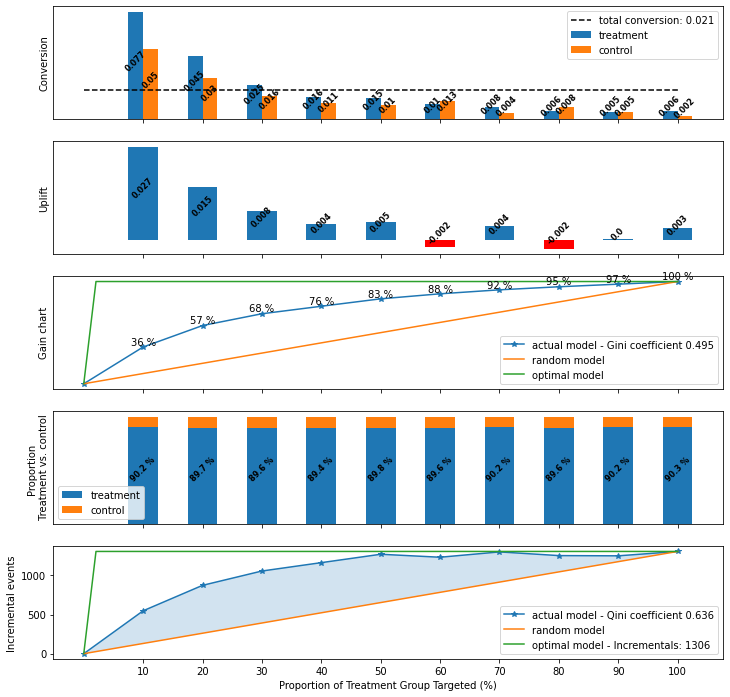

In [78]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           y_pred,
                                                           plot = True)

In [ ]:
# pd.to_pickle(catClass,'CatBoost_v01_qino_067.pickle')
# pd.to_pickle(classTslearner,'ClassTransformation_v01.pickle')

In [ ]:
#Doomy model
classTslearner2 = ClassTransformation(estimator = CatBoostClassifier(iterations=100,
                                                                    thread_count=-1, 
                                                                    random_state=42, 
                                                                    silent=True))
classTslearner2.fit(X = X_train,
                    y = y_train,
                   treatment = train_treatment)
y_pred = classTslearner2.predict(X_test)

In [ ]:
lift, uplift,gini, gain_top30,qini = EvalIncrementalModels(y_test,
                                                           test_treatment,
                                                           y_pred,
                                                           plot = True)